## Acknowledgement

This notebook is based on the book **["Build a Large Language Model (From Scratch)"](https://www.manning.com/books/build-a-large-language-model-from-scratch)** by **Sebastian Raschka**, published by Manning Publications.

- [Book on Manning](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- [GitHub Repository](https://github.com/rasbt/LLMs-from-scratch)

---

# **Pretraining on unlabeled data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/LLM from Scratch/chapter_5')
print(os.getcwd())

/content/drive/MyDrive/LLM from Scratch/chapter_5


In [ ]:
from IPython.display import Image, display
%matplotlib inline

Before this chapter, we have already implemented data sampling, attention mechanism and LLM architecture. Now, we will write the training function and pretrain the LLM. In this chapter, we will also learn about how to evaluate generated text, and load pretrained weights.

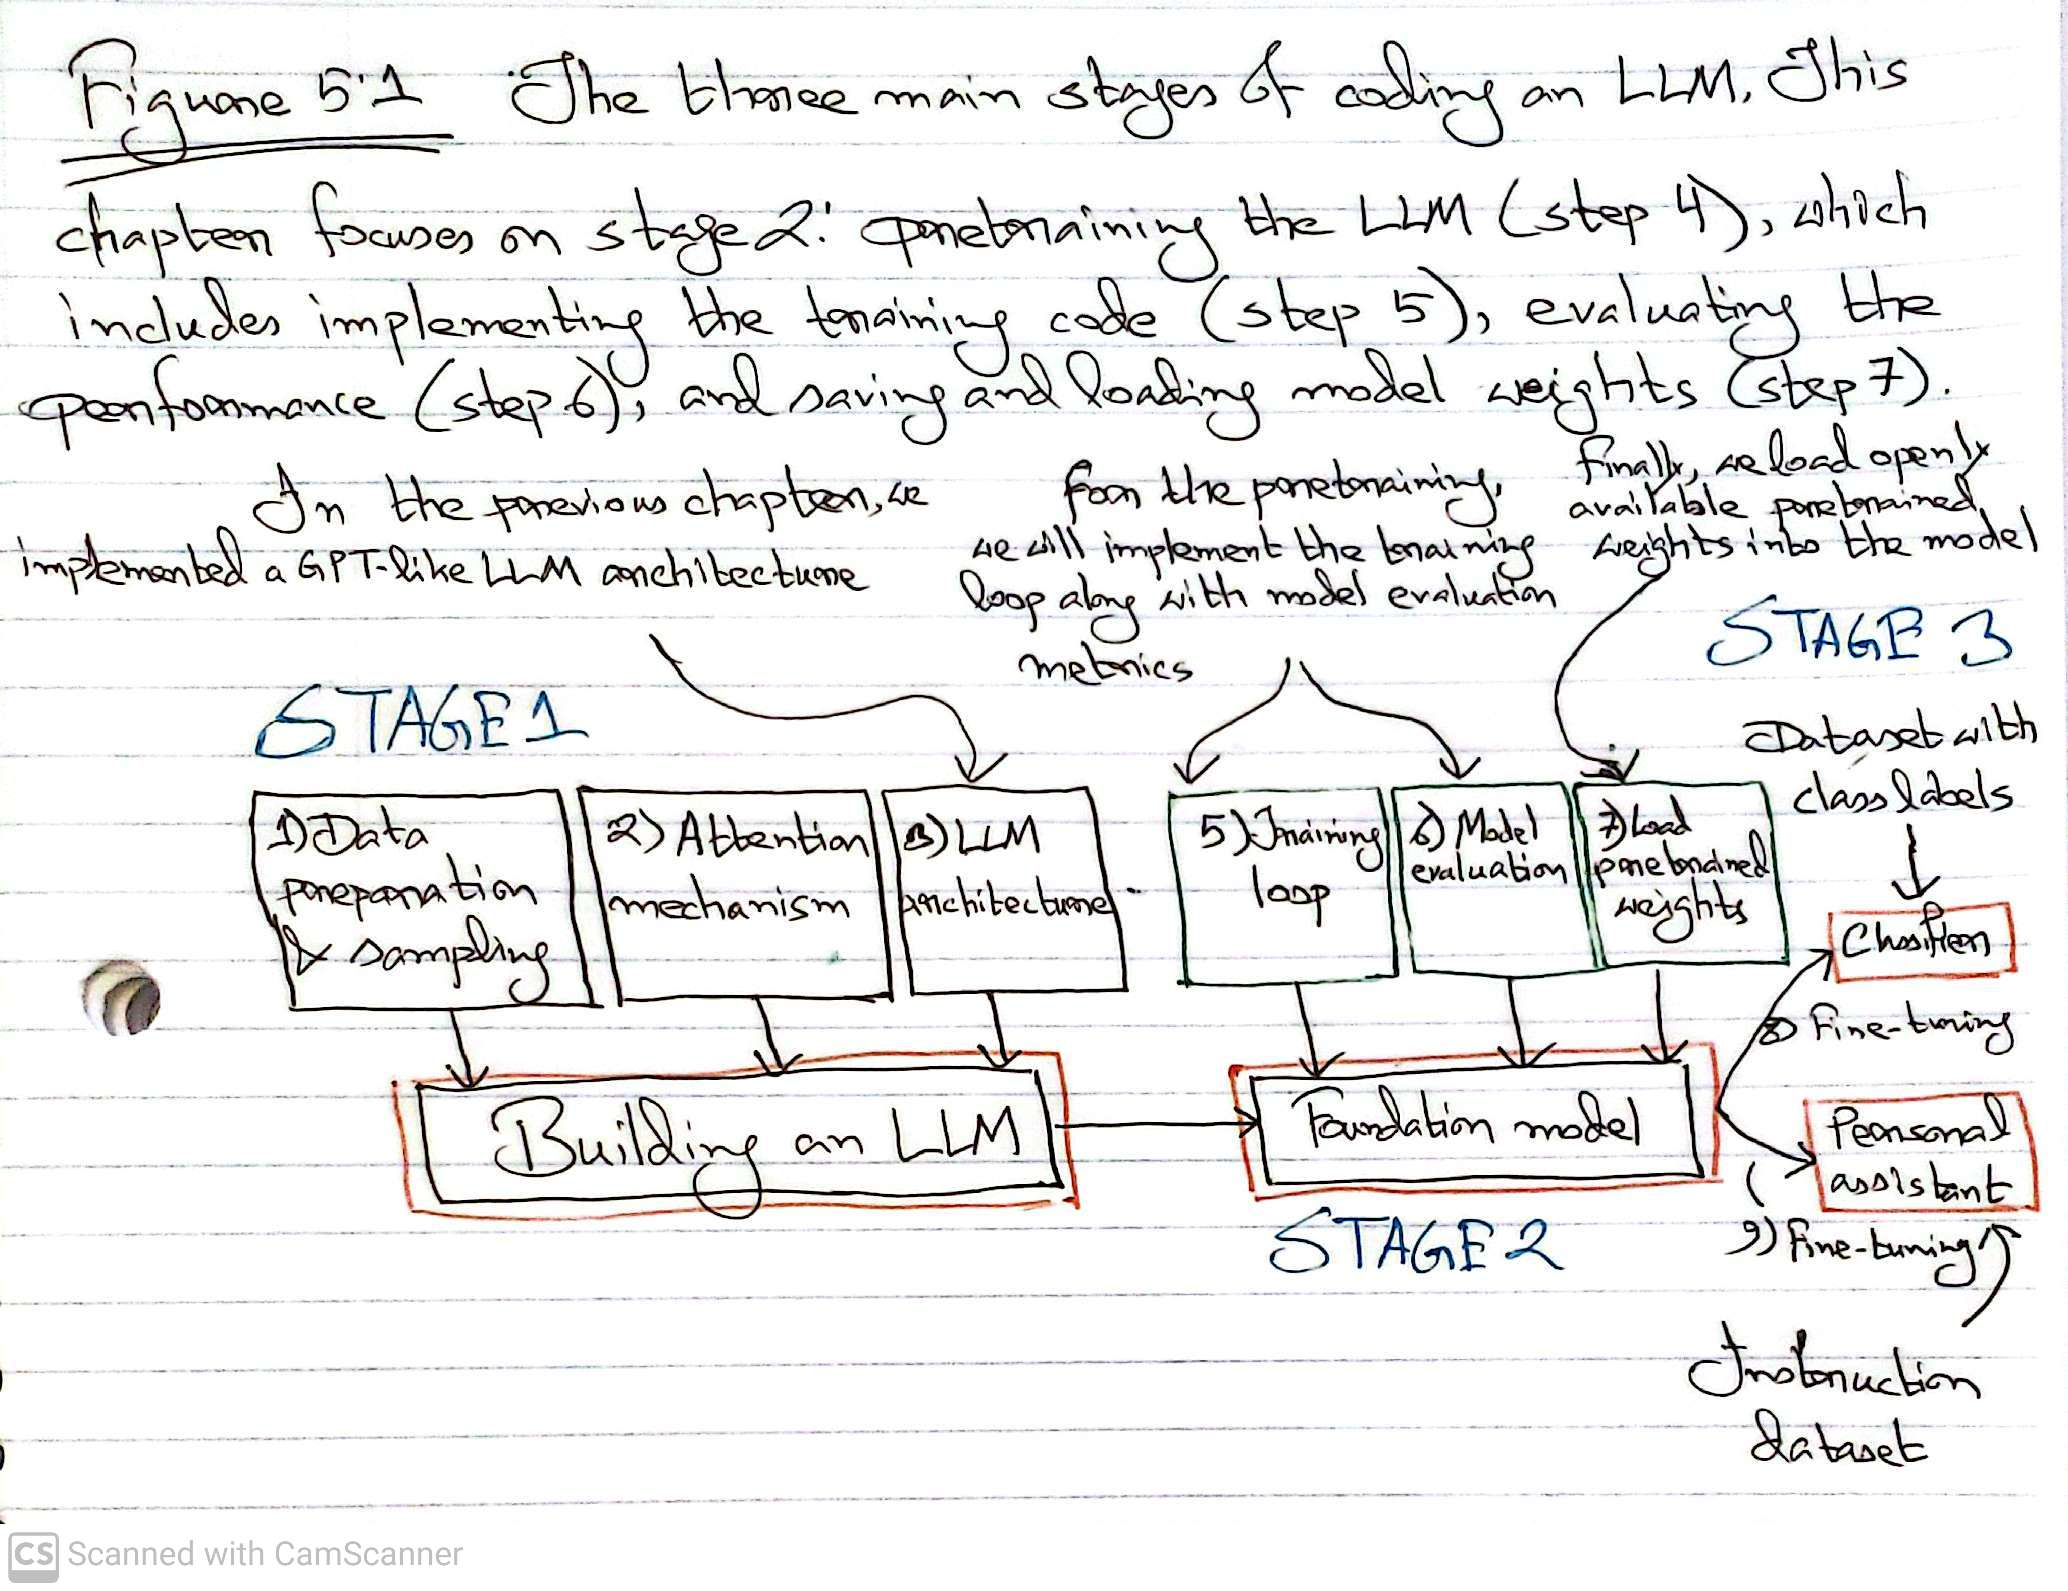

In [ ]:
display(Image(filename='5_1.jpg', width=800))

Import the code for GPT model that we already wrote in Chapter 4.

In [ ]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdims=True)
    var = x.var(dim=-1, keepdims=True, unbiased=False) # unbiased=False results in the division by n instead of n-1
    # Dividing by n-1 is known as Bessel's correction. So, we have biased estimate of variance.
    # GPT-2 was implemented using Tensorflow that used this approach. Also for LLMs, the difference between
    # n and n-1 is practically negligible.
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *
                                     (x + 0.044715 * torch.pow(x, 3))
                                     ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure that d_out is divisible by num_heads so each head has equal dimensions
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out  # Output dimensionality (total for all heads combined)
        self.num_heads = num_heads  # Number of attention heads
        self.head_dim = d_out // num_heads  # Dimensionality of each head

        # Linear layers to project input into queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)  # Project input to query space
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)    # Project input to key space
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)  # Project input to value space

        # Final linear layer to combine the results of all heads
        self.out_proj = nn.Linear(d_out, d_out)

        # Dropout layer for regularization to prevent overfitting
        self.dropout = nn.Dropout(dropout)

        # Upper triangular mask to prevent attention to future tokens (causality)
        # Shape: (context_length, context_length)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, num_tokens, d_in)
        """
        b, num_tokens, d_in = x.shape  # Extract batch size, number of tokens, and input dimensions

        # Project input x into queries, keys, and values
        keys = self.W_key(x)        # Shape: (batch_size, num_tokens, d_out)
        queries = self.W_query(x)  # Shape: (batch_size, num_tokens, d_out)
        values = self.W_value(x)   # Shape: (batch_size, num_tokens, d_out)

        # Split d_out into num_heads and head_dim for multi-head attention
        # Reshape keys, values, and queries to include a num_heads dimension
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       # Shape: (batch_size, num_tokens, num_heads, head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)   # Shape: (batch_size, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # Shape: (batch_size, num_tokens, num_heads, head_dim)

        # Transpose num_tokens and num_heads for easier computation across heads
        keys = keys.transpose(1, 2)       # Shape: (batch_size, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2) # Shape: (batch_size, num_heads, num_tokens, head_dim)
        values = values.transpose(1, 2)   # Shape: (batch_size, num_heads, num_tokens, head_dim)

        # Compute scaled dot-product attention scores
        # Multiplying queries with keys (transposed) along head_dim
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)

        # Apply the causality mask to prevent attention to future tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Mask for current sequence length
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Set masked positions to negative infinity

        # Normalize attention scores using softmax along the last dimension (num_tokens)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)

        # Apply dropout for regularization
        attn_weights = self.dropout(attn_weights)

        # Compute context vectors by multiplying attention weights with values
        context_vec = (attn_weights @ values)  # Shape: (batch_size, num_heads, num_tokens, head_dim)

        # Transpose back to original layout to combine the heads
        context_vec = context_vec.transpose(1, 2)  # Shape: (batch_size, num_tokens, num_heads, head_dim)

        # Flatten the multi-head output by merging num_heads and head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # Shape: (batch_size, num_tokens, d_out)

        # Final linear layer to combine information across heads
        context_vec = self.out_proj(context_vec)  # Shape: (batch_size, num_tokens, d_out)

        return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
                                  num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # (batch, n_token, vocab_size) --> gives logits for the last token --> last token is the prediction
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

The same function with comments for better understanding.

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """
    Generates text using a pre-trained language model.

    Parameters:
    - model: The language model used for text generation.
    - idx: The starting sequence of token indices (batch_size, initial_sequence_length).
    - max_new_tokens: The number of new tokens to generate.
    - context_size: The maximum number of tokens to consider for context during generation.

    Returns:
    - idx: The full sequence of token indices after generating new tokens.
    """

    # Loop to generate tokens one at a time until `max_new_tokens` are generated
    for _ in range(max_new_tokens):

        # Step 1: Prepare the input context by slicing the sequence
        idx_cond = idx[:, -context_size:]
        # effectively ensures that idx_cond always contains the most recent context_size tokens from the input sequence idx,
        # or the entire sequence if it's shorter than context_size. This is crucial for efficient and effective text generation
        # with fixed-context language models.
        # Explanation:
        # - `idx[:, -context_size:]`: Takes only the last `context_size` tokens from the sequence.
        # - This ensures that the model processes at most `context_size` tokens, avoiding memory overhead.
        # - If `context_size` is smaller than the sequence length, it truncates; otherwise, it uses the full sequence.
        # Why? Transformers are designed to handle fixed-length inputs, so slicing keeps the input within this length.

        # Step 2: Use the model to predict logits for the next token
        with torch.no_grad():  # Disable gradient computation to save memory and speed up inference
            logits = model(idx_cond)
        # Explanation:
        # - The model processes the sliced input (`idx_cond`) and predicts the next token probabilities.
        # - `logits` shape: (batch_size, sequence_length, vocab_size).

        # Step 3: Extract logits for the last position in the sequence
        logits = logits[:, -1, :] # (batch, n_token, vocab_size) --> gives logits for the last token
        # Explanation:
        # - `logits[:, -1, :]`: Focuses on the predictions for the last token in the sequence.
        # - Only the last token's logits are relevant since we want to predict the next token based on the current sequence.
        # - Shape: (batch_size, vocab_size).

        # Step 4: Convert logits to probabilities using the softmax function
        probas = torch.softmax(logits, dim=-1)
        # Explanation:
        # - `torch.softmax(logits, dim=-1)`: Converts raw logits into probabilities.
        # - Probabilities indicate how likely each token in the vocabulary is as the next token.
        # - Shape: (batch_size, vocab_size).

        # Step 5: Select the token with the highest probability
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # Explanation:
        # - `torch.argmax(probas, dim=-1)`: Finds the index of the token with the highest probability.
        # - `keepdim=True`: Ensures the resulting tensor maintains its dimensionality for compatibility.
        # - `idx_next` shape: (batch_size, 1), representing the predicted next token for each sequence in the batch.

        # Step 6: Append the predicted token to the input sequence
        idx = torch.cat((idx, idx_next), dim=1)
        # Explanation:
        # - `torch.cat((idx, idx_next), dim=1)`: Concatenates the new token (`idx_next`) to the existing sequence (`idx`).
        # - This updates the sequence, making it ready for the next iteration.
        # - Shape of `idx` after concatenation: (batch_size, current_sequence_length + 1).

    # After generating `max_new_tokens`, return the updated sequence
    return idx


## **Evaluating generative text models**

We will set up our LLM for text generation and learn how to evaluate the quality of the generated text.

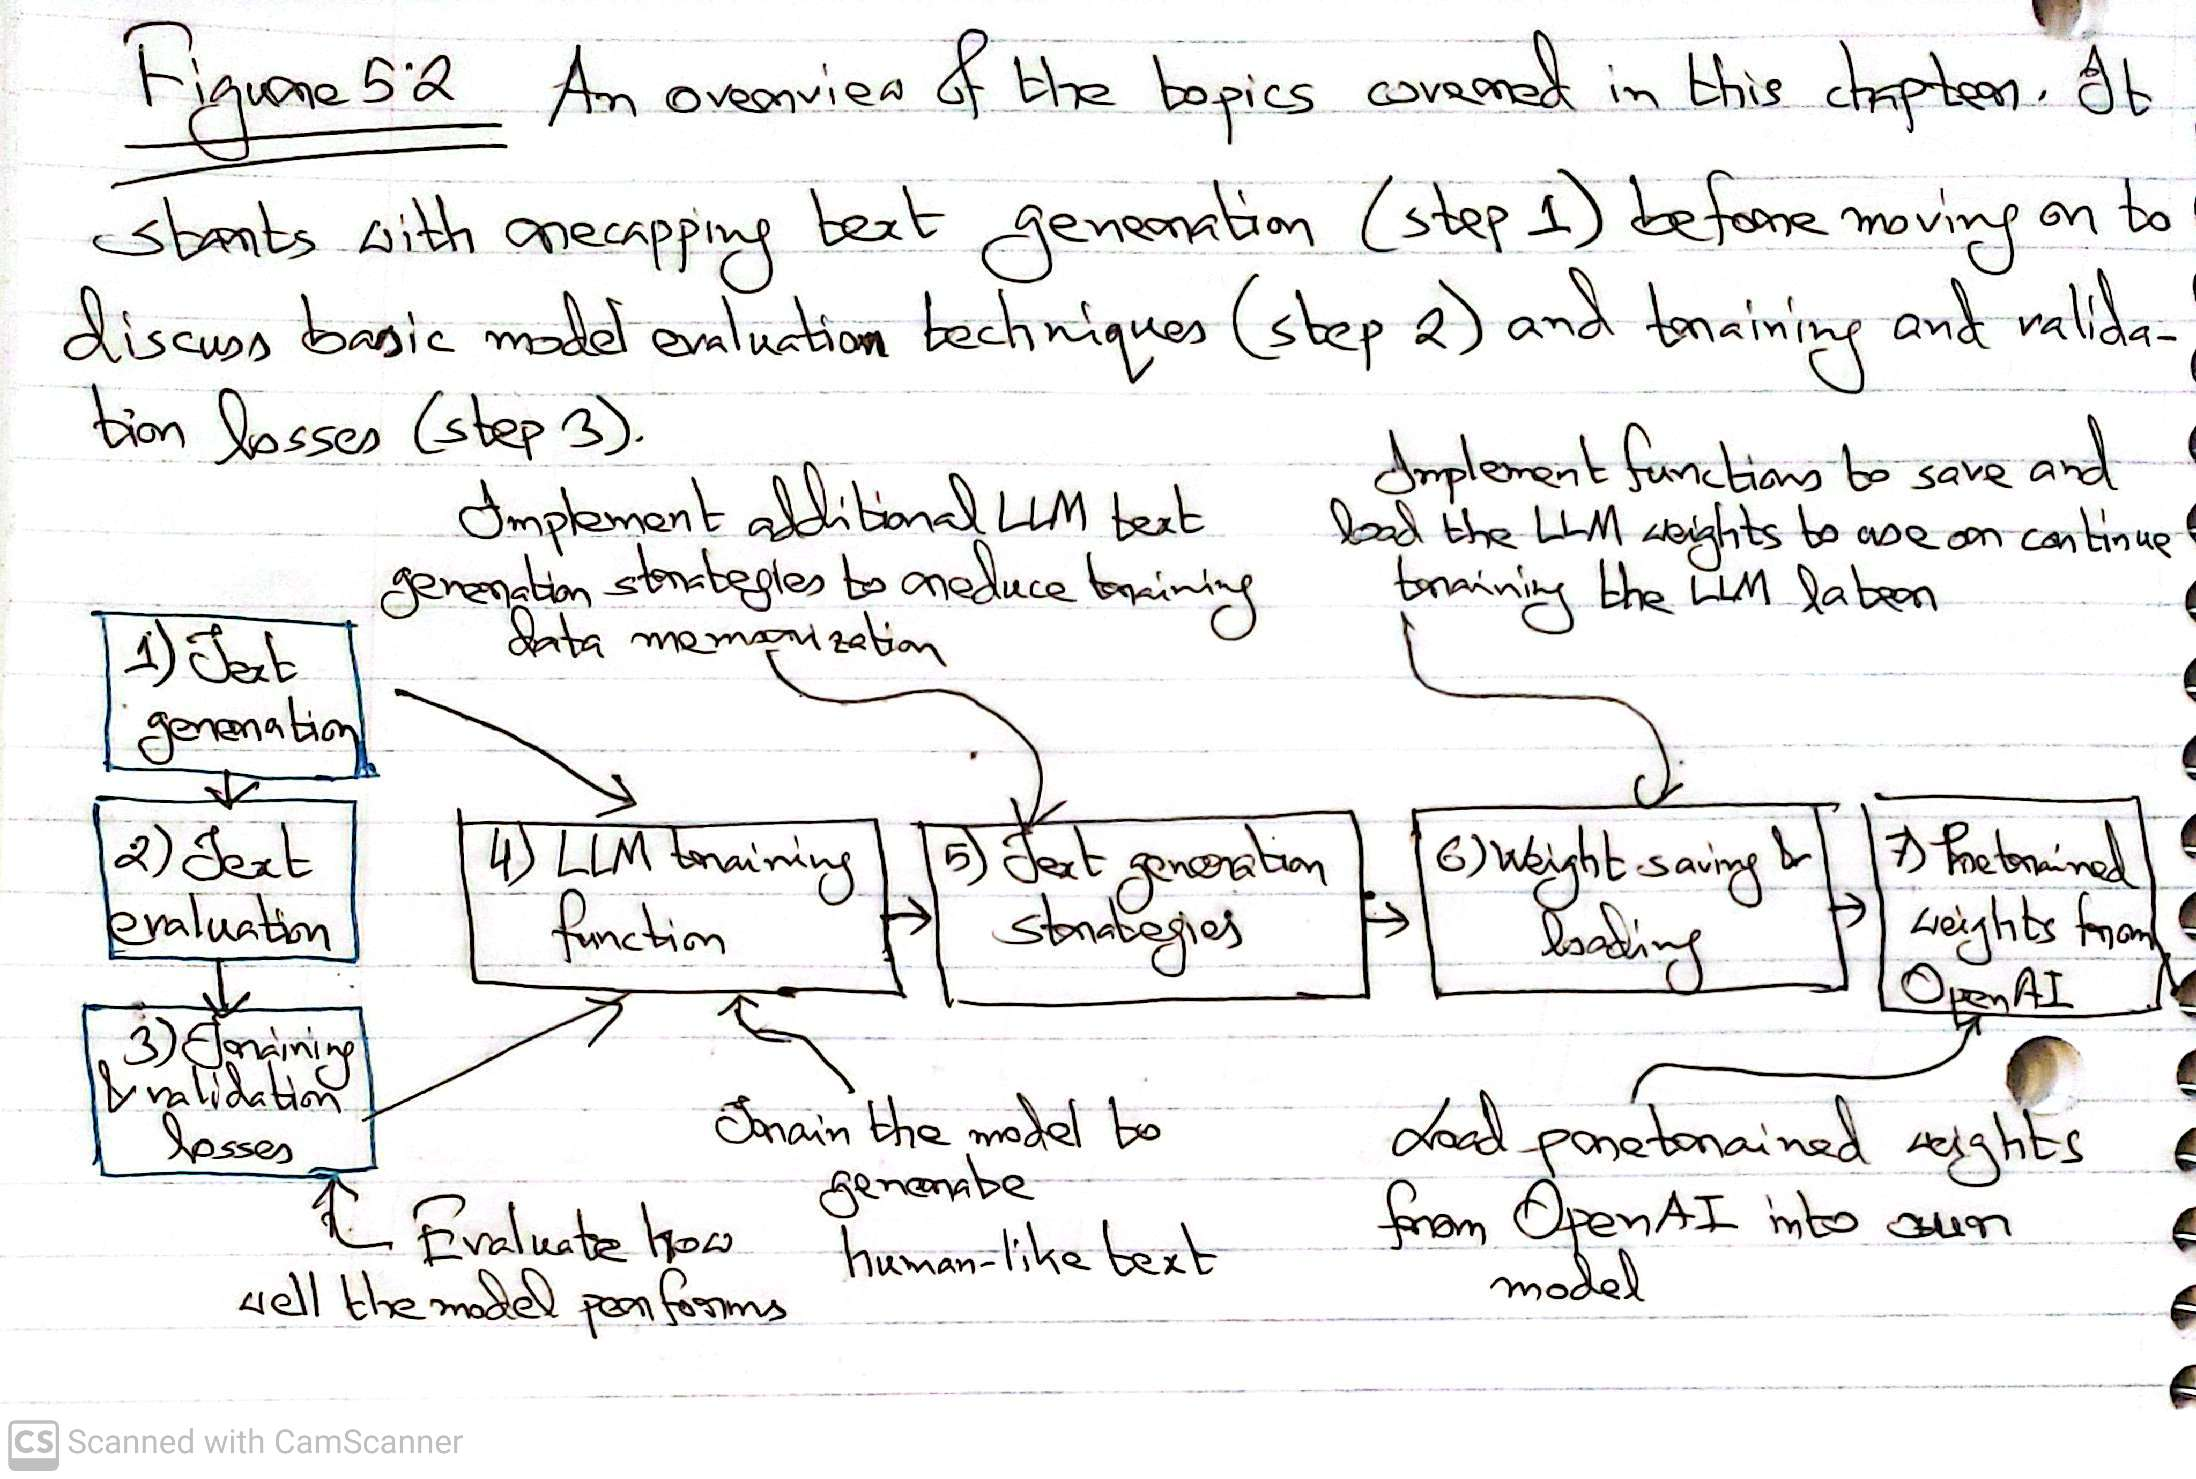

In [ ]:
display(Image(filename='5_2.jpg', width=800))

## **Using GPT to generate text**

Now, we will initialize the GPT model that we will later evaluate and train using the `GPTModel` class and `GPT_CONFIG_124M` dictionary.

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 256, # Context_length
    "emb_dim": 768, # Embedding dimension
    "n_layers": 12, # Number of transformer blocks
    "n_heads": 12, # Number of attention heads
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias -- determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key and value computations
}

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Here, we reduced the context length (`context_length`) to 256 tokens as compared to GPT-2 models's 1024 tokens. But after the training, we will update the context size to 1024 and work with pretrained weights.

### **Text to token generation**

Here, we will introduce two new functions `text_to_token_ids` and `token_ids_to_text` that will be used for conversion between texts and tokens.

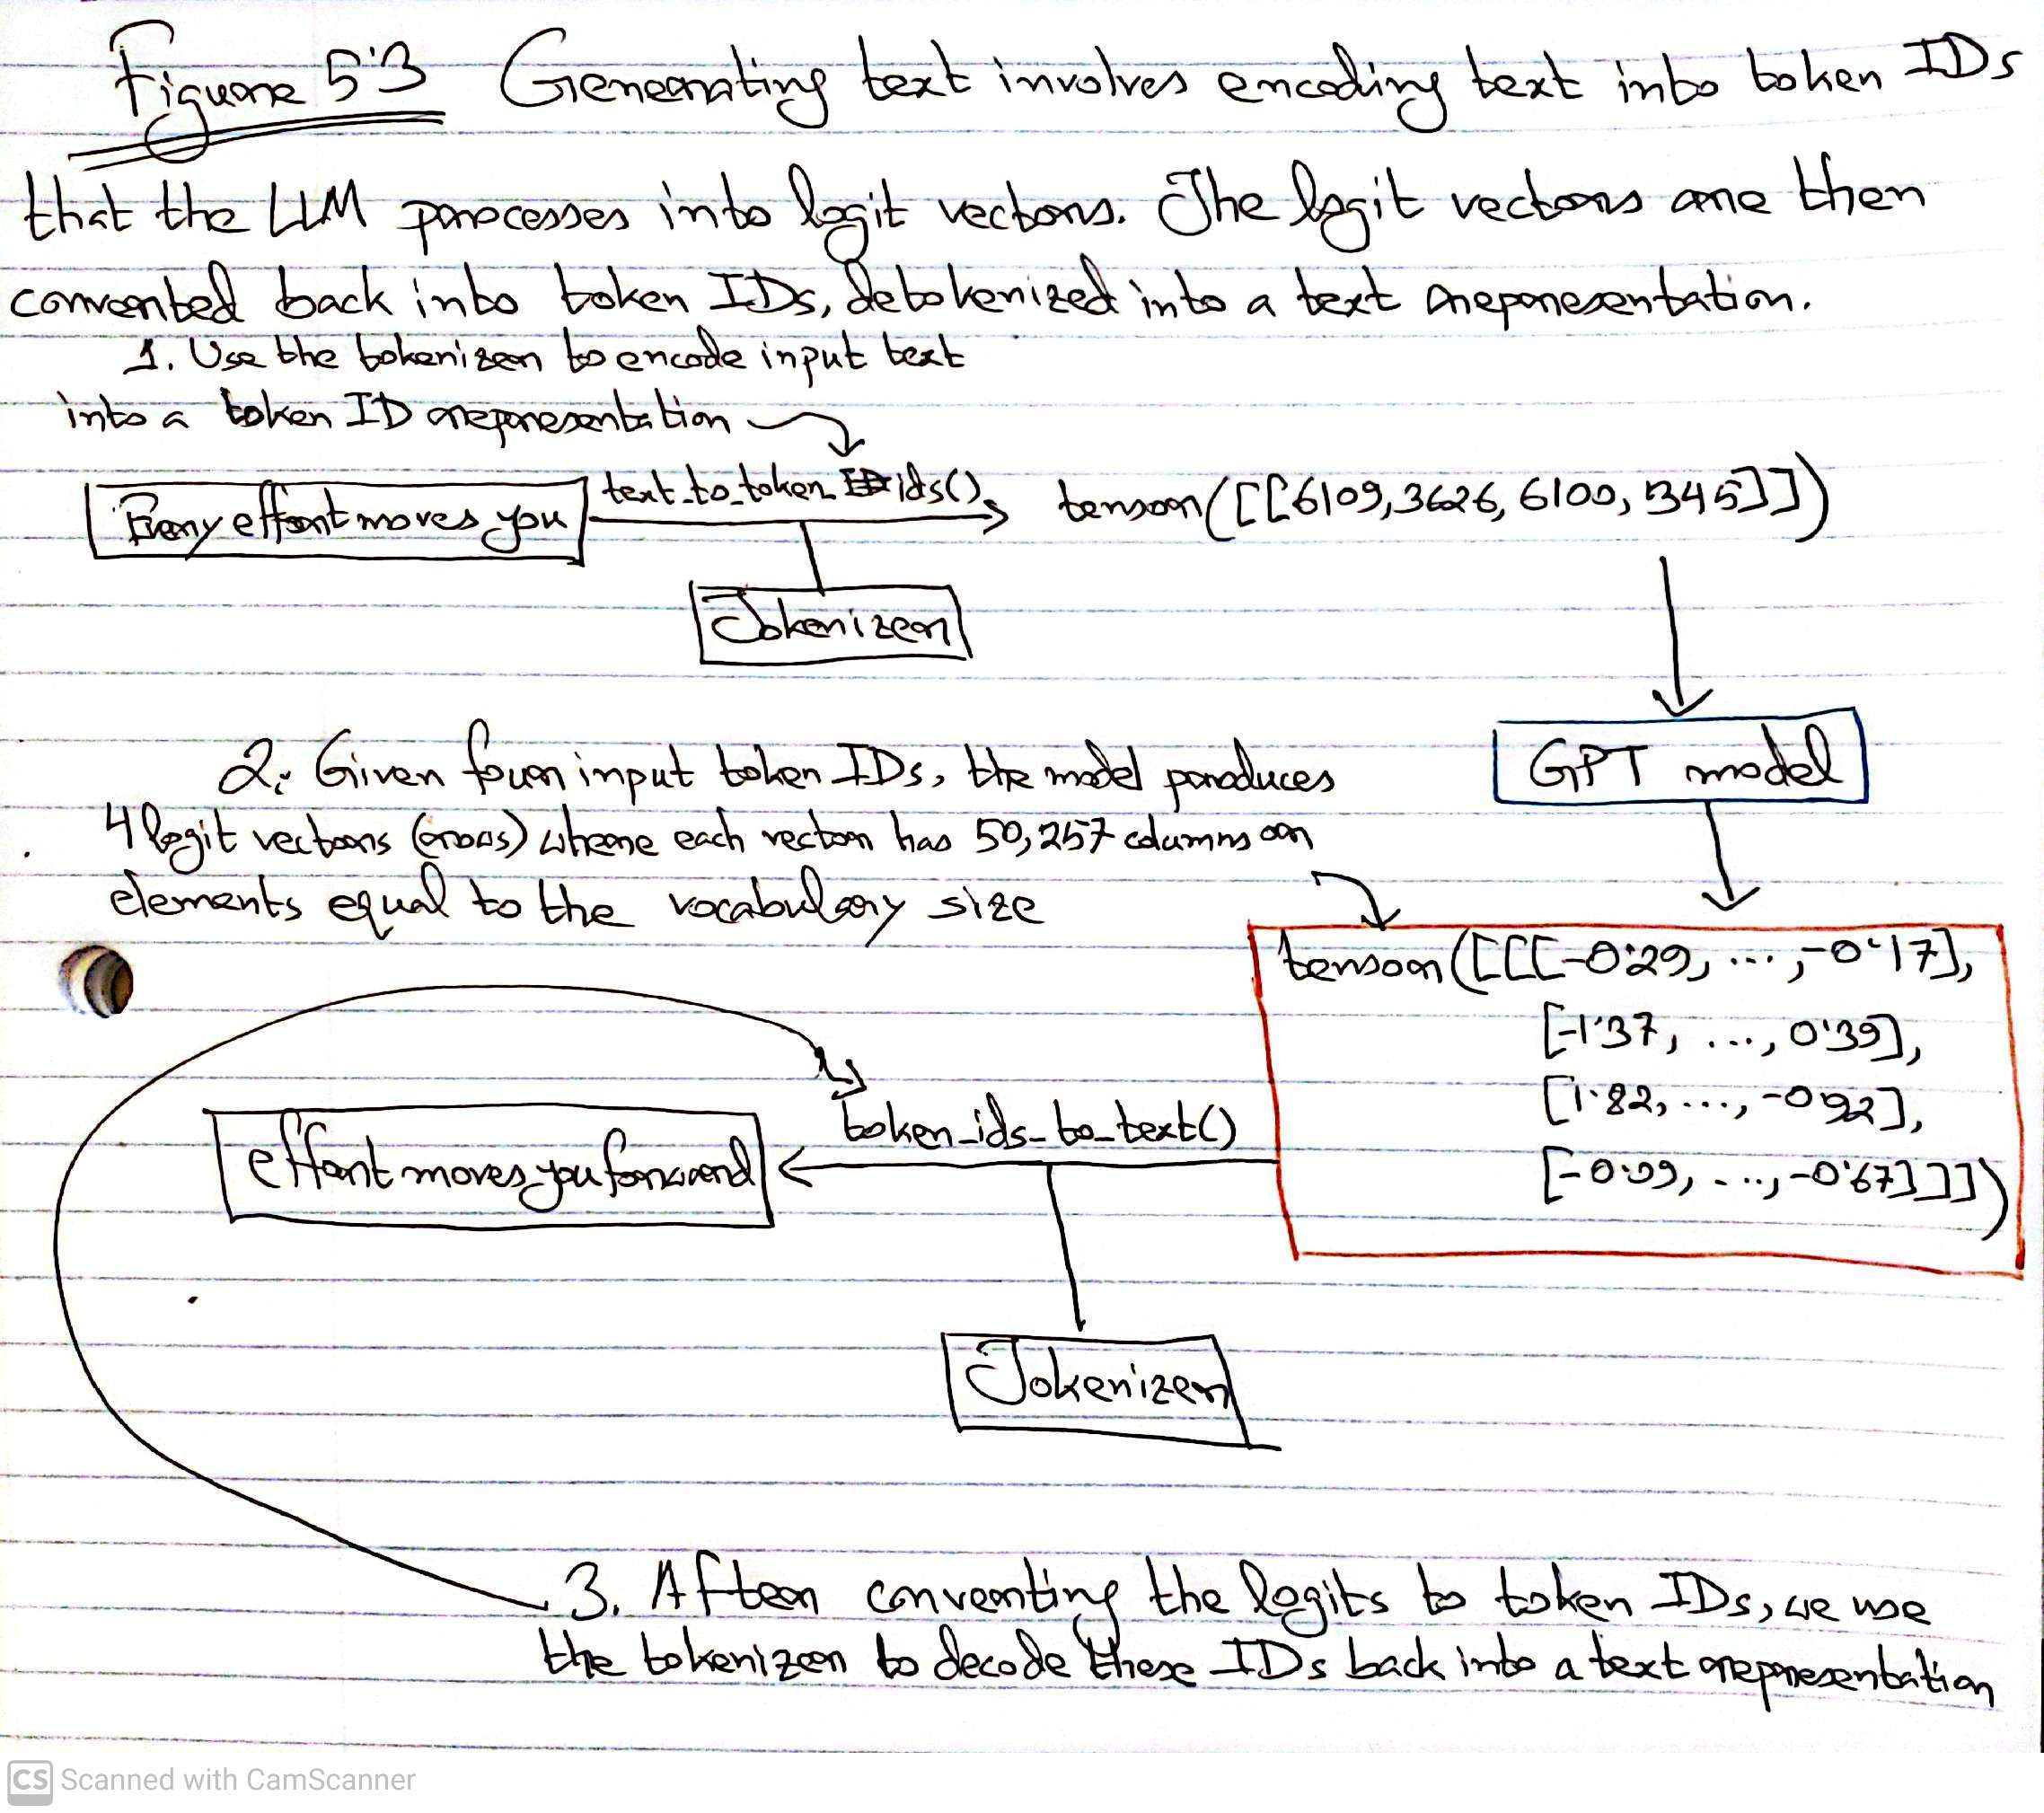

In [ ]:
display(Image(filename='5_3.jpg', width=800))

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  decoded = tokenizer.decode(flat.tolist())
  return decoded

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer),
                                 max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


We can see that the model is producing gibberish because we haven't trained the model yet. In the next section, we will write code for loss metric that will be used to evaluate the generated content.

## **Calculating the text generation loss**

First have a look at the text generation process.

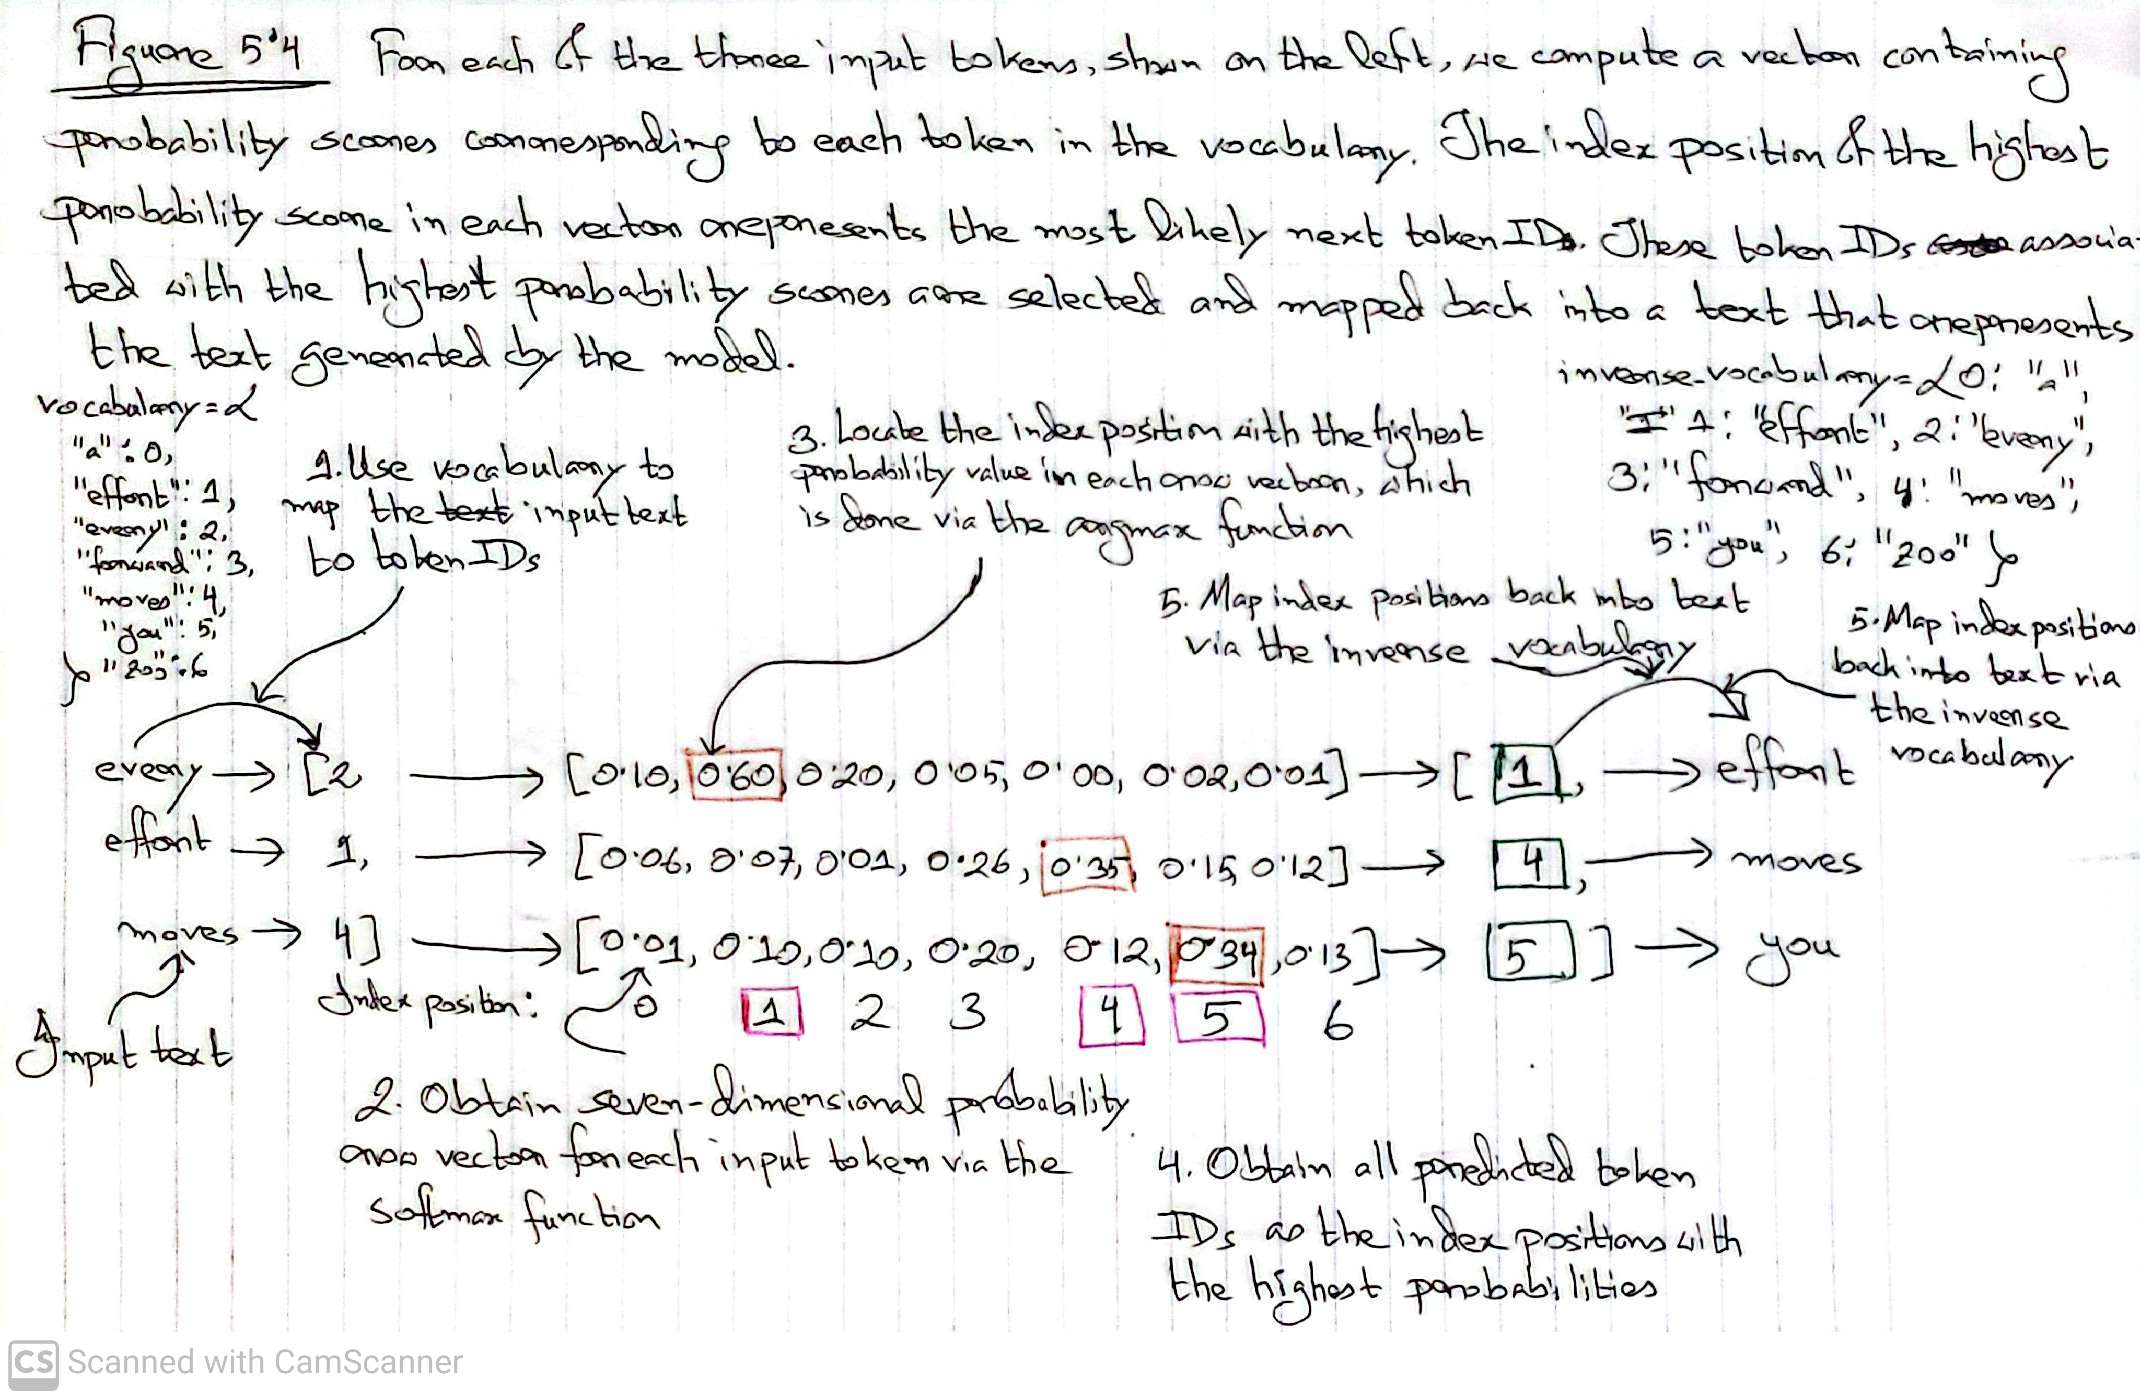

In [ ]:
display(Image(filename='5_4.jpg', width=800))

The figure above shows an example for a vocabulary with seven tokens. But the `GPTModel` we are working with have a vocabulary consisting of 50,257 words. Thus, for our model, the token IDs will range from 0 to 50256 and not 0 to 6.

Also the example used in the figure above uses one text **"every effort moves"**, while the input examples we will use will have two sentences **"every effort moves"** and **"I really like"**.

Look at the token IDs corresponding to this input of two sentences.

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

The `targets` variable contains the token IDs we want the model to produce. Here the targets are the inputs shifted forward by one position.

In [ ]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

Now, calculate the logits and apply `softmax` to logits to transform them into probability scores.

In [ ]:
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


### **`torch.Size([2, 3, 50257])`**

- Here 2 represents the batch size or the number of rows in the inputs.

- 3 represents the number of tokens in each input.

- 50527 is the embedding dimension; here it is the vocabulary size.

Below is the logit matrix.

In [ ]:
probas

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

We can complete step 3 and 4 by using `argmax` with the probability scores to get the associated token IDs with the highest probability score.

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdims=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


The text above shows the two sets of outputs with three predicted token IDs for both of these two sentences.

**Convert token IDs back to text:**

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


We can see that the generated text is very different from the target text. Now, we will code loss function that will help us both in performing model evaluation and also in model training.

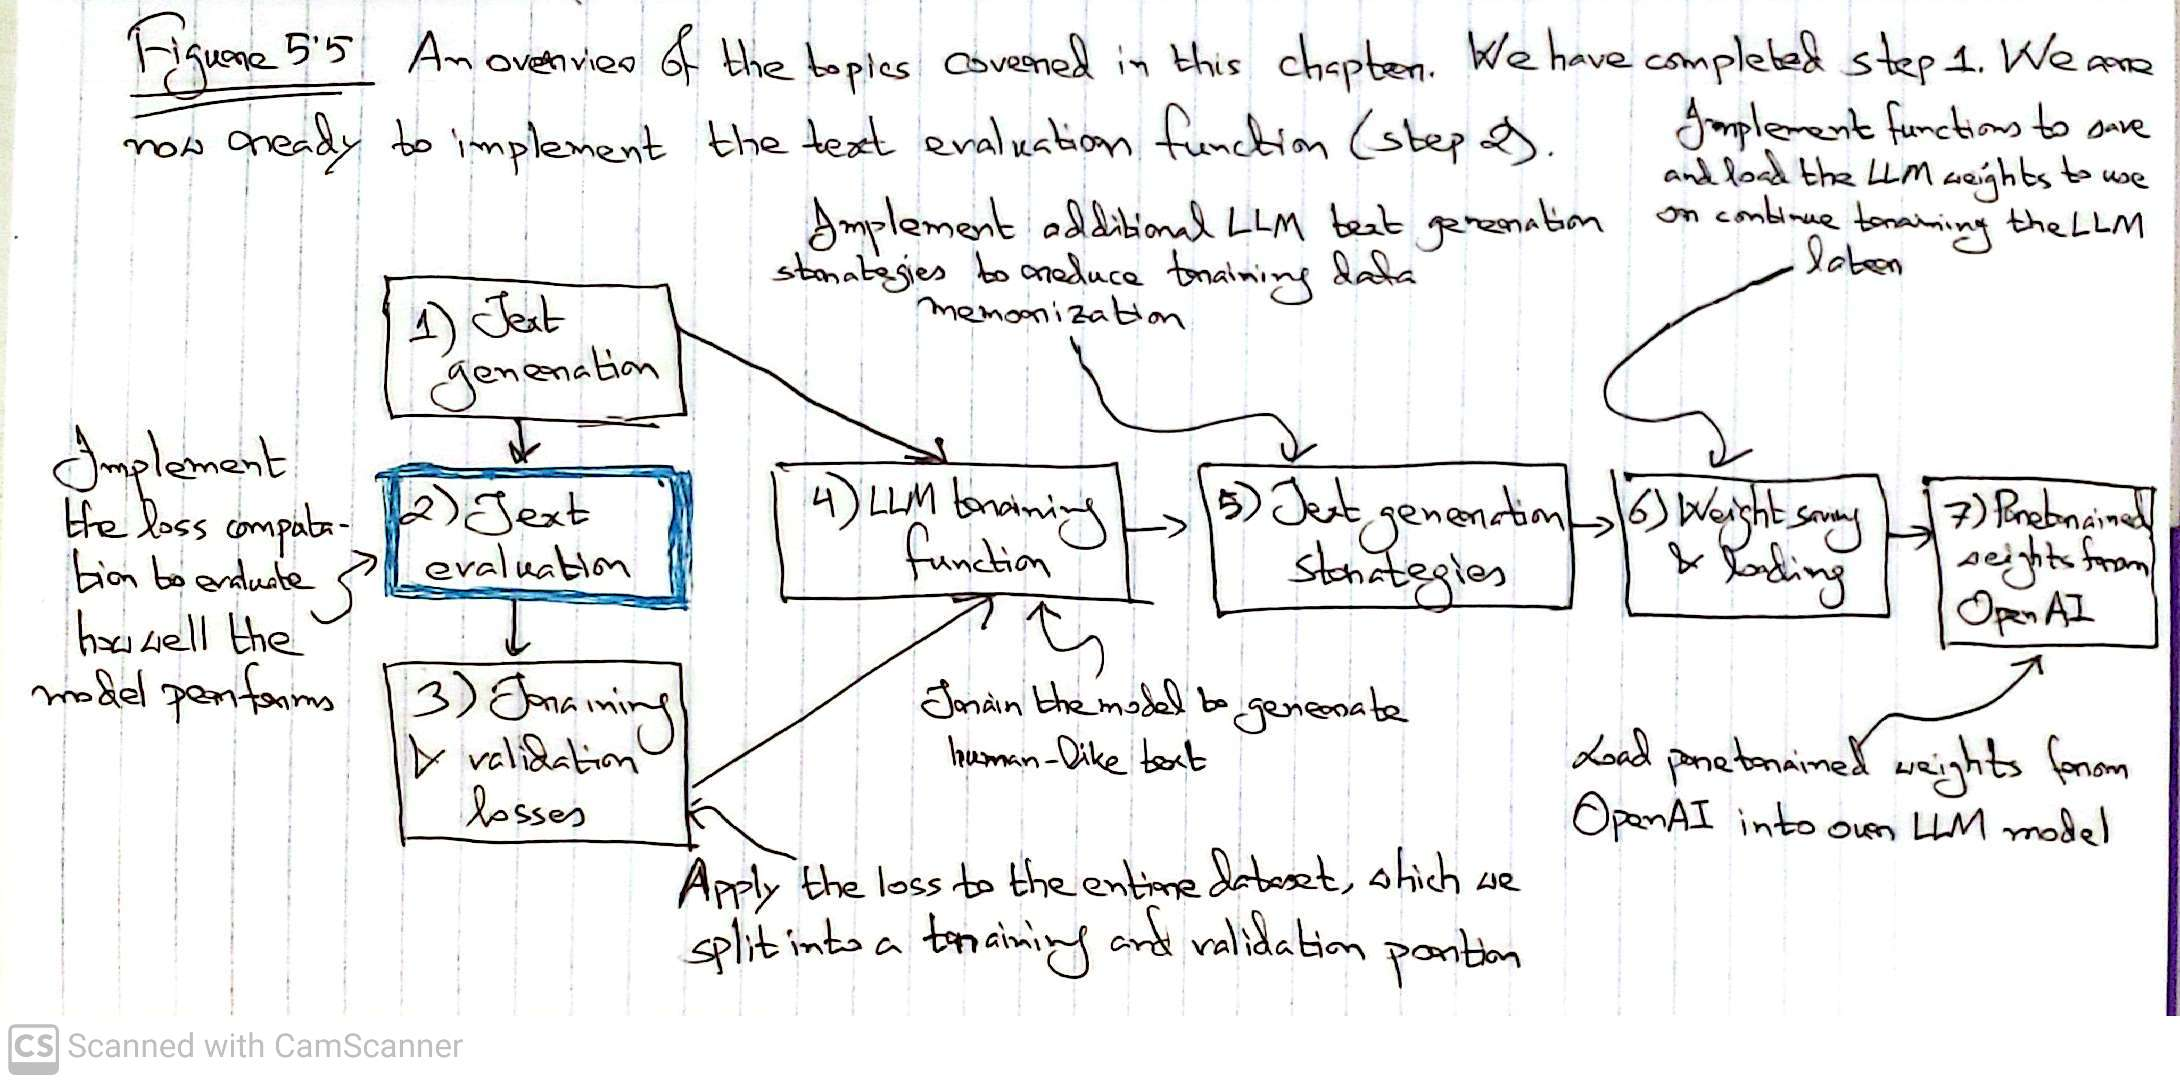

In [ ]:
display(Image(filename='5_5.jpg', width=800))

We want to increase the softmax probability in the index positions corresponding to the correct target token IDs. This softmax probability is also used in the evaluation metric, the higher it is in the correct position, the better.

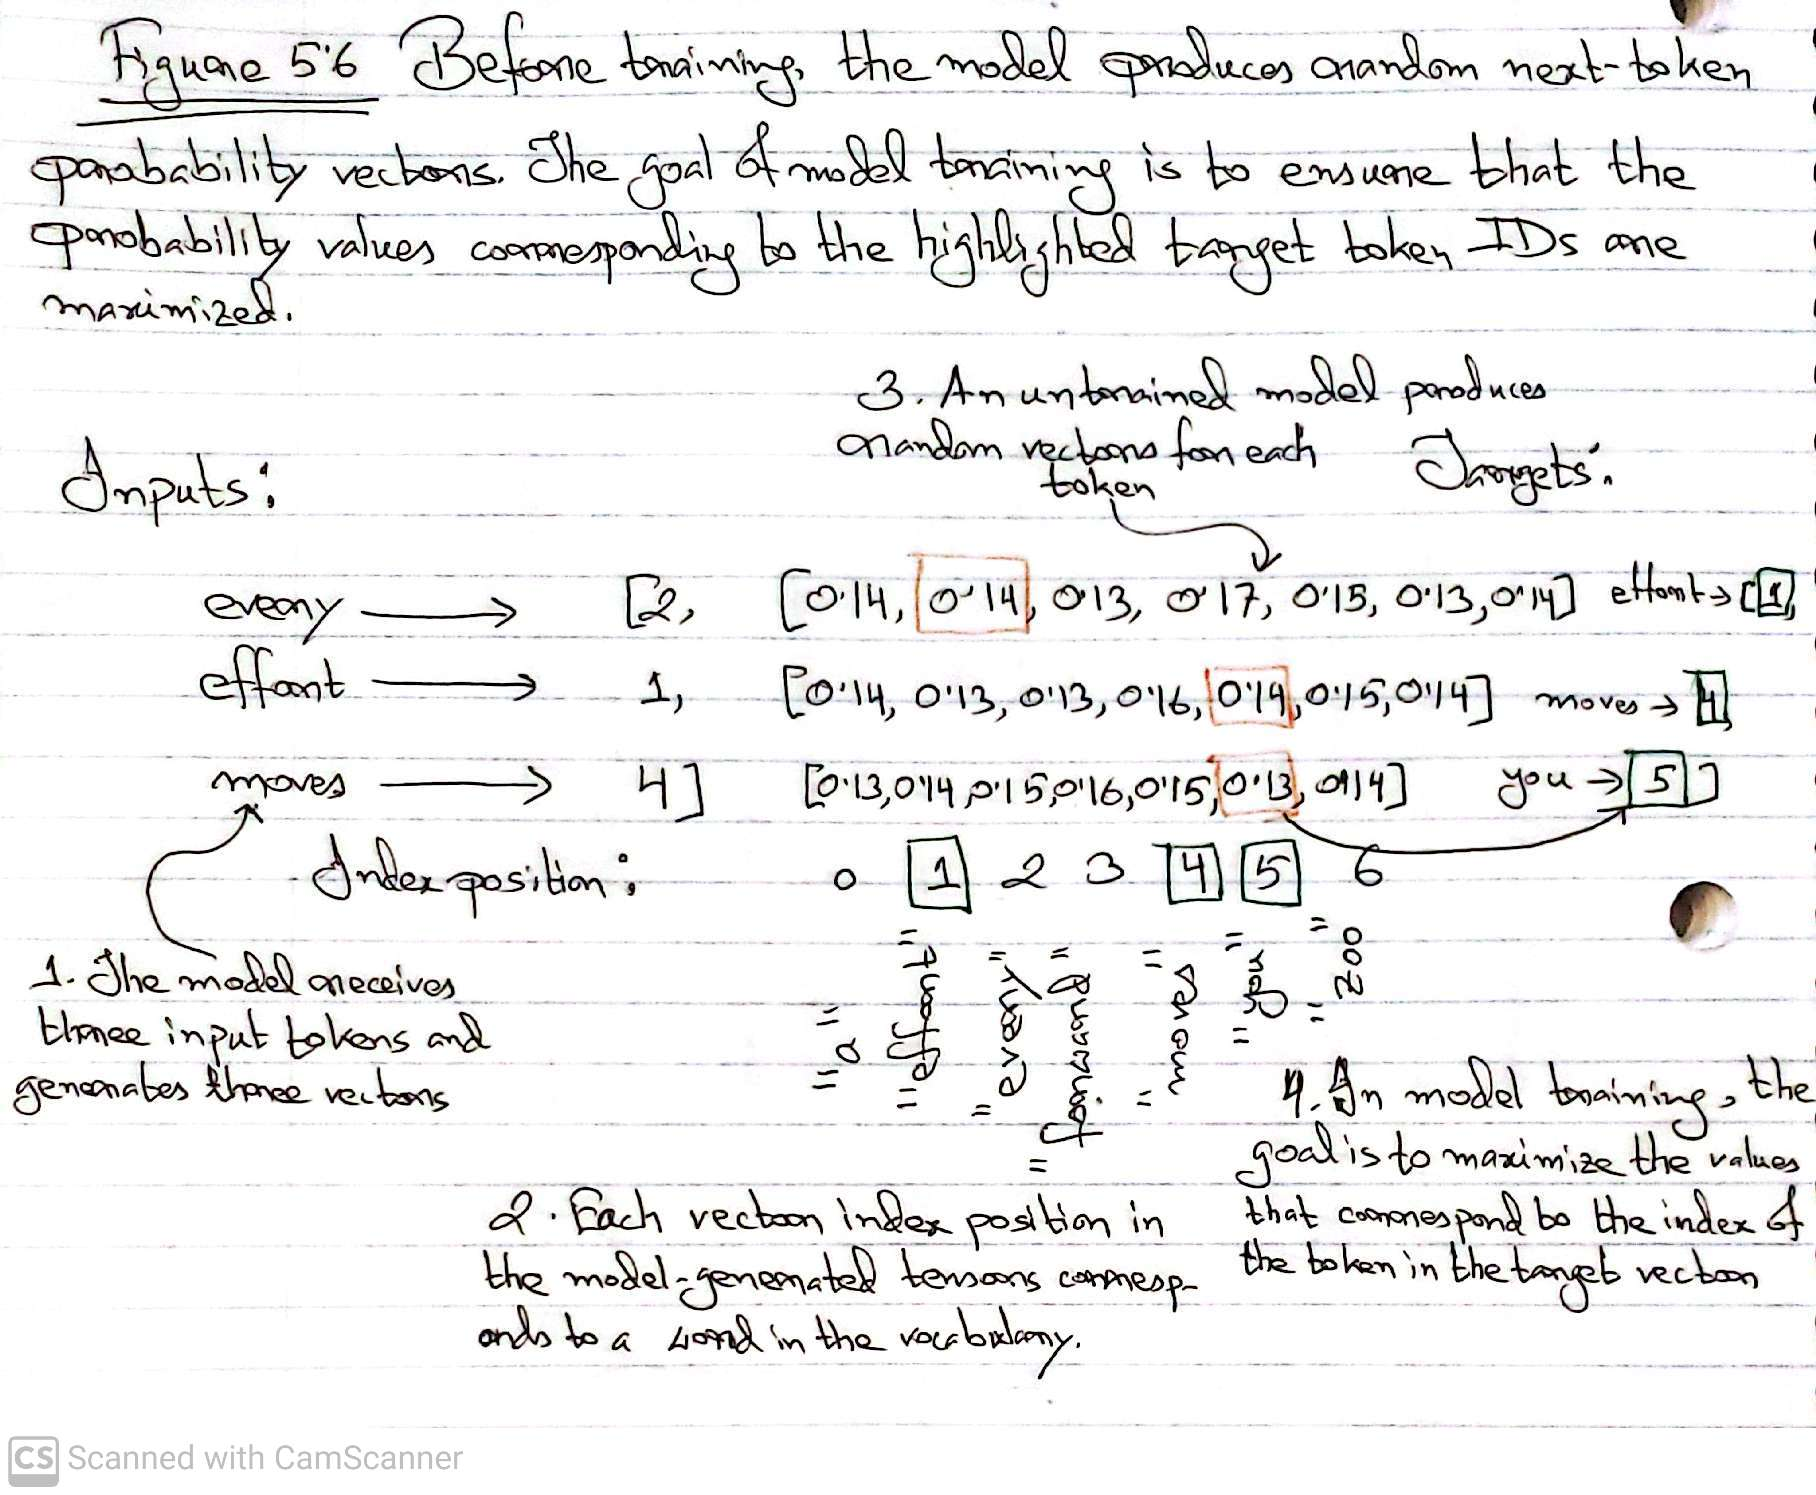

In [ ]:
display(Image(filename='5_6.jpg', width=800))

Initial softmax porobability scores corresponding to the target tokens are:

In [ ]:
text_idx = 0 # Batch number one or first sentence
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [0, 1, 2] correspond to first, second and third tokens
print("Text 1:", target_probas_1)

text_idx = 1 # Batch number 2 or second sentence
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [ ]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

# Understanding `probas`

`probas` is a 3D tensor of shape `(2, 3, 50257)`, where:  
- `2` → Number of input sequences (batch size).  
- `3` → Number of tokens in each sequence.  
- `50257` → Number of possible tokens (vocabulary size).

Now, let’s break the indexing step by step:

---

1. **`text_idx`**  
   - `text_idx = 0` refers to the first sequence (batch 1: `“every effort moves” → “effort moves you”`).  
   - `text_idx = 1` refers to the second sequence (batch 2: `“I really like” → “really like chocolate”`).

2. **`[0, 1, 2]`**  
   This part selects all three positions (tokens) from the sequence.

_For example, if `text_idx = 0`, then:_  
- `0` → First token in the sequence (`every` in `“every effort moves”`)  
- `1` → Second token (`effort`)  
- `2` → Third token (`moves`)

3. **`targets[text_idx]`**  
   `targets` is a tensor with the expected next tokens for each sequence:

```python
targets = torch.tensor([
    [3626, 6100, 345],    # ["effort moves you"]
    [1107, 588, 11311]    # ["really like chocolate"]
])
```

`targets[text_idx]` gives the corresponding target tokens for the chosen sequence.

- If `text_idx = 0`, then `targets[0] = [3626, 6100, 345]`

- If `text_idx = 1`, then `targets[1] = [1107, 588, 11311]`

## 4. What Does This Line Do?

```python
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
```

- This extracts the probabilities of the **correct** (expected) next tokens.

- `probas[text_idx]` selects the probability distribution for the chosen sequence.

- `[0, 1, 2]` picks the probability vectors for the first, second, and third tokens.

- `targets[text_idx]` selects the correct next token for each position.

**Example:**

Assume `probas` contains probability distributions for each token position:

```python
probas[0, 0] = [0.0001, 0.0002, ..., 0.004, ..., 7.4541e-05, ...]  # Probabilities for first token  
probas[0, 1] = [0.002,    ..., 0.003,    ..., 3.1061e-05, ...]    # Probabilities for second token  
probas[0, 2] = [0.001,    ..., 1.1563e-05, ...]                 # Probabilities for third token  
```

**Now:**

```python
target_probas_1 = probas[0, [0, 1, 2], [3626, 6100, 345]]
```

- Takes the probability at index `3626` from `probas[0, 0]`

- Takes the probability at index `6100` from `probas[0, 1]`

- Takes the probability at index `345` from `probas[0, 2]`

### **5. Why This Indexing?**

This extracts the probabilities of the **correct next words** so that we can measure how confident the model is about predicting the expected output.

**So, our goal is to maximize the likelihood of the correct tokens or the next token it generates.**

Now, we will calculate log of probability that will be used to calculate negative of of average log probability whcih is ultimately used as the loss.

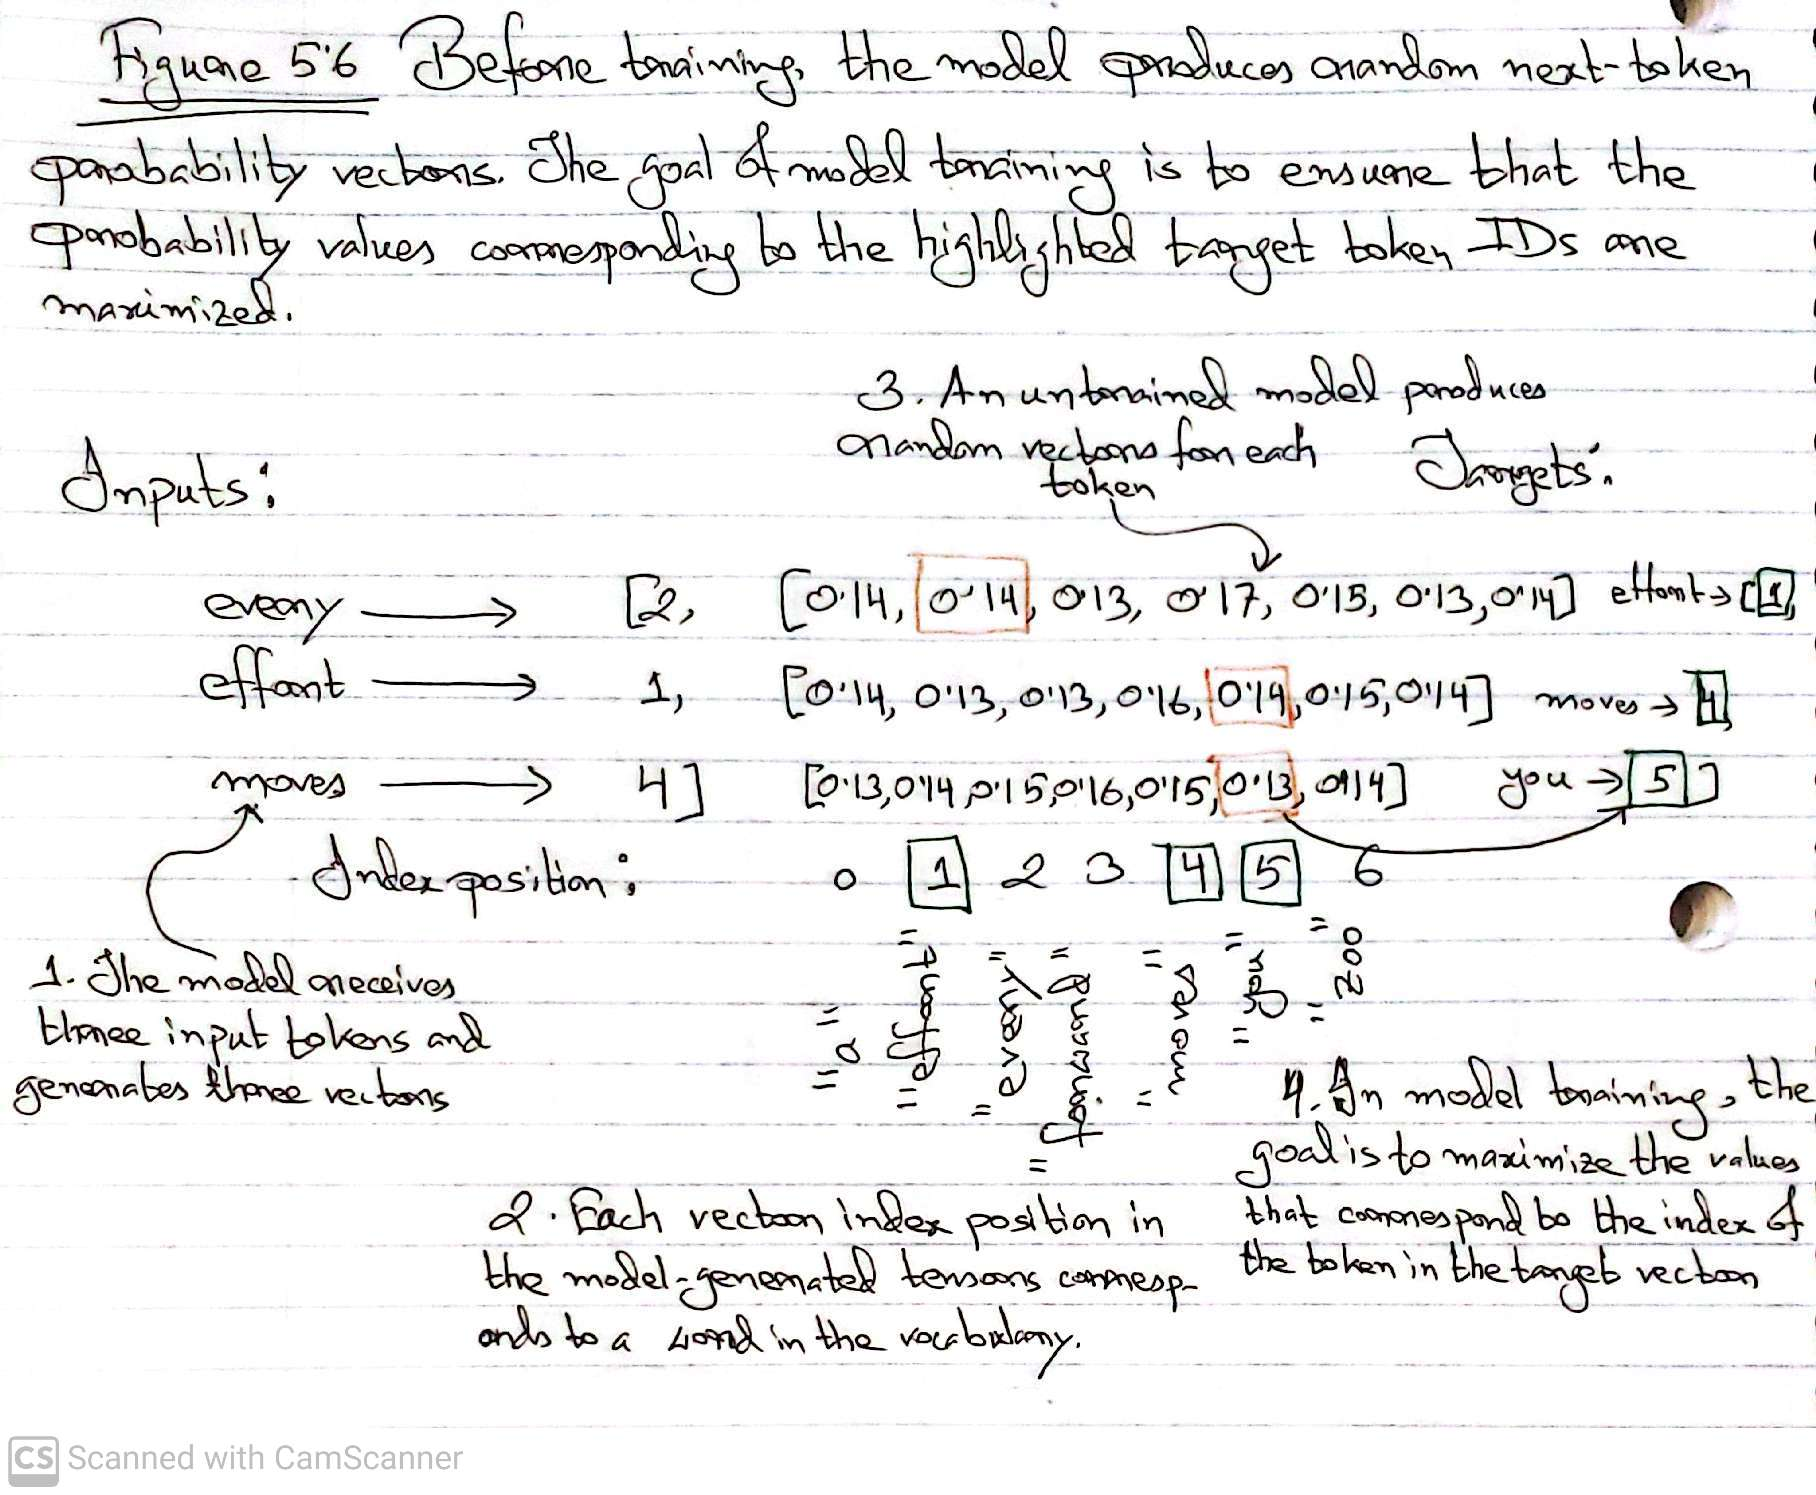

In [ ]:
display(Image(filename='5_7.jpg', width=800))

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Using lof of probability scores is more usable for mathematical optimization. Now, we combine these into one score by taking the mean.

In [ ]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In deep learning, our target is to reduce the error to 0 and not increase from a negative number to 0. This is why we multiply it by 1 and then we get a postive value which we can then decrease to 0. This multiplication by a negative number is called cross-entropy loss.

In [ ]:
neg_avg_log_probas = avg_log_probas * (-1) # Cross-entropy loss
print(neg_avg_log_probas)

tensor(10.7940)


In [ ]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


If we want to use PyTorch's `cross_entropy` loss function, we will need to flatten the tensors by combining them over the batch dimensions.

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


```python
# Before flattening:
# logits.shape = [2, 3, 50257]   # (batch_size, seq_len, vocab_size)
# targets.shape = [2, 3]        # (batch_size, seq_len)
```

1. `logits_flat = logits.flatten(0, 1)`

  - The call `.flatten(0, 1)` merges dimensions 0 through 1 into a single new dimension.

  - You started with shape `[2, 3, 50257]`. Merging dim 0 (`2`) and dim 1 (`3`) gives you `2 × 3 = 6` in the new first axis, so you end up with `[6, 50257]`.

  - In effect, you’ve taken all tokens across all batches and laid them out as a single “batch” of 6 token-predictions, each of which has a 50 257-dimensional logits vector.

2. `targets_flat = targets.flatten()`

  - With no arguments, `.flatten()` collapses all dimensions into one.

  - You go from `[2, 3]` to `[2 × 3] = [6]`.

  - Now you have a 1D array of 6 target token-IDs—one for each of those 6 logits rows.

### **Why do this?**

Most classification losses in PyTorch (e.g. `nn.CrossEntropyLoss`) expect inputs of shape:

- **Logits:** `(N, C)` where `N` is the total number of examples and `C` is number of classes.

- **Targets:** `(N,)` giving one integer class label per example.

By flattening:

- **logits_flat** is **(6, 50257)** → 6 examples, each with a distribution over 50,257 tokens.

- **targets_flat** is **(6,)** → the 6 correct token-IDs.

You can now call:

```python
loss = F.cross_entropy(logits_flat, targets_flat)
```

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


We can see that the loss calculated using croo entropy is the same as the loss we computed using the negative of average log probability.

Perplexity is used to measure how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset. The lower the perplexity, the closer the predictions are to the actual distribution. Perplexity gives us more interpretable value. In the code below, we see that the **perplexity has a value of 58725.82** which means that **the model is unsure about which among 48725 tokens in the vocabulary to generate as the next token**.

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


## **Calculating the training and validation set losses**

We need to prepare the training and validation datasets first to train the LLM and calculate entropy for these datasets.

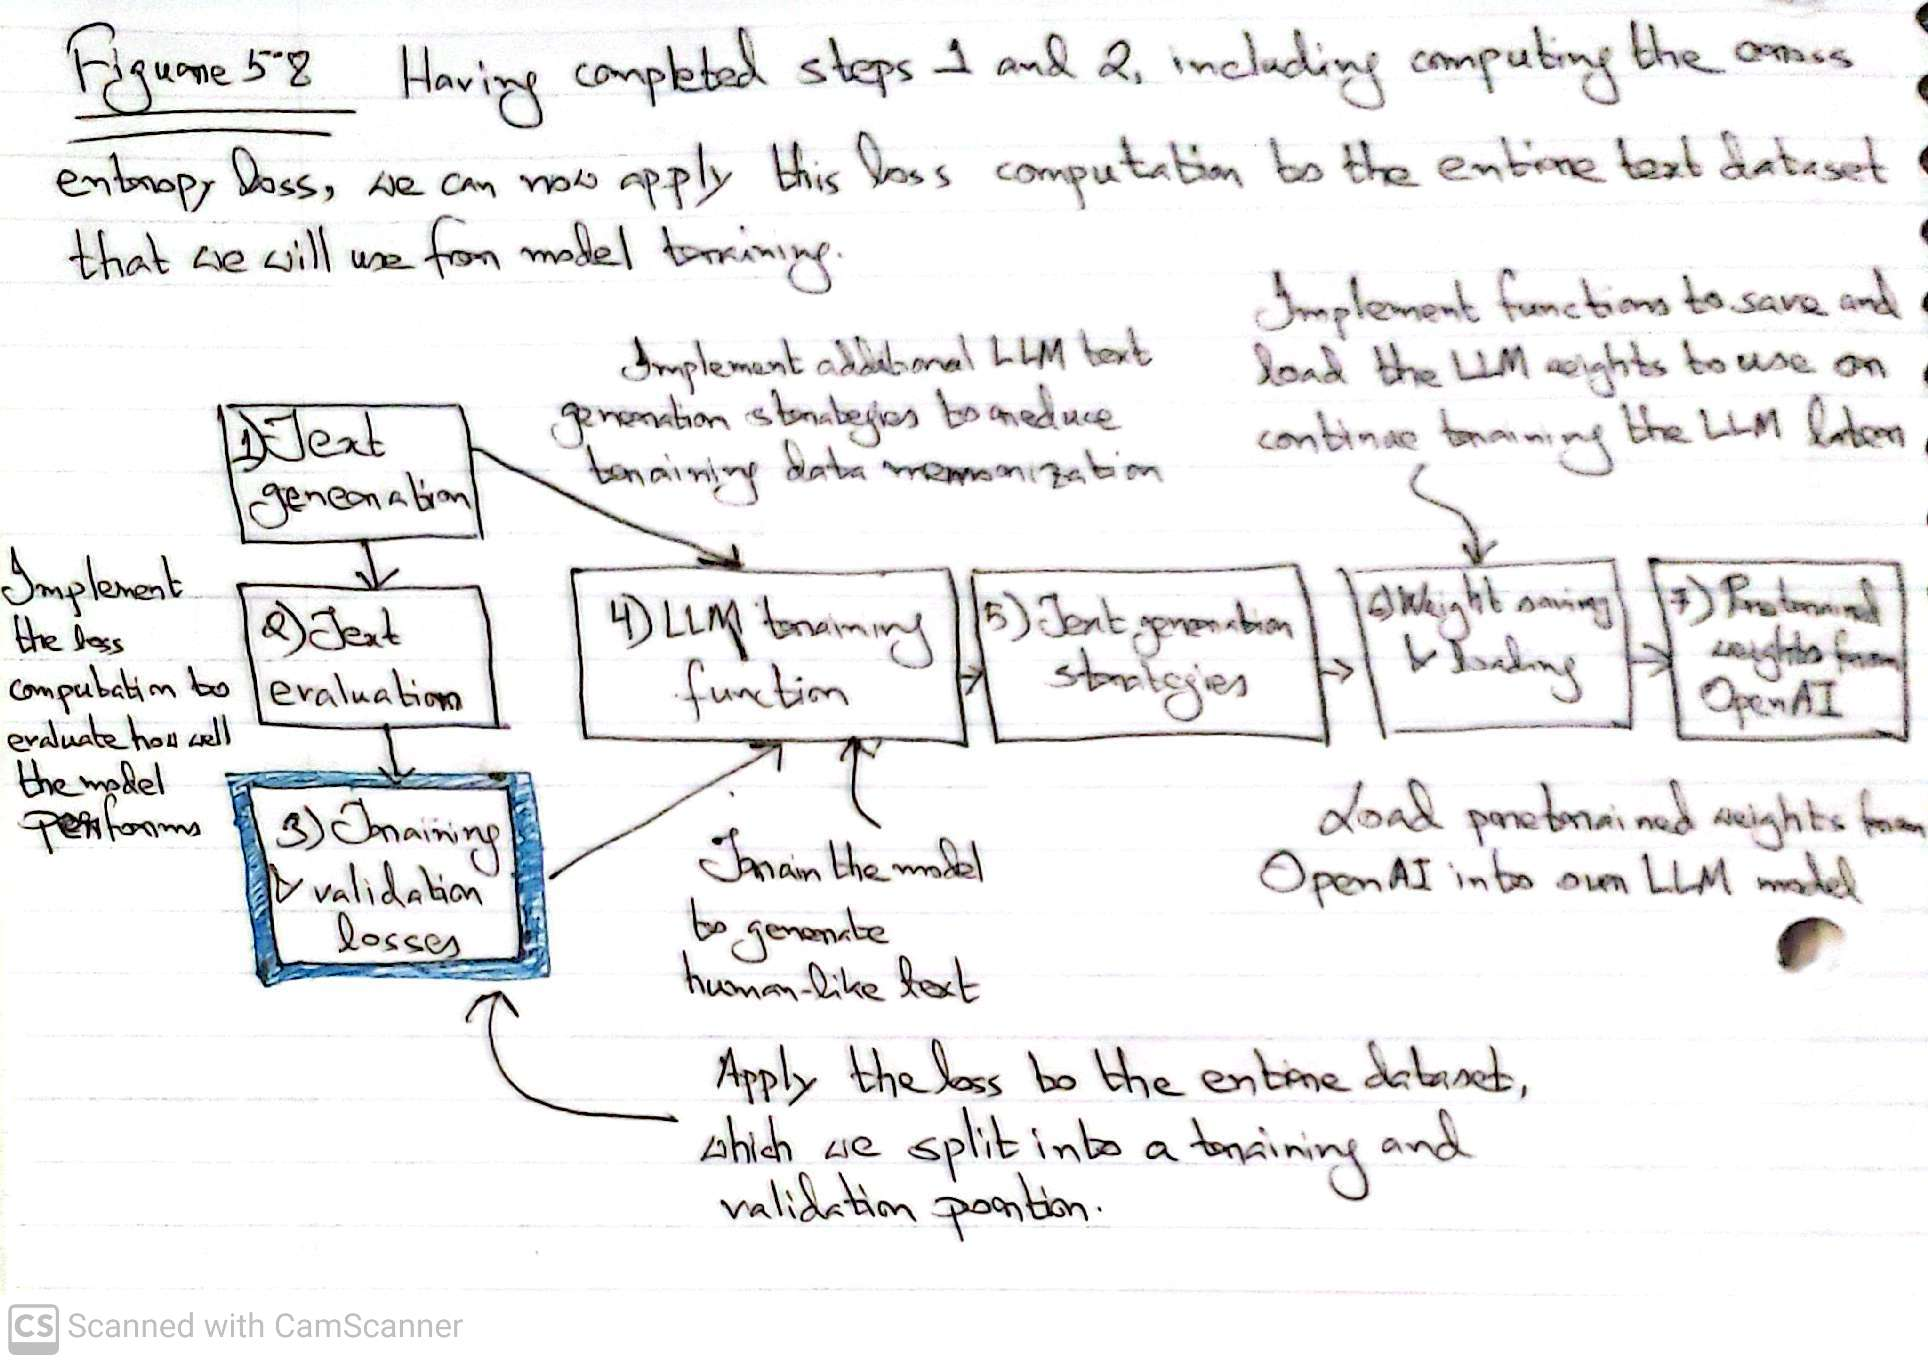

In [ ]:
display(Image(filename='5_8.jpg', width=800))

Now, we will use the text from "The Verdict" short story  by Edith Wharton that we already worked in chapter 2.

In [ ]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
  text_data = file.read()

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Now, we will split the dataset into training and validation datasets. We can see that this text has only 5145 tokens which is convenient to use for training locally. Here, we are going to use `max_length = 6`, but for the actual dataloaders, we will use `max_length = 256` so that our LLM can see longer texts.

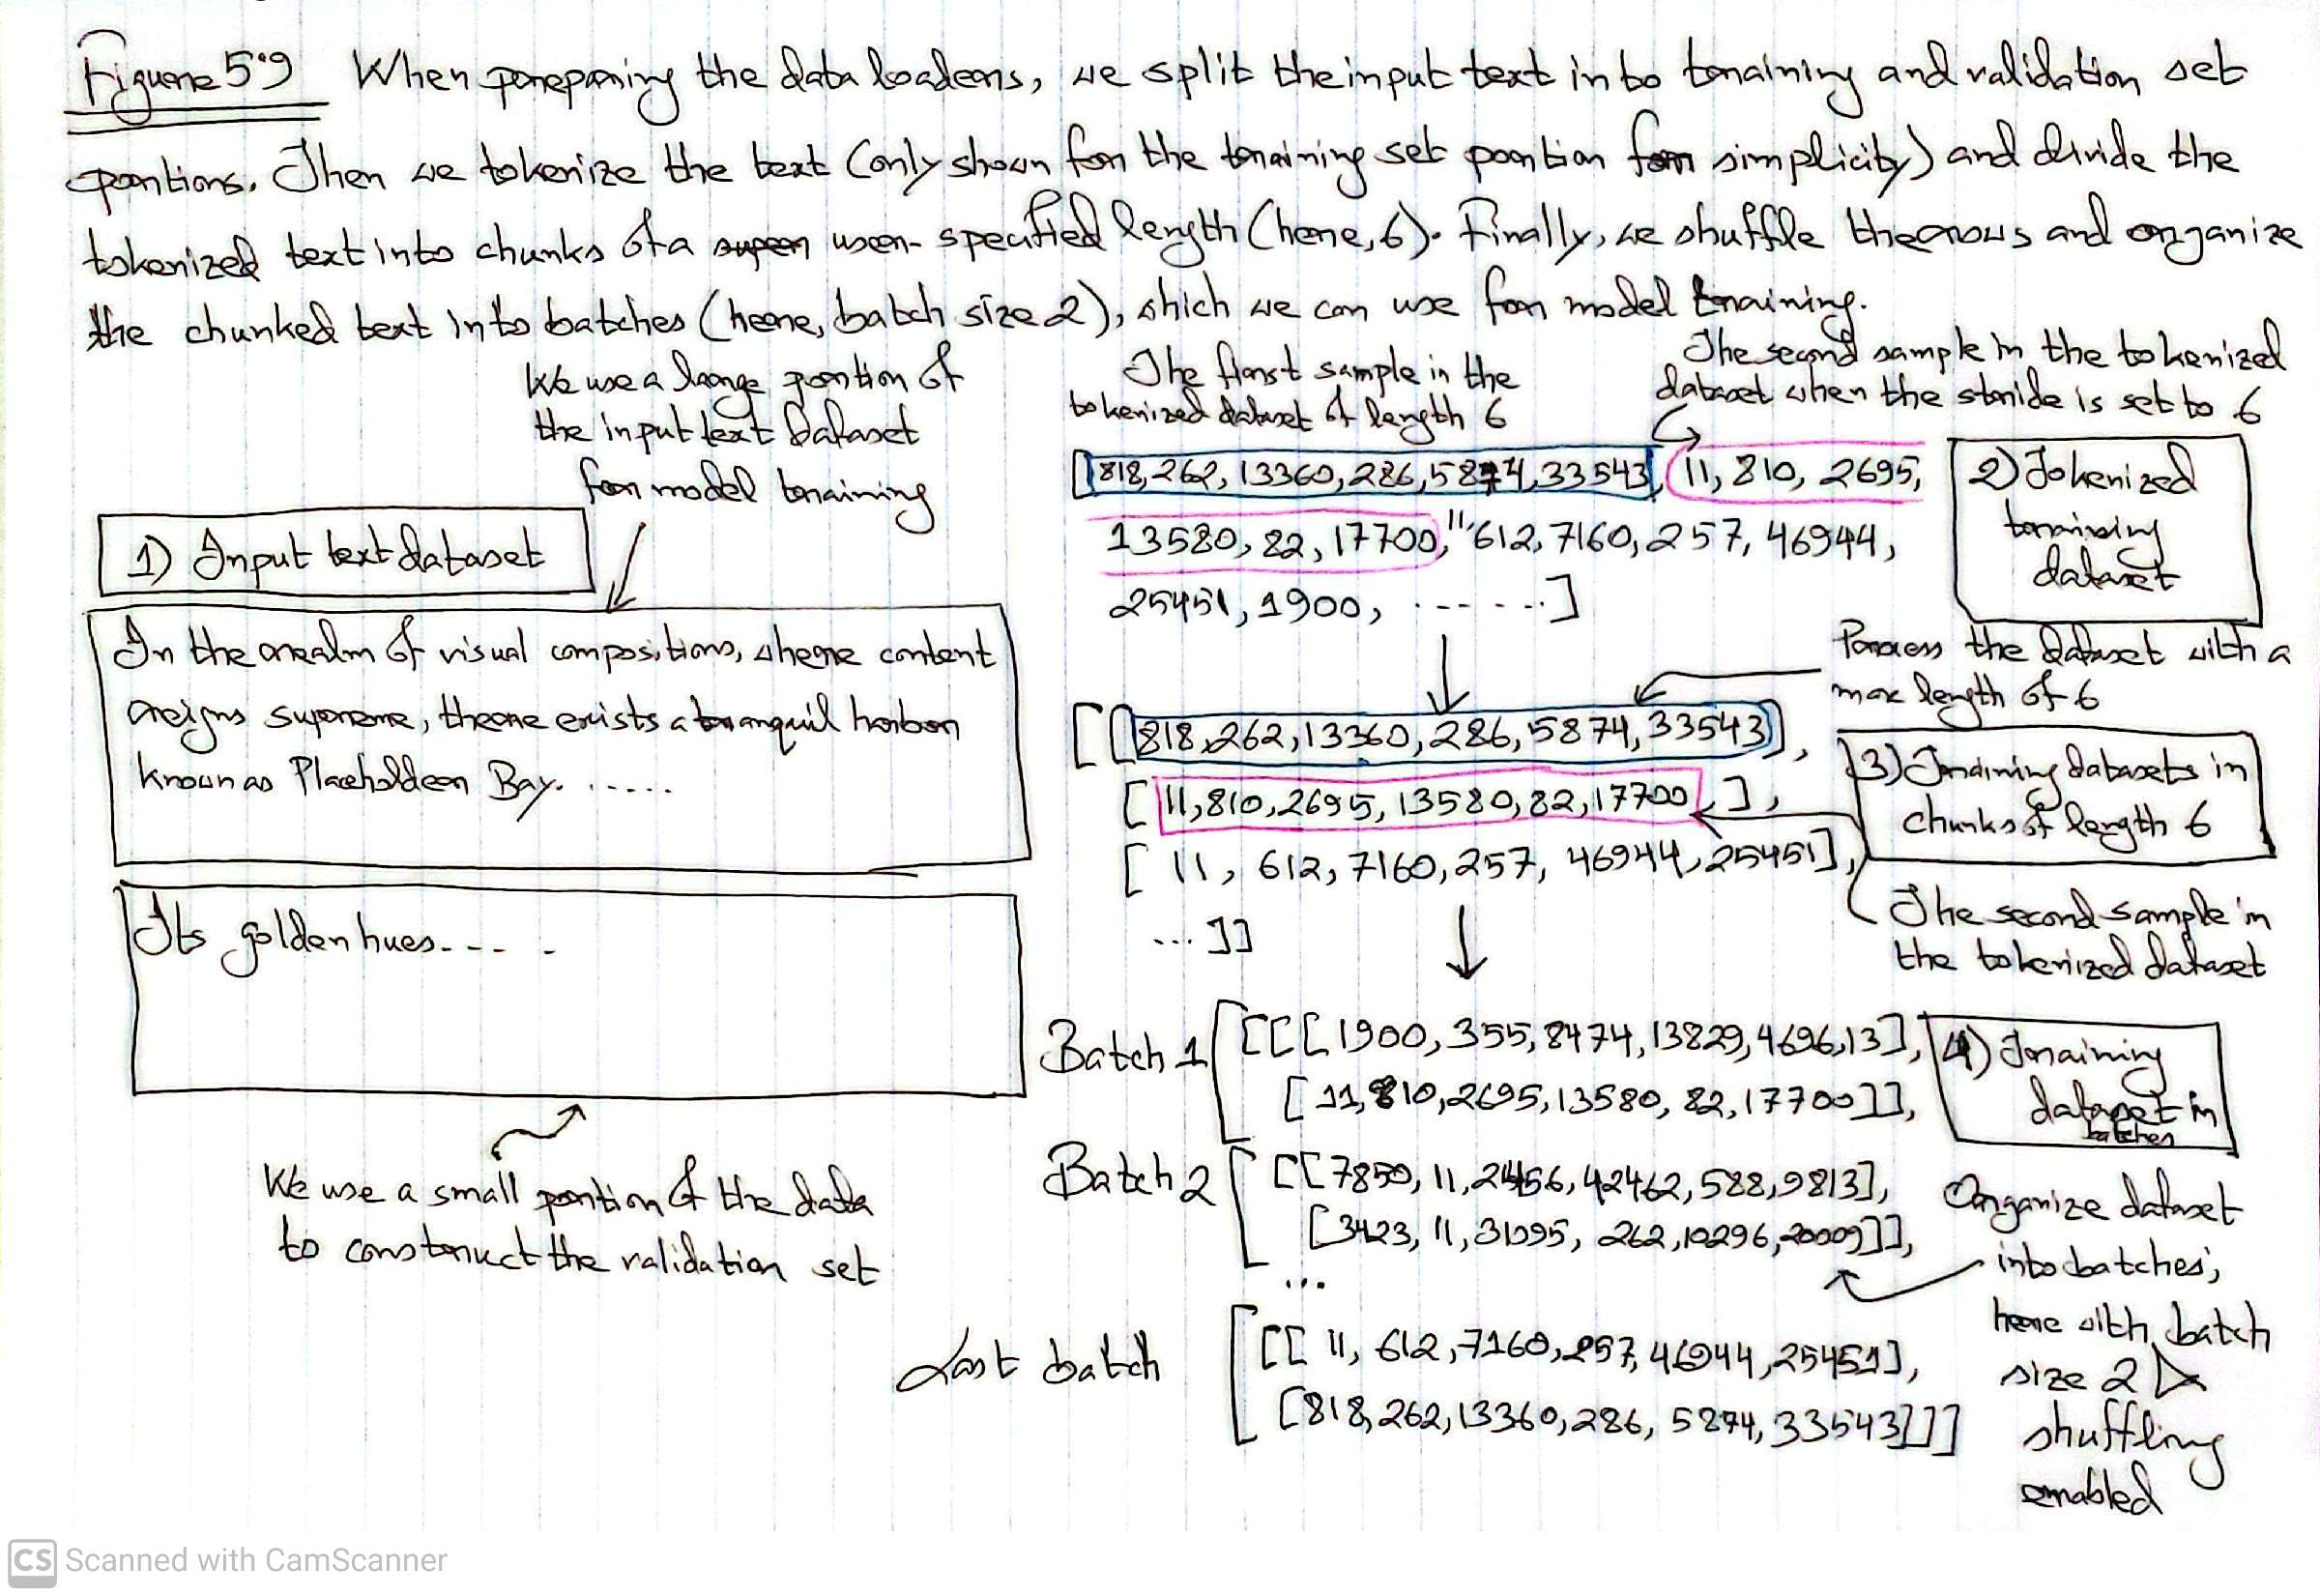

In [ ]:
display(Image(filename='5_9.jpg', width=800))

Now, we will get training data of 90% and validation data of the remaining 10% from the full data.

In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [ ]:
len(text_data)

20479

Now, load the `create_dataloader_V1` code we coded in Chapter 2.

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 256, # Context_length
    "emb_dim": 768, # Embedding dimension
    "n_layers": 12, # Number of transformer blocks
    "n_heads": 12, # Number of attention heads
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias -- determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key and value computations
}

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_V1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

Now, let's create the data loader using the `create_dataloader_V1` function.

In [ ]:
torch.manual_seed(123)

train_loader = create_dataloader_V1(
    train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"], drop_last=True,
    shuffle=True, num_workers=0
)

val_loader = create_dataloader_V1(
    val_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"], drop_last=True,
    shuffle=True, num_workers=0
)

In the code above, we have used a batch size of 2 so that we can run it inside our local computer and in practice, batch size of even 1024 is used.

The shuffle parameter in DataLoader controls whether the dataset samples are randomly shuffled before forming batches.

```python
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,  # If True, shuffle the order of the data
    drop_last=drop_last,
    num_workers=num_workers
)
```

## How Shuffling Works in This Case

Yes, `shuffle=True` will **change the order** of the training examples **between epochs**. But let's break down what is happening in this dataset.

### How the Data is Created

The dataset (`GPTDatasetV1`) **does not store full sentences**. Instead, it creates **fixed-length overlapping chunks** of tokenized text using a stride.

Let's assume we have this input text:

```
"The cat sat on the mat. The dog barked at the cat. The sun was shining brightly."
```

After tokenizing, suppose we get:

```ini
token_ids = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
```

If we use `max_length=5` and `stride=3`, the dataset would generate:

| Index | Input Chunk | Target Chunk |
|-------|-------------|--------------|
| 0 | [10, 20, 30, 40, 50] | [20, 30, 40, 50, 60] |
| 1 | [30, 40, 50, 60, 70] | [40, 50, 60, 70, 80] |
| 2 | [50, 60, 70, 80, 90] | [60, 70, 80, 90, 100] |
| 3 | [70, 80, 90, 100, 110] | [80, 90, 100, 110, 120] |

Each row is a **training example**, where:

• The **input** chunk is fed into the model.

• The **target** chunk is the correct next token sequence the model should predict.

## What Happens When `shuffle=True`?

If `shuffle=True`, these training examples **will be randomly reordered** each epoch.

If `shuffle=True`, these training examples **will be randomly reordered** each epoch.

For example:  

* **Epoch 1:** Training order → `[0, 1, 2, 3]`  
* **Epoch 2:** Training order → `[3, 1, 0, 2]`  
* **Epoch 3:** Training order → `[2, 3, 1, 0]`  

Even though the sentences in the original text *had an order*, the dataset has already **split them into overlapping chunks**. Each chunk contains enough context, so shuffling **does not break sentence structure**; it only changes the order in which the chunks are presented during training.

## Does This Affect Meaning?

No, because:

1. **The model is trained to learn patterns in smaller context windows** (not full documents).  
2. **Chunks still contain continuous sequences**, so they make sense on their own.  
3. **Shuffling only affects training order, not token order inside each chunk.**

## When Should You Avoid Shuffling?

* If your task requires **strict order** (e.g., summarization or text completion over long documents), shuffling might hurt performance.  
* For **validation/testing**, shuffling is usually disabled (`shuffle=False`) to keep results consistent.

## Summary

* Shuffling changes the order of training examples (chunks) **between epochs**, not within each chunk.  
* It **does not affect sentence structure** because chunks still preserve local continuity.  
* Shuffling helps prevent the model from memorizing the order of chunks and improves generalization.


### Original Dataset Creation
```python
# Original text: "The cat sat on the mat. The dog barked at the cat. The sun was shining brightly."
# After tokenization: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
# With max_length=5, stride=3:

dataset = [
    (input=[10, 20, 30, 40, 50], target=[20, 30, 40, 50, 60]),    # Training Example 0
    (input=[30, 40, 50, 60, 70], target=[40, 50, 60, 70, 80]),    # Training Example 1  
    (input=[50, 60, 70, 80, 90], target=[60, 70, 80, 90, 100]),   # Training Example 2
    (input=[70, 80, 90, 100, 110], target=[80, 90, 100, 110, 120]) # Training Example 3
]
```

### What Happens During Training

**Without Shuffling (`shuffle=False`):**
- **Epoch 1:** Examples presented in order: `0 → 1 → 2 → 3`
- **Epoch 2:** Examples presented in order: `0 → 1 → 2 → 3` (same order)
- **Epoch 3:** Examples presented in order: `0 → 1 → 2 → 3` (same order)

**With Shuffling (`shuffle=True`):**
- **Epoch 1:** Examples presented in order: `0 → 1 → 2 → 3` (or any random order)
- **Epoch 2:** Examples presented in order: `3 → 1 → 0 → 2` (different random order)
- **Epoch 3:** Examples presented in order: `2 → 0 → 3 → 1` (different random order)

### Critical Point: What Remains Unchanged

**❌ WRONG:** Shuffling changes token order within chunks
- Example 0 does NOT become: `[50, 10, 40, 20, 30]` ← This would break meaning!

**✅ CORRECT:** Shuffling only changes the order that complete examples are presented
- Example 0 always remains: `[10, 20, 30, 40, 50]` ← Token sequence stays intact
- Example 1 always remains: `[30, 40, 50, 60, 70]` ← Token sequence stays intact

### Concrete Training Flow Example

**Epoch 1 (Order: 0, 1, 2, 3):**
1. Model sees: input=`[10, 20, 30, 40, 50]`, target=`[20, 30, 40, 50, 60]`
2. Model sees: input=`[30, 40, 50, 60, 70]`, target=`[40, 50, 60, 70, 80]`
3. Model sees: input=`[50, 60, 70, 80, 90]`, target=`[60, 70, 80, 90, 100]`
4. Model sees: input=`[70, 80, 90, 100, 110]`, target=`[80, 90, 100, 110, 120]`

**Epoch 2 (Order: 3, 1, 0, 2):**
1. Model sees: input=`[70, 80, 90, 100, 110]`, target=`[80, 90, 100, 110, 120]` ← Same chunk content!
2. Model sees: input=`[30, 40, 50, 60, 70]`, target=`[40, 50, 60, 70, 80]` ← Same chunk content!
3. Model sees: input=`[10, 20, 30, 40, 50]`, target=`[20, 30, 40, 50, 60]` ← Same chunk content!
4. Model sees: input=`[50, 60, 70, 80, 90]`, target=`[60, 70, 80, 90, 100]` ← Same chunk content!

## Why This Doesn't Break Token Order

Each training example is a **complete, meaningful sequence** extracted from the original text:

1. **Token relationships within each chunk are preserved** - `[10, 20, 30, 40, 50]` always appears in this exact order
2. **Grammar and context remain intact** within each chunk
3. **Only the presentation order of complete examples changes** between epochs

## Analogy
Think of it like shuffling a playlist of songs:
- 🎵 **Song 1:** "Yesterday, all my troubles seemed so far away..." (lyrics stay in order)
- 🎵 **Song 2:** "Is this the real life, is this just fantasy..." (lyrics stay in order)
- 🎵 **Song 3:** "Hello, is it me you're looking for..." (lyrics stay in order)

**Shuffling the playlist** means Song 2 might play before Song 1, but the **lyrics within each song** remain in their correct order. You're not scrambling words within songs!

## Summary
- ✅ **Shuffling changes:** The order that training examples are presented to the model
- ❌ **Shuffling does NOT change:** The token sequence within each individual training example
- 🎯 **Result:** Model sees the same meaningful chunks but in different orders across epochs, which improves generalization

Let's have a look at the data loader.

In [ ]:
print("Train loader:")
for x,y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


So there are nine training set batches with two samples and 256 tokens each. There is only one validation batch consisting of two samples.

### **Why do we have 9 training batches here?**

## Step 1: Understanding the Dataset Size

Your dataset is loaded from `"the-verdict.txt"`, which has:

* **Total characters:** 20,479  
* **Total tokens:** 5,145 (after tokenization)

Since tokenization can map multiple characters to a single token, we end up with **5,145 tokens**.

---

## Step 2: How the Data Is Split

You set:

```python
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data  = text_data[split_idx:]
```

This means:

* **Training text:** 90 % of `20,479` characters ≈ **18,431** characters.  
* **Validation text:** Remaining 10 % ≈ **2,048** characters.

Since the **number of tokens** is much smaller than characters, let’s calculate the number of training tokens:

* `train_tokens = tokenizer.encode(train_data)` results in **≈ 90 % of 5,145 tokens**, which is **≈ 4,630** tokens.

---

## Step 3: How the Dataset Creates Chunks

The dataset splits text into **overlapping chunks** with:

```python
max_length = 256
stride     = 256
```


This means:

• Each training **example** is **256 tokens** long.

• Since **stride = 256**, there is **no overlap** between examples.

• It slides forward **256 tokens** at a time.

Now, the number of training samples is:

$$\frac{\text{total training tokens}}{\text{max length}} = \frac{4630}{256} \approx 18 \text{ samples}$$

Thus, we have **18 training samples of length 256 tokens each**.

---

# Step 4: Why 9 Training Batches?

You set:

```python
batch_size = 2
drop_last = True
```

• Since there are **18 samples** and the **batch size is 2**, the total number of batches is:

$$\frac{18}{2} = 9$$

• The `drop_last=True` option ensures that if there is an incomplete batch at the end (e.g., 1 leftover sample), it is discarded.

## Final Answer

We have **9 training batches** because:

1. The training data contains **4,630 tokens** (after splitting text).

2. Each training sample contains **256 tokens**.

3. This results in **18 training samples**.

4. Since the batch size is **2**, we get **9 batches**.

5. `drop_last=True` prevents incomplete batches.

Calculate the **cross entropy loss of a batch**.

Now, we will write a function to calculate the cross entropy loss of a given batch using the training and validation loader.

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

Now, write a function to calculate **loss over all the batches**.

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if(len(data_loader) == 0):
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

Now, use `calc_loss_loader` to calculate the training and validation loss.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)
print("Train loss:", train_loss)
print("Validation loss:", val_loss)

Train loss: 10.987583584255642
Validation loss: 10.981106758117676


The loss value is relatively high due to the model not beign trained yet. So we need to train, after which the model loss will come close to 0 as training the model will learn to generate correct next tokens.

As we already have a way to calculate the quality of the generated text, now we can train the LLM to reduce the loss, so that it becomes better at generating text.

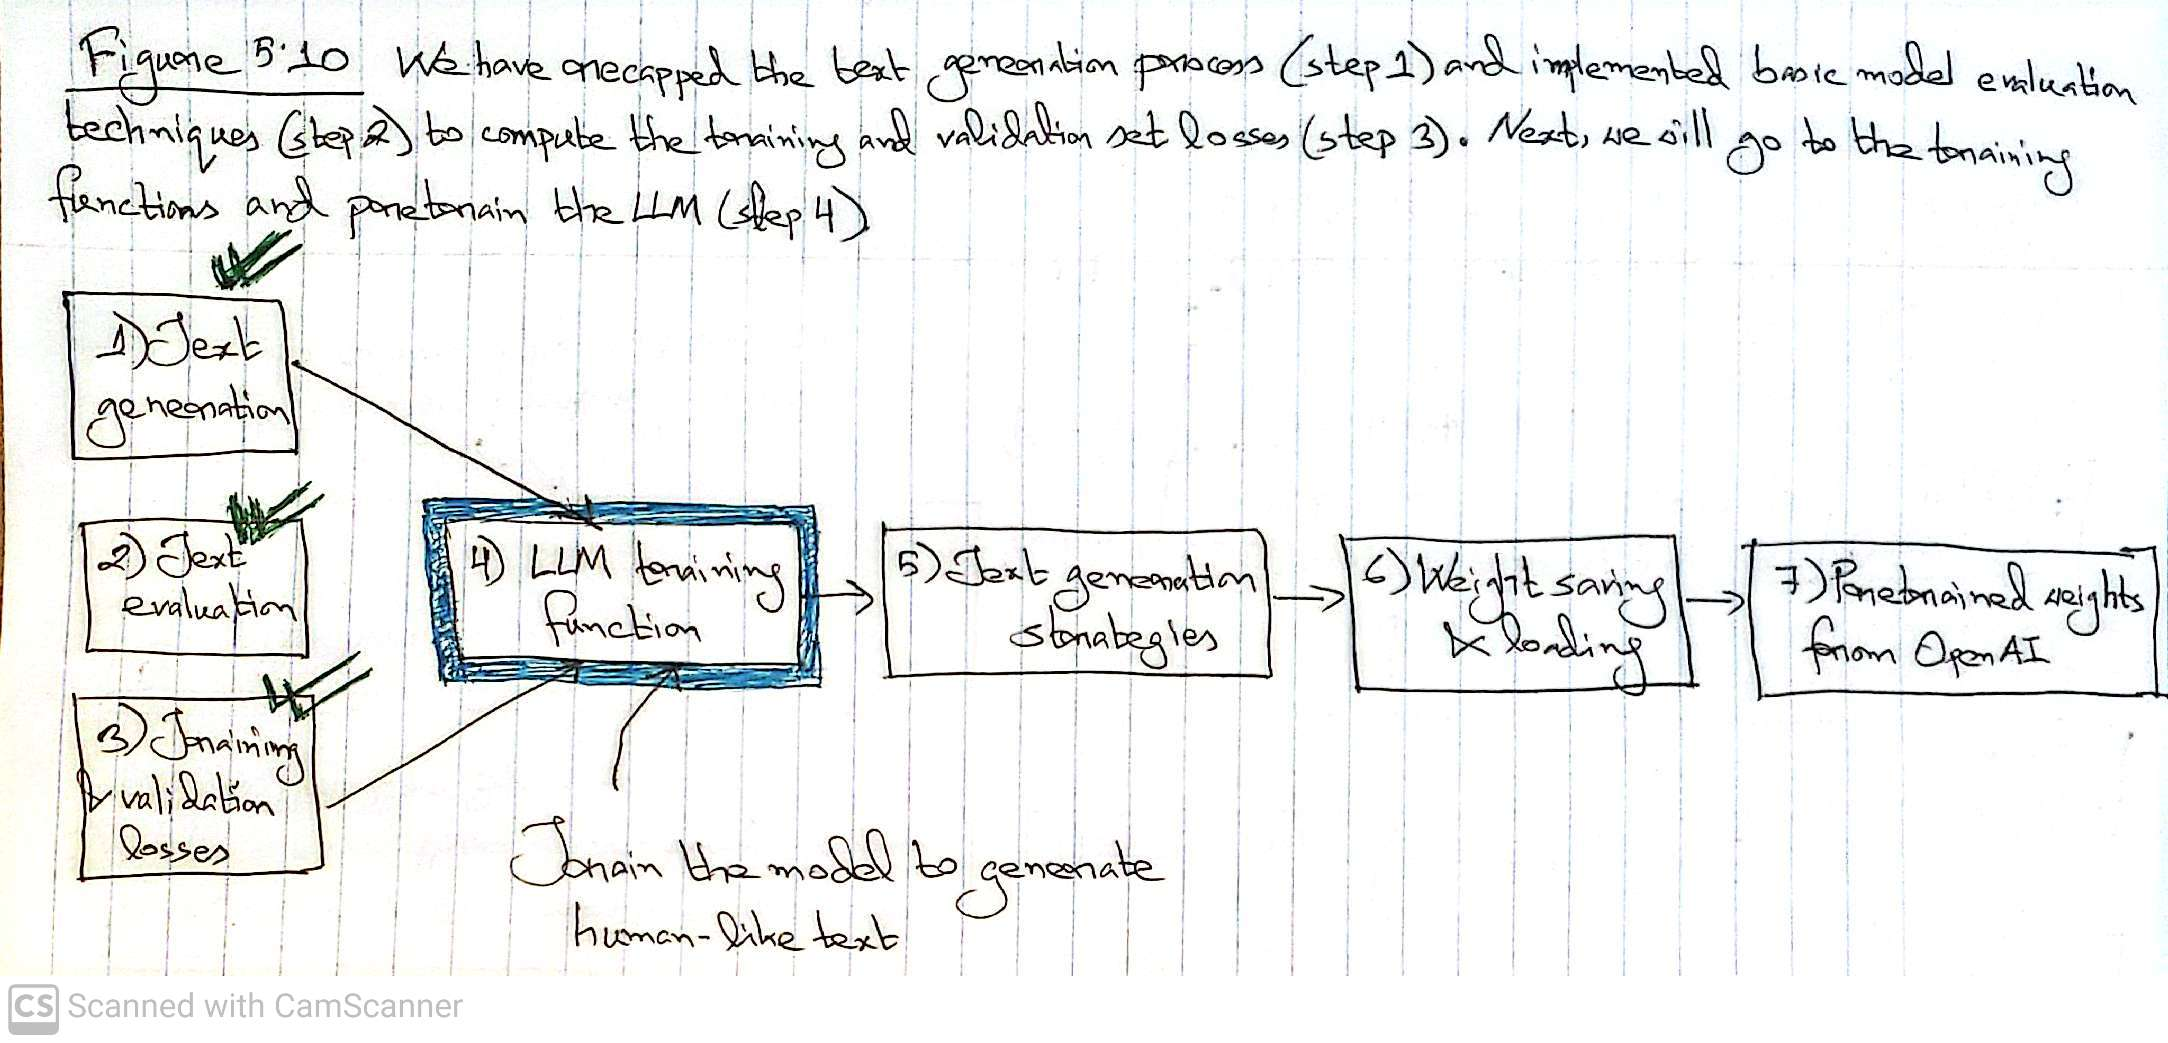

In [ ]:
display(Image(filename='5_10.jpg', width=800))

## **Training an LLM**

Now, we will train our LLM. Below is a eigh-step workflow in PyTorch for training LLM: iterate over each epoch, process batches, reset gradients, calculate loss and new gradients, update model weights and monitor steps by printing losses and generating text samples.

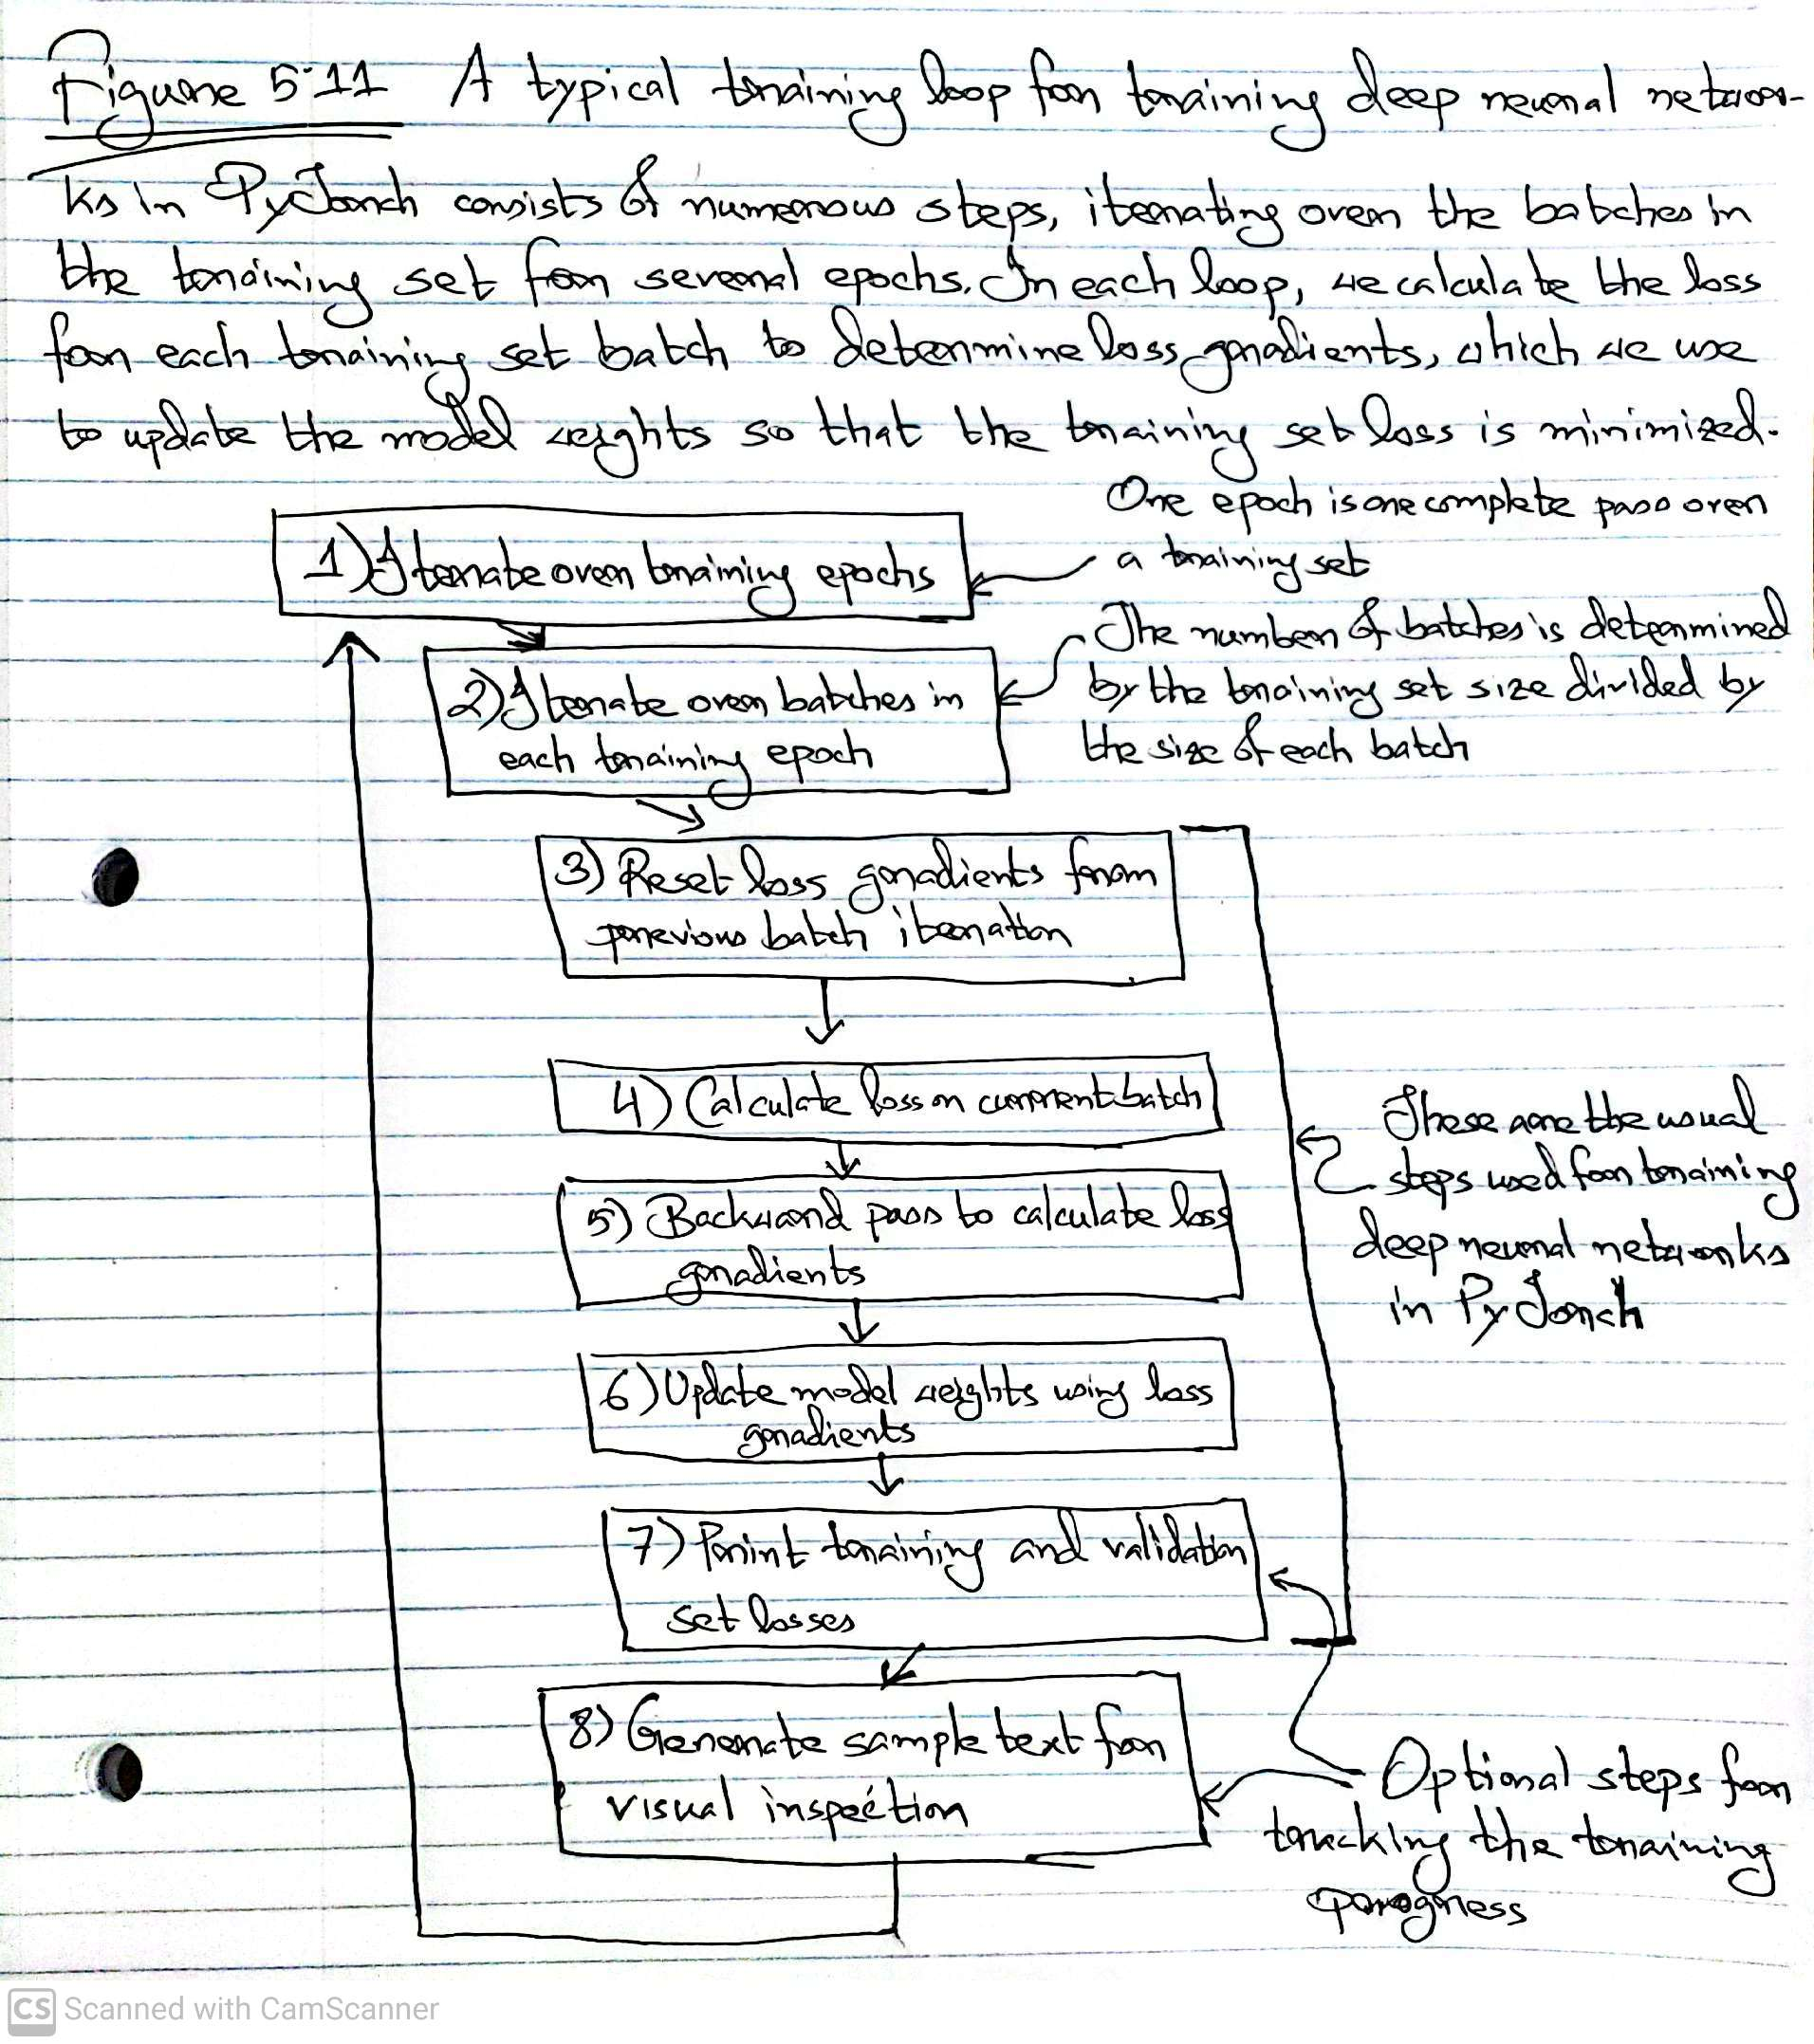

In [ ]:
display(Image(filename='5_11.jpg', width=800))

In [ ]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    """
    Trains the GPT model over a specified number of epochs, periodically evaluating its performance
    on training and validation datasets, and generating sample text after each epoch.

    Parameters:
    - model: The GPT model instance to be trained.
    - train_loader: DataLoader providing batches of training data.
    - val_loader: DataLoader providing batches of validation data.
    - optimizer: Optimization algorithm (e.g., Adam) for updating model parameters.
    - device: The computation device (CPU or GPU) where training occurs.
    - num_epochs: Total number of epochs to train the model.
    - eval_freq: Frequency (in global steps) at which to evaluate the model.
    - eval_iter: Number of batches to use during each evaluation.
    - start_context: Initial context (seed text) for generating sample text.
    - tokenizer: Tokenizer for converting text to token IDs and vice versa.

    Returns:
    - train_losses: List of training loss values recorded at each evaluation step.
    - val_losses: List of validation loss values recorded at each evaluation step.
    - track_tokens_seen: List tracking the number of tokens processed at each evaluation step.
    """

    # Initialize lists to store loss values and tokens processed for tracking and analysis
    train_losses, val_losses, track_tokens_seen = [], [], []

    # Initialize counters:
    # - tokens_seen: Total number of tokens processed during training
    # - global_step: Total number of training steps (batches processed)
    tokens_seen, global_step = 0, -1

    # Outer loop: Iterate over each epoch
    for epoch in range(num_epochs):
        # Set the model to training mode.
        # This enables layers like Dropout and BatchNorm to behave appropriately during training.
        model.train()

        # Inner loop: Iterate over each batch in the training DataLoader
        for input_batch, target_batch in train_loader:
            # Reset gradients from the previous step to prevent accumulation
            optimizer.zero_grad()

            # Compute the loss for the current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # Perform backpropagation to compute gradients of the loss w.r.t. model parameters
            loss.backward()

            # Update the model's parameters based on the computed gradients
            optimizer.step()

            # Update the total number of tokens processed
            # input_batch.numel() returns the total number of elements (tokens) in the batch
            tokens_seen += input_batch.numel()

            # Increment the global step counter by one
            # This tracks the total number of batches processed across all epochs
            global_step += 1

            # Check if it's time to evaluate the model based on eval_freq
            if global_step % eval_freq == 0:
                # Evaluate the model's performance on training and validation datasets
                # evaluate_model is assumed to compute average losses over eval_iter batches
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)

                # Append the latest loss values and tokens processed to their respective tracking lists
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                # Print the current epoch, global step, and corresponding loss values
                # Using f-strings for formatted and readable output
                # - {epoch+1}: Displays the current epoch number (starting from 1 instead of 0)
                # - {global_step:06d}: Displays global_step as a zero-padded 6-digit integer
                # - {train_loss:.3f}, {val_loss:.3f}: Displays loss values rounded to three decimal places
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # After completing all batches in the current epoch, generate and print a sample of text
        # This provides a qualitative assessment of the model's generative capabilities
        # generate_and_print_sample is assumed to handle text generation based on start_context
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    # After training completes, return the collected loss metrics and tokens processed
    return train_losses, val_losses, track_tokens_seen


# Complete Training Process Breakdown

## Outer Loop: Epochs
```python
for epoch in range(num_epochs):  # e.g., 10 epochs
```
An epoch means the model has seen every single example in your training dataset once. If you have 1000 training examples, after 1 epoch, all 1000 have been processed.

## Setting Training Mode
```python
model.train()
```
This puts the model in training mode, enabling things like dropout and batch normalization to work properly during training.

## Inner Loop: Processing Batches
```python
for input_batch, target_batch in train_loader:
```
Your training data is divided into batches. If you have 1000 examples and batch size is 32, you'll have ~31 batches per epoch.

---

# What Happens For Each Single Batch:

## Step 1: Clear Previous Gradients
```python
optimizer.zero_grad()
```
**Why needed:** Gradients accumulate by default in PyTorch. Without this, gradients from previous batches would add up, which we don't want.

## Step 2: Forward Pass
```python
loss = calc_loss_batch(input_batch, target_batch, model, device)
```
**What happens internally:**

- Input batch (e.g., 32 sequences) enters the first layer
- **Layer 1**: Embedding layer converts tokens to vectors
- **Layer 2-N**: Each transformer block processes the data
  - Self-attention: Tokens look at each other
  - Feed-forward: Non-linear transformations
  - Residual connections and normalization
- **Output layer**: Produces probability distributions over vocabulary
- **Loss calculation**: Compare predictions vs actual next tokens

**Result:** A single loss number representing how wrong the model was on this batch.

## Step 3: Backward Pass (Backpropagation)
```python
loss.backward()
```
**This is where the magic happens:**

**Starting from the loss (one number), PyTorch calculates:**
- How much did each parameter in the output layer contribute to this loss?
- How much did each parameter in the last transformer block contribute?
- Working backward through every single layer...
- All the way back to the embedding layer parameters

**Result:** Every parameter now has a gradient (a number indicating how to adjust it).

**Example gradients calculated:**
```python
embedding_layer.weight.grad = [gradient values for all embedding weights]
transformer_block_1.attention.weight.grad = [gradient values]
transformer_block_1.ffn.weight.grad = [gradient values]
...
transformer_block_N.attention.weight.grad = [gradient values]
output_layer.weight.grad = [gradient values]
```

## Step 4: Update All Parameters
```python
optimizer.step()
```
**For every single parameter in the model:**
```python
# Simplified version of what happens:
parameter = parameter - learning_rate * parameter.gradient
```

**This means:**
- All embedding weights get updated
- All attention weights in all transformer blocks get updated  
- All feed-forward weights in all transformer blocks get updated
- All bias terms get updated
- Output layer weights get updated

**Result:** The model is now slightly different than it was before processing this batch.

---

# Tracking Progress

## Token Counting
```python
tokens_seen += input_batch.numel()
global_step += 1
```
- Keeps track of how many tokens the model has seen total
- Increments the step counter (each batch = one step)

## Periodic Evaluation
```python
if global_step % eval_freq == 0:
    train_loss, val_loss = evaluate_model(...)
```
**Every `eval_freq` batches** (not epochs), the code:

- Pauses training
- Tests current model on training and validation data
- Records the losses for plotting later
- Prints progress information

---

# End of Epoch Activities
```python
generate_and_print_sample(model, tokenizer, device, start_context)
```
After processing all batches in an epoch:

- Generate sample text to see how the model is doing
- Start the next epoch with the updated model

---

# Key Insights

## Frequency of Updates

- **Parameters updated:** After every single batch
- **Progress evaluated:** Every `eval_freq` batches  
- **Sample generated:** After every epoch

## Scale of Impact
If you have:

- 1000 training examples
- Batch size of 32
- 3 epochs

Then:

- **Total batches:** ~94 batches (31 per epoch × 3 epochs)
- **Parameter updates:** 94 times (once per batch)
- **All parameters updated:** 94 times each

## Why This Works

- **Incremental learning:** Model improves gradually with each batch
- **Efficient:** Don't need to see all data before making improvements
- **Stable:** Small updates prevent dramatic changes that could hurt performance

This batch-by-batch update process is what allows neural networks to learn effectively from large datasets - the model is constantly adapting and improving as it sees more examples.

# The Problem: Gradient Accumulation

In PyTorch, when you call `loss.backward()`, the gradients **don't replace** the existing gradients - they **add to** whatever gradients are already stored.

## Example Without `optimizer.zero_grad()`

Let's say you have a simple weight with value `w = 5.0`:

### Batch 1:
```python
# loss.backward() calculates: this weight should decrease by 0.1
w.grad = 0.1  # First time, starts from None, so becomes 0.1
```

### Batch 2:
```python
# loss.backward() calculates: this weight should decrease by 0.2  
w.grad = 0.1 + 0.2 = 0.3  # ADDS to previous gradient!
```

### Batch 3:
```python
# loss.backward() calculates: this weight should decrease by 0.15
w.grad = 0.3 + 0.15 = 0.45  # ADDS again!
```

### When optimizer.step() runs:
```python
w = w - learning_rate * w.grad
w = 5.0 - 0.01 * 0.45 = 4.9955
```

## What's Wrong Here?

The weight was updated using a gradient of `0.45`, but:
- Batch 1 wanted to update by `0.1`
- Batch 2 wanted to update by `0.2`
- Batch 3 wanted to update by `0.15`

**We accidentally used the sum** `0.45` instead of just the most recent gradient `0.15`!

---

# The Solution: Clear Gradients

## Example WITH `optimizer.zero_grad()`

### Batch 1:
```python
optimizer.zero_grad()  # w.grad = 0.0 (or None)
# loss.backward()
w.grad = 0.1
# optimizer.step(): w = 5.0 - 0.01 * 0.1 = 4.999
```

### Batch 2:
```python
optimizer.zero_grad()  # w.grad = 0.0 (CLEARED!)
# loss.backward()
w.grad = 0.2  # Only this batch's gradient
# optimizer.step(): w = 4.999 - 0.01 * 0.2 = 4.997
```

### Batch 3:
```python
optimizer.zero_grad()  # w.grad = 0.0 (CLEARED!)
# loss.backward()
w.grad = 0.15  # Only this batch's gradient  
# optimizer.step(): w = 4.997 - 0.01 * 0.15 = 4.99565
```

---

# Why This Matters

## Without Clearing (Wrong):
- Weight updates become larger and larger over time
- Later batches have disproportionately large impact
- Training becomes unstable
- Model might diverge or learn poorly

## With Clearing (Correct):
- Each batch contributes equally to learning
- Updates are consistent and predictable
- Training is stable

---

# Real-World Analogy

Think of gradients like **voting ballots**:

## Without `zero_grad()`:
- Batch 1 votes: "Move left 1 step"
- Batch 2 votes: "Move left 2 steps"
- But the ballot box **keeps both votes**
- Final decision: "Move left 3 steps" (wrong!)

## With `zero_grad()`:
- Batch 1 votes: "Move left 1 step" → Move left 1 step
- **Clear the ballot box**
- Batch 2 votes: "Move left 2 steps" → Move left 2 steps  
- Each vote is counted independently (correct!)

---

# The Bottom Line

`optimizer.zero_grad()` ensures that each batch gets a **fresh start** for computing gradients. Without it, your model would be using accumulated gradients from all previous batches, which would make training unstable and incorrect.

This is why it's the very first thing you do in every training loop iteration!

Now, we want to write the `evaluate_model` function corresponding to step 7 in figure 5.11. It returns the training and validation losses. We do this with gradient checking and dropout disabled using `torch.no_grad()`.

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Evaluates the GPT model's performance on both training and validation datasets.
    This function calculates the average loss over a specified number of batches for both datasets.

    Parameters:
    - model: The GPT model instance to be evaluated.
    - train_loader: DataLoader providing batches of training data.
    - val_loader: DataLoader providing batches of validation data.
    - device: The computation device (CPU or GPU) where evaluation occurs.
    - eval_iter: Number of batches to use during evaluation for each dataset. eval_iter controls how many batches are used during evaluation.

    Returns:
    - train_loss: Average loss computed over the specified number of training batches.
    - val_loss: Average loss computed over the specified number of validation batches.
    """

    # Set the model to evaluation mode.
    # This is crucial because certain layers like Dropout and BatchNorm behave differently during evaluation.
    # - Dropout layers are disabled, meaning no neurons are randomly dropped.
    # - BatchNorm layers use running statistics instead of batch statistics.
    model.eval()

    # Disable gradient calculations.
    # This is important for evaluation because:
    # - It reduces memory consumption since gradients are not stored.
    # - It speeds up computations as gradient calculations are skipped.
    # - It ensures that the evaluation process does not interfere with the training process.
    with torch.no_grad():
        # Calculate the average loss on the training dataset.
        # - `calc_loss_loader` iterates over a specified number of batches (`eval_iter`)
        #   from the `train_loader`, computes the loss for each batch, and returns the average loss.
        # - `num_batches=eval_iter` ensures that only a subset of the data is used for evaluation,
        #   which can be useful for faster evaluations or when dealing with very large datasets.
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        # Similarly, calculate the average loss on the validation dataset.
        # - This helps in assessing how well the model generalizes to unseen data.
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )

    # After evaluation, set the model back to training mode.
    # This is necessary to ensure that the model continues training with the correct behaviors.
    # Without this, the model would remain in evaluation mode, affecting subsequent training steps.
    model.train()

    # Return the computed average losses for both training and validation datasets.
    return train_loss, val_loss

Now, we also write the function `generate_and_print_sample` that takes text input, converts it into token IDs, and feed it to LLM to generate text.

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    Generates a sample text using the GPT model based on a provided start context and prints it.

    Parameters:
    - model: The GPT model instance used for text generation.
    - tokenizer: Tokenizer for converting text to token IDs and vice versa.
    - device: The computation device (CPU or GPU) where generation occurs.
    - start_context: Initial context (seed text) to start the text generation.

    Returns:
    - None
    """

    # Set the model to evaluation mode.
    # This is crucial because certain layers like Dropout and BatchNorm behave differently during evaluation.
    # - Dropout layers are disabled, meaning no neurons are randomly dropped.
    # - BatchNorm layers use running statistics instead of batch statistics.
    model.eval()

    # Determine the context size from the model's positional embeddings.
    # This context size defines how many tokens the model can consider for generating new tokens.
    # - `model.pos_emb.weight.shape[0]` retrieves the first dimension of the positional embedding weights,
    #   which typically corresponds to the maximum context length the model can handle.
    context_size = model.pos_emb.weight.shape[0]

    # Convert the start_context text into token IDs using the tokenizer.
    # This encoding process transforms human-readable text into numerical representations that the model can process.
    # - `text_to_token_ids` is a function that takes raw text and a tokenizer to produce a tensor of token IDs.
    # - `.to(device)` moves the tensor to the specified computation device (CPU or GPU) for efficient processing.
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    # Disable gradient calculations to save memory and computations during text generation.
    # Since we're only generating text and not training the model, gradients are unnecessary.
    # - `torch.no_grad()` is a context manager that temporarily sets all the `requires_grad` flags to `False`.
    # - This ensures that no intermediate activations are stored for backpropagation, making the process more efficient.
    with torch.no_grad():
        # Generate text using the model based on the encoded start context.
        # - `generate_text_simple` is a function that handles the text generation logic.
        # - Parameters:
        #   - `model`: The GPT model used for generating text.
        #   - `idx`: The encoded start context tensor.
        #   - `max_new_tokens=50`: Specifies the maximum number of new tokens to generate.
        #   - `context_size=context_size`: Provides the model with the context window size.
        # - Returns:
        #   - `token_ids`: A tensor containing the token IDs of the generated text.
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )

    # Decode the generated token IDs back into human-readable text.
    # This decoding process transforms the numerical token IDs into actual words and sentences.
    # - `token_ids_to_text` is a function that takes token IDs and a tokenizer to produce readable text.
    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Replace newline characters with spaces to format the generated text as a single paragraph.
    # - `decoded_text.replace("\n", " ")` searches for all newline characters (`\n`) in the text and replaces them with a space.
    # - This ensures that the printed sample is a continuous block of text without abrupt line breaks.
    formatted_text = decoded_text.replace("\n", " ")

    # Print the formatted generated text to the console.
    # - Using the `print` function allows you to see the model's output directly.
    # - This is useful for qualitatively assessing the coherence and relevance of the generated text.
    print(formatted_text)

    # After generation, set the model back to training mode.
    # This is important if you plan to continue training the model after generating samples.
    # - `model.train()` re-enables training-specific behaviors like Dropout and BatchNorm.
    # - Ensures that subsequent training steps operate correctly.
    model.train()

Train a GPTModel for 10 epochs using AdamW optimizer.

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device,
                                                           num_epochs=num_epochs, eval_freq=5, eval_iter=5, # eval_iter controls how many batches are used during evaluation.
                                                           start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 8.050, Val loss 8.333
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.758, Val loss 7.046
Ep 2 (Step 000015): Train loss 6.142, Val loss 6.630
Every effort moves you, and, and, and, and, and, and, and.                                   
Ep 3 (Step 000020): Train loss 13.925, Val loss 14.195
Ep 3 (Step 000025): Train loss 5.513, Val loss 6.420
Every effort moves you, and to the"                                             
Ep 4 (Step 000030): Train loss 5.165, Val loss 6.381
Ep 4 (Step 000035): Train loss 4.753, Val loss 6.316
Every effort moves you.                           "I"I"I"I it's"I"I"I"I"I"I
Ep 5 (Step 000040): Train loss 4.627, Val loss 6.394
Every effort moves you, I had been.                       "II me, and he had the donkey.           
Ep 6 (Step 000045): Train loss 4.026, Val loss 6.260
Ep 6 (Step 000050): Train loss 3.541, Val lo

We can see that initially after the first epoch, it was generating only commas (`Every effort moves you,,,,,,,,,,,,.`) and the training loss (`8.05` for the last batch in the first epoch) and validation loss (`8.33`  for the last batch in the first epoch) is high. As more iterations are going, it is generating more and more meaningful words. At the end, we can see that although the training loss is less than 1 (`0.885`) but the validation loss is high (`6.284`).

### **Training loss vs validation loss plot**

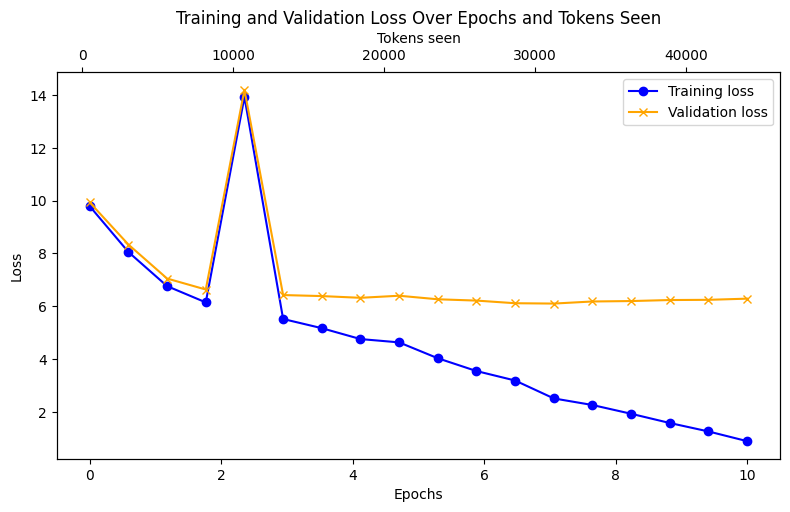

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    """
    Plots the training and validation losses against epochs and tokens seen.
    Displays two x-axes: one for epochs and another for tokens processed.

    Parameters:
    - epochs_seen: Iterable containing the epoch numbers corresponding to each recorded loss.
    - tokens_seen: Iterable containing the cumulative number of tokens processed at each evaluation step.
    - train_losses: List of training loss values recorded at each evaluation step.
    - val_losses: List of validation loss values recorded at each evaluation step.

    Returns:
    - None: Displays the plot.
    """
    fig, ax1 = plt.subplots(figsize=(8, 5))  # Create a figure and a primary Axes

    # Plot training losses against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss", color='blue', marker='o')
    # Plot validation losses against epochs
    ax1.plot(epochs_seen, val_losses, label="Validation loss", color='orange', marker='x')

    ax1.set_xlabel("Epochs")  # Label for the primary x-axis
    ax1.set_ylabel("Loss")     # Label for the y-axis
    ax1.legend(loc="upper right")  # Display legend in the upper right corner

    # Ensure x-axis ticks are integers (epochs are whole numbers)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Create a secondary x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a twin Axes sharing the y-axis

    # Plot tokens seen vs. training loss on the secondary x-axis
    # This is invisible -- used just to put the tokens_seen on the x-axis at the top
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible line for alignment

    ax2.set_xlabel("Tokens seen")  # Label for the secondary x-axis

    fig.tight_layout()  # Adjust layout to prevent overlapping labels and titles
    plt.title("Training and Validation Loss Over Epochs and Tokens Seen")  # Add a title
    plt.show()  # Display the plot

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

We see that training loss continues to decrease while validation loss doesn't.

##  **Text generation strategies for LLMs to reduce training data memorization**

### **Decoding strategies or text generation strategies to control randomness or generate more original text**

Now, we will transfer the model from GPU to the CPU. Also, we will put the model into evaluation mode (turns off random components such as dropout) as the training is completed.

In [ ]:
model.to("cpu")
model.eval() # turns off random components such as dropout

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Now, we will use the `generate_text_simple` function with the instance of the `GPTModel` to generate one token at a time.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the picture for nothing--I told Mrs.
"Oh, my work, and went on grop


### **Temperature scaling**

Temperature scaling allows us to add probabilistic selection instead of deterministic selection which we did with `generate_text_simple` function where we always selected the token with the highest probability (using `torch.argmax`) also known as `greedy coding`. If we want to generate text with more variety, we can use a function that sample from a probability districution instead of using `torch.argmax`.

Let's discuss the next-token generation process.

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

Assume the LLM has the following starting context "every effort moves you" and it generates the following next-token logits.

In [ ]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

Now, convert the logits into proabilities using `softmax` and obtain the corresponding token ID using `argmax` and map it back into text using the inverse vocabulary.

In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


We can implement probabilistic sampling process using `multinomial` instead of `argmax`.

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


We see that it selected `toward` and not `forward` (for my case). `multinomial` will select `forward` most of the time and not all the time.

In [ ]:
import torch

def print_sampled_tokens(probas):
    """
    Samples tokens based on the provided probability distribution and prints their frequencies.

    Parameters:
    - probas (torch.Tensor): A 1-D tensor containing the probability of each token.

    Returns:
    - None: Prints the frequency of each sampled token.
    """
    # Set a manual seed for reproducibility
    torch.manual_seed(123)

    # Sample 1,000 tokens based on the probability distribution 'probas'
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)] # 1_000 is exactly the same as 1000 in Python.

    # Convert the list of sampled tokens to a tensor and count the frequency of each token ID
    sampled_ids = torch.bincount(torch.tensor(sample))

    # Iterate over each token ID and its frequency
    for i, freq in enumerate(sampled_ids):
        # Fetch the corresponding word from 'inverse_vocab'
        word = inverse_vocab.get(i, f"Token_{i}")
        print(f"{freq} x {word}")

# Define a probability distribution for 6 tokens (IDs 0 to 5)
# probas = torch.tensor([0.2, 0.3, 0.15, 0.1, 0.15, 0.1])

# Call the function to print sampled tokens and their frequencies
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


We can see that the word `forward` is sampled most of the time. But `toward` is also sampled many times, followed by closer and a few other words a few times. So, using `multinomial` instead of `argmax`, we will get sentences "every effort moves you forward" mostly, followed by "every effort moves you toward", ...

### Understanding the code

### Step 1: Sampling 1,000 Tokens

```python
sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
```

- `torch.multinomial(probas, num_samples=1).item()` randomly samples **one token at a time** based on the given probability distribution.

- This process repeats 1,000 times, creating a list (`sample`) with 1,000 sampled token IDs.

**Example output of** `sample`:

```python
[1, 2, 1, 4, 0, 1, 3, 5, 1, 2, 4, 0, 2, 1, 4, ...]  # (1000 token samples)
```

Each number in `sample` represents a token ID that was selected.

---

### Step 2: Counting Token Occurrences

```python
sampled_ids = torch.bincount(torch.tensor(sample))
```

- `torch.tensor(sample)` → Converts `sample` (a list of numbers) into a tensor.

- `torch.bincount()` → Counts how many times each token ID appears in the list.

**Example output:**

```python
tensor([197, 265, 170, 106, 159, 103])
```

- Token `0` appeared **197 times** (`closer`).
- Token `1` appeared **265 times** (`every`).
- Token `2` appeared **170 times** (`effort`).
- Token `3` appeared **106 times** (`forward`).

- Token `4` appeared **159 times** (`inches`).
- Token `5` appeared **103 times** (`moves`).

---

# Step 3: Printing Token Counts with Words

```python
for i, freq in enumerate(sampled_ids):
    word = inverse_vocab.get(i, f"Token_{i}")
    print(f"{freq} x {word}")
```

- `enumerate(sampled_ids)` → Loops over **token ID** (`i`) and **frequency** (`freq`).

- `inverse_vocab.get(i, f"Token_{i}")`:
  - Converts the token ID into the corresponding word using `inverse_vocab`.
  - If the token is not in `inverse_vocab`, it prints `Token_{i}` instead.

- Prints the results in `"{frequency} x {word}"` format.

---

# Final Output Explanation

```
197 x closer
265 x every
170 x effort
106 x forward
159 x inches
103 x moves
```

- The word **"every"** (token `1`) was sampled the most (**265 times**) because its **probability is the highest (0.3)**.

- The word **"closer"** (token `0`) was sampled **197 times**.

- The word **"forward"** (token `3`) was sampled the least (**106 times**) because **its probability is lower (0.1)**.

- **Tokens with higher probabilities appear more frequently.**

  - Token `1` (`every`, prob=0.3) is sampled the most.
  
  - Token `3` (`forward`, prob=0.1) is sampled the least.

---

# Key Takeaways

✅ `torch.bincount()` efficiently counts occurrences of token IDs.

✅ Higher probability tokens are sampled more often.

✅ `inverse_vocab` maps token IDs back to words for easier interpretation.

✅ Random sampling ensures some variation, but more probable tokens appear more frequently.

## **Temperature**

Temperature scaling basically means dividing logits by a number greater than 0. Temperature smaller than 1 will result in more confident distributions (or give more the tokens with higher logits) and temperature value of 1 is like applying no scaling. Temperature greater than 1 will result in a more uniform distribution with other tokens selected more often.

After obtaining the probabilities via softmax, sampling involves randomly selecting a token based on these probabilities.

# 1. What is Temperature in the Context of LLMs?

**Temperature** is a hyperparameter used during the **sampling** process in language models to control the randomness of predictions. It influences the probability distribution from which the next token (word or subword) is selected during text generation.

* **Definition:**
    * **Temperature** is a scalar value that scales the logits (raw output scores) before applying the softmax function to obtain probabilities.

* **Mathematical Representation:**

    Given a set of logits $z$ (unnormalized scores for each possible next token), temperature $T$ modifies these logits as follows:

    $$p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}$$

    Where:

    * $p_i$ is the probability of the $i^{th}$ token.
    * $z_i$ is the logit for the $i^{th}$ token.
    * $T$ is the temperature parameter.

---

# 2. How Does Temperature Affect Text Generation?

Temperature influences the **entropy** of the probability distribution used for sampling the next token:

* **Low Temperature ($T < 1$):**
    * **Effect:** Makes the distribution **sharper**, increasing the probability of high-scoring tokens while reducing the likelihood of lower-scoring ones.
    * **Result:** The model becomes **more deterministic** and **conservative**, favoring common and predictable words.
    * **Use Case:** When you want the model to generate precise, accurate, and less random text. Useful for tasks requiring high reliability.

* **High Temperature ($T > 1$):**
    * **Effect:** Flattens the distribution, making lower-scoring tokens more probable and high-scoring tokens less dominant.
    * **Result:** The model becomes **more creative** and **diverse**, allowing for the generation of unusual or unexpected words.
    * **Use Case:** When creativity and variety are desired, such as in creative writing or brainstorming sessions.

* **Temperature Equals One ($T = 1$):**
    * **Effect:** The distribution remains **unaltered**, reflecting the original probabilities predicted by the model.
    * **Result:** The model's default behavior, balancing between determinism and randomness.

---

# 3. Visual Illustration of Temperature Effects

Let's visualize how temperature affects the probability distribution of tokens.

**Example:**

Suppose the model outputs the following logits for four tokens:

| Token | Logit ($z_i$) |
| :---- | :------------ |
| A     | 2.0           |
| B     | 1.0           |
| C     | 0.1           |
| D     | -1.0          |

### a. Calculating Probabilities Without Temperature ($T=1$)

$$p_i = \frac{\exp(z_i)}{\sum_j \exp(z_j)} = \frac{\exp(z_i)}{\exp(2.0) + \exp(1.0) + \exp(0.1) + \exp(-1.0)}$$

Calculating:

$$
\begin{aligned}
\exp(2.0) &\approx 7.389 \\
\exp(1.0) &\approx 2.718 \\
\exp(0.1) &\approx 1.105 \\
\exp(-1.0) &\approx 0.368
\end{aligned}
$$

$$\sum \exp(z_j) = 7.389 + 2.718 + 1.105 + 0.368 = 11.580$$

$$p_A \approx \frac{7.389}{11.580} \approx 0.639$$
$$p_B \approx \frac{2.718}{11.580} \approx 0.235$$
$$p_C \approx \frac{1.105}{11.580} \approx 0.095$$
$$p_D \approx \frac{0.368}{11.580} \approx 0.032$$

### b. Applying Low Temperature ($T = 0.5$)

$$p_i = \frac{\exp(z_i / 0.5)}{\sum_j \exp(z_j / 0.5)}$$

Calculating:

$$
\begin{aligned}
z_i / 0.5 &= \{4.0, 2.0, 0.2, -2.0\} \\
\exp(4.0) &\approx 54.598 \\
\exp(2.0) &\approx 7.389 \\
\exp(0.2) &\approx 1.221 \\
\exp(-2.0) &\approx 0.135
\end{aligned}
$$

$$\sum \exp(z_j / 0.5) = 54.598 + 7.389 + 1.221 + 0.135 \approx 63.343$$

$$p_A \approx \frac{54.598}{63.343} \approx 0.861$$
$$p_B \approx \frac{7.389}{63.343} \approx 0.117$$
$$p_C \approx \frac{1.221}{63.343} \approx 0.019$$
$$p_D \approx \frac{0.135}{63.343} \approx 0.002$$

**Result:** Token A becomes much more probable, while tokens C and D become almost negligible.

### c. Applying High Temperature ($T = 2.0$)

$$p_i = \frac{\exp(z_i / 2.0)}{\sum_j \exp(z_j / 2.0)}$$

Calculating:

$$
\begin{aligned}
z_i / 2.0 &= \{1.0, 0.5, 0.05, -0.5\} \\
\exp(1.0) &\approx 2.718 \\
\exp(0.5) &\approx 1.649 \\
\exp(0.05) &\approx 1.051 \\
\exp(-0.5) &\approx 0.607
\end{aligned}
$$

$$\sum \exp(z_j / 2.0) \approx 2.718 + 1.649 + 1.051 + 0.607 \approx 6.025$$

$$p_A \approx \frac{2.718}{6.025} \approx 0.451$$
$$p_B \approx \frac{1.649}{6.025} \approx 0.274$$
$$p_C \approx \frac{1.051}{6.025} \approx 0.175$$
$$p_D \approx \frac{0.607}{6.025} \approx 0.101$$

**Result:** The distribution becomes more uniform, increasing the probability of lower-scoring tokens.

---

# 4. Practical Implications of Temperature

### a. Creativity vs. Determinism

* **Low Temperature (e.g., 0.5):**
    * **Outcome:** More deterministic and focused responses.
    * **Use Case:** When precision and accuracy are paramount, such as technical explanations, factual questions, or any scenario requiring reliability.

* **High Temperature (e.g., 1.5):**
    * **Outcome:** More creative and diverse responses.
    * **Use Case:** When creativity and variety are desired, such as storytelling, brainstorming, or generating varied content.

### b. Avoiding Repetition

* **Problem:** Models can sometimes get stuck in repetitive loops, especially with lower temperatures.

* **Solution:** Adjusting temperature can help mitigate this by introducing more randomness, preventing the model from repeating the same tokens excessively.

### c. Balancing Coherence and Novelty

* **Challenge:** High temperatures can lead to more diverse outputs but may sacrifice coherence, while low temperatures maintain coherence at the expense of diversity.

* **Strategy:** Experiment with different temperature settings to find the right balance based on the specific application and desired outcome.

In [ ]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

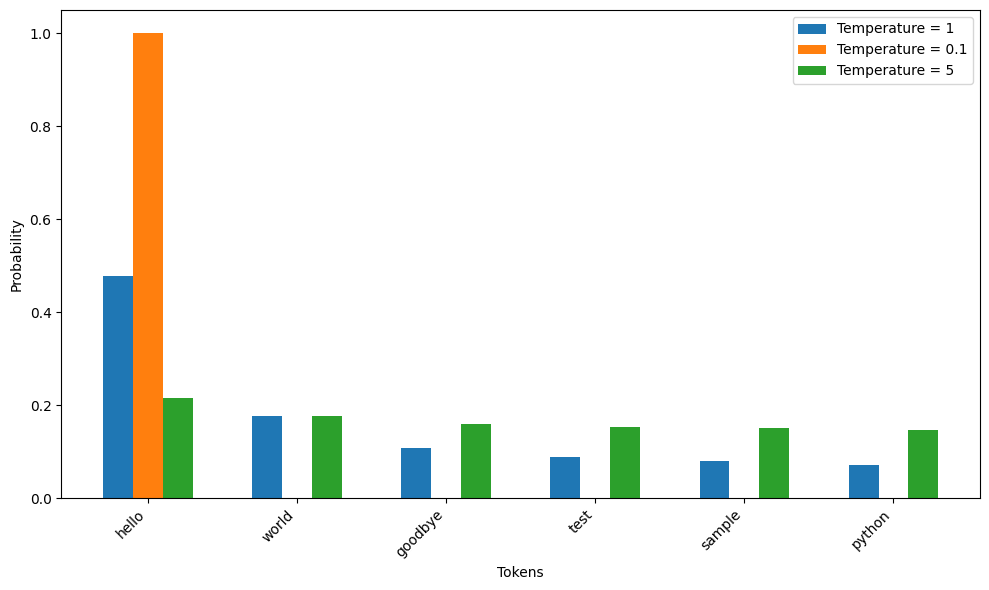

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt  # Library for creating visualizations
import torch  # PyTorch library for tensor operations

def softmax_with_temperature(logits, temperature):
    """
    Applies softmax to the logits with the specified temperature.

    Parameters:
    - logits (torch.Tensor): The raw output scores from the model for each token.
    - temperature (float): The temperature value to scale the logits.

    Returns:
    - torch.Tensor: The probability distribution after applying softmax with temperature.
    """
    # Scale the logits by dividing by the temperature
    scaled_logits = logits / temperature
    # Apply softmax to convert scaled logits to probabilities
    probabilities = torch.softmax(scaled_logits, dim=-1)
    return probabilities

# Example vocabulary and logits for demonstration purposes
vocab = {
    0: "hello",
    1: "world",
    2: "goodbye",
    3: "test",
    4: "sample",
    5: "python"
}

# Example next_token_logits (raw scores) for each token in the vocabulary
# In practice, these would come from your model's output
next_token_logits = torch.tensor([2.0, 1.0, 0.5, 0.3, 0.2, 0.1])

# Define different temperature values to observe their effect on probabilities
temperatures = [1, 0.1, 5]

# Calculate scaled probabilities for each temperature using the softmax_with_temperature function
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

# Create an array of indices corresponding to each token in the vocabulary
x = torch.arange(len(vocab))  # For example, tensor([0, 1, 2, 3, 4, 5])

# Define the width of each bar in the bar chart
bar_width = 0.2  # Increased slightly for better separation

# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better visibility

# Iterate over each temperature and its index to plot multiple bar charts
for i, T in enumerate(temperatures):
    """
    Plots a set of bars for each temperature.

    Parameters:
    - i (int): The index of the current temperature in the temperatures list.
    - T (float): The current temperature value.

    Explanation:
    - x + i * bar_width offsets each set of bars horizontally to place them side by side.
    - If we used x + bar_width for every temperature, all bars would overlap at the same position,
      making them indistinguishable.
    - By multiplying the index 'i' with 'bar_width', each subsequent set of bars is shifted further right.
    """
    # Calculate the position of the bars by adding an offset based on the temperature index
    bar_positions = x + i * bar_width

    # Plot the bars for the current temperature
    rects = ax.bar(
        bar_positions,                 # X-axis positions for the bars
        scaled_probas[i].numpy(),     # Heights of the bars (probabilities converted to NumPy array)
        bar_width,                     # Width of each bar
        label=f'Temperature = {T}'    # Label for the legend
    )

# Set the label for the y-axis
ax.set_ylabel('Probability')  # Y-axis represents the probability of each token

# Set the label for the x-axis
ax.set_xlabel('Tokens')  # X-axis represents the different tokens in the vocabulary

# Define the positions of the x-axis ticks
# Since multiple bars are plotted per token, shift the ticks to align them in the center
# The total width occupied by all bars per token is len(temperatures) * bar_width
total_bar_width = len(temperatures) * bar_width
tick_positions = x + (total_bar_width - bar_width) / 2

ax.set_xticks(tick_positions)  # Centers the ticks between the groups of bars

# Set the labels for each tick on the x-axis using the vocabulary keys
ax.set_xticklabels(vocab.values(), rotation=45, ha='right')  # Rotate labels for better readability

# Add a legend to differentiate between different temperatures
ax.legend()

# Adjust the layout to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

**If we take very small temperature value such as 0.1, most of the time it will select the most likely token. The higher the temperature, the less likely it will select the most likely token.**

Temperature allows to increase the diversity of the outputs. Higer temperatre -- higher diverse and vise versa.

## **Top-k sampling**

Although higher temperature values result in more uniformly distributed next-token probabilities and more diverse outputs; it can lead to grammatically incorrect and nonsensical outputs.

One solution to this problem is **top-k sampling** which combined with probabilistic sampling and temperature scaling can improve text generation results.

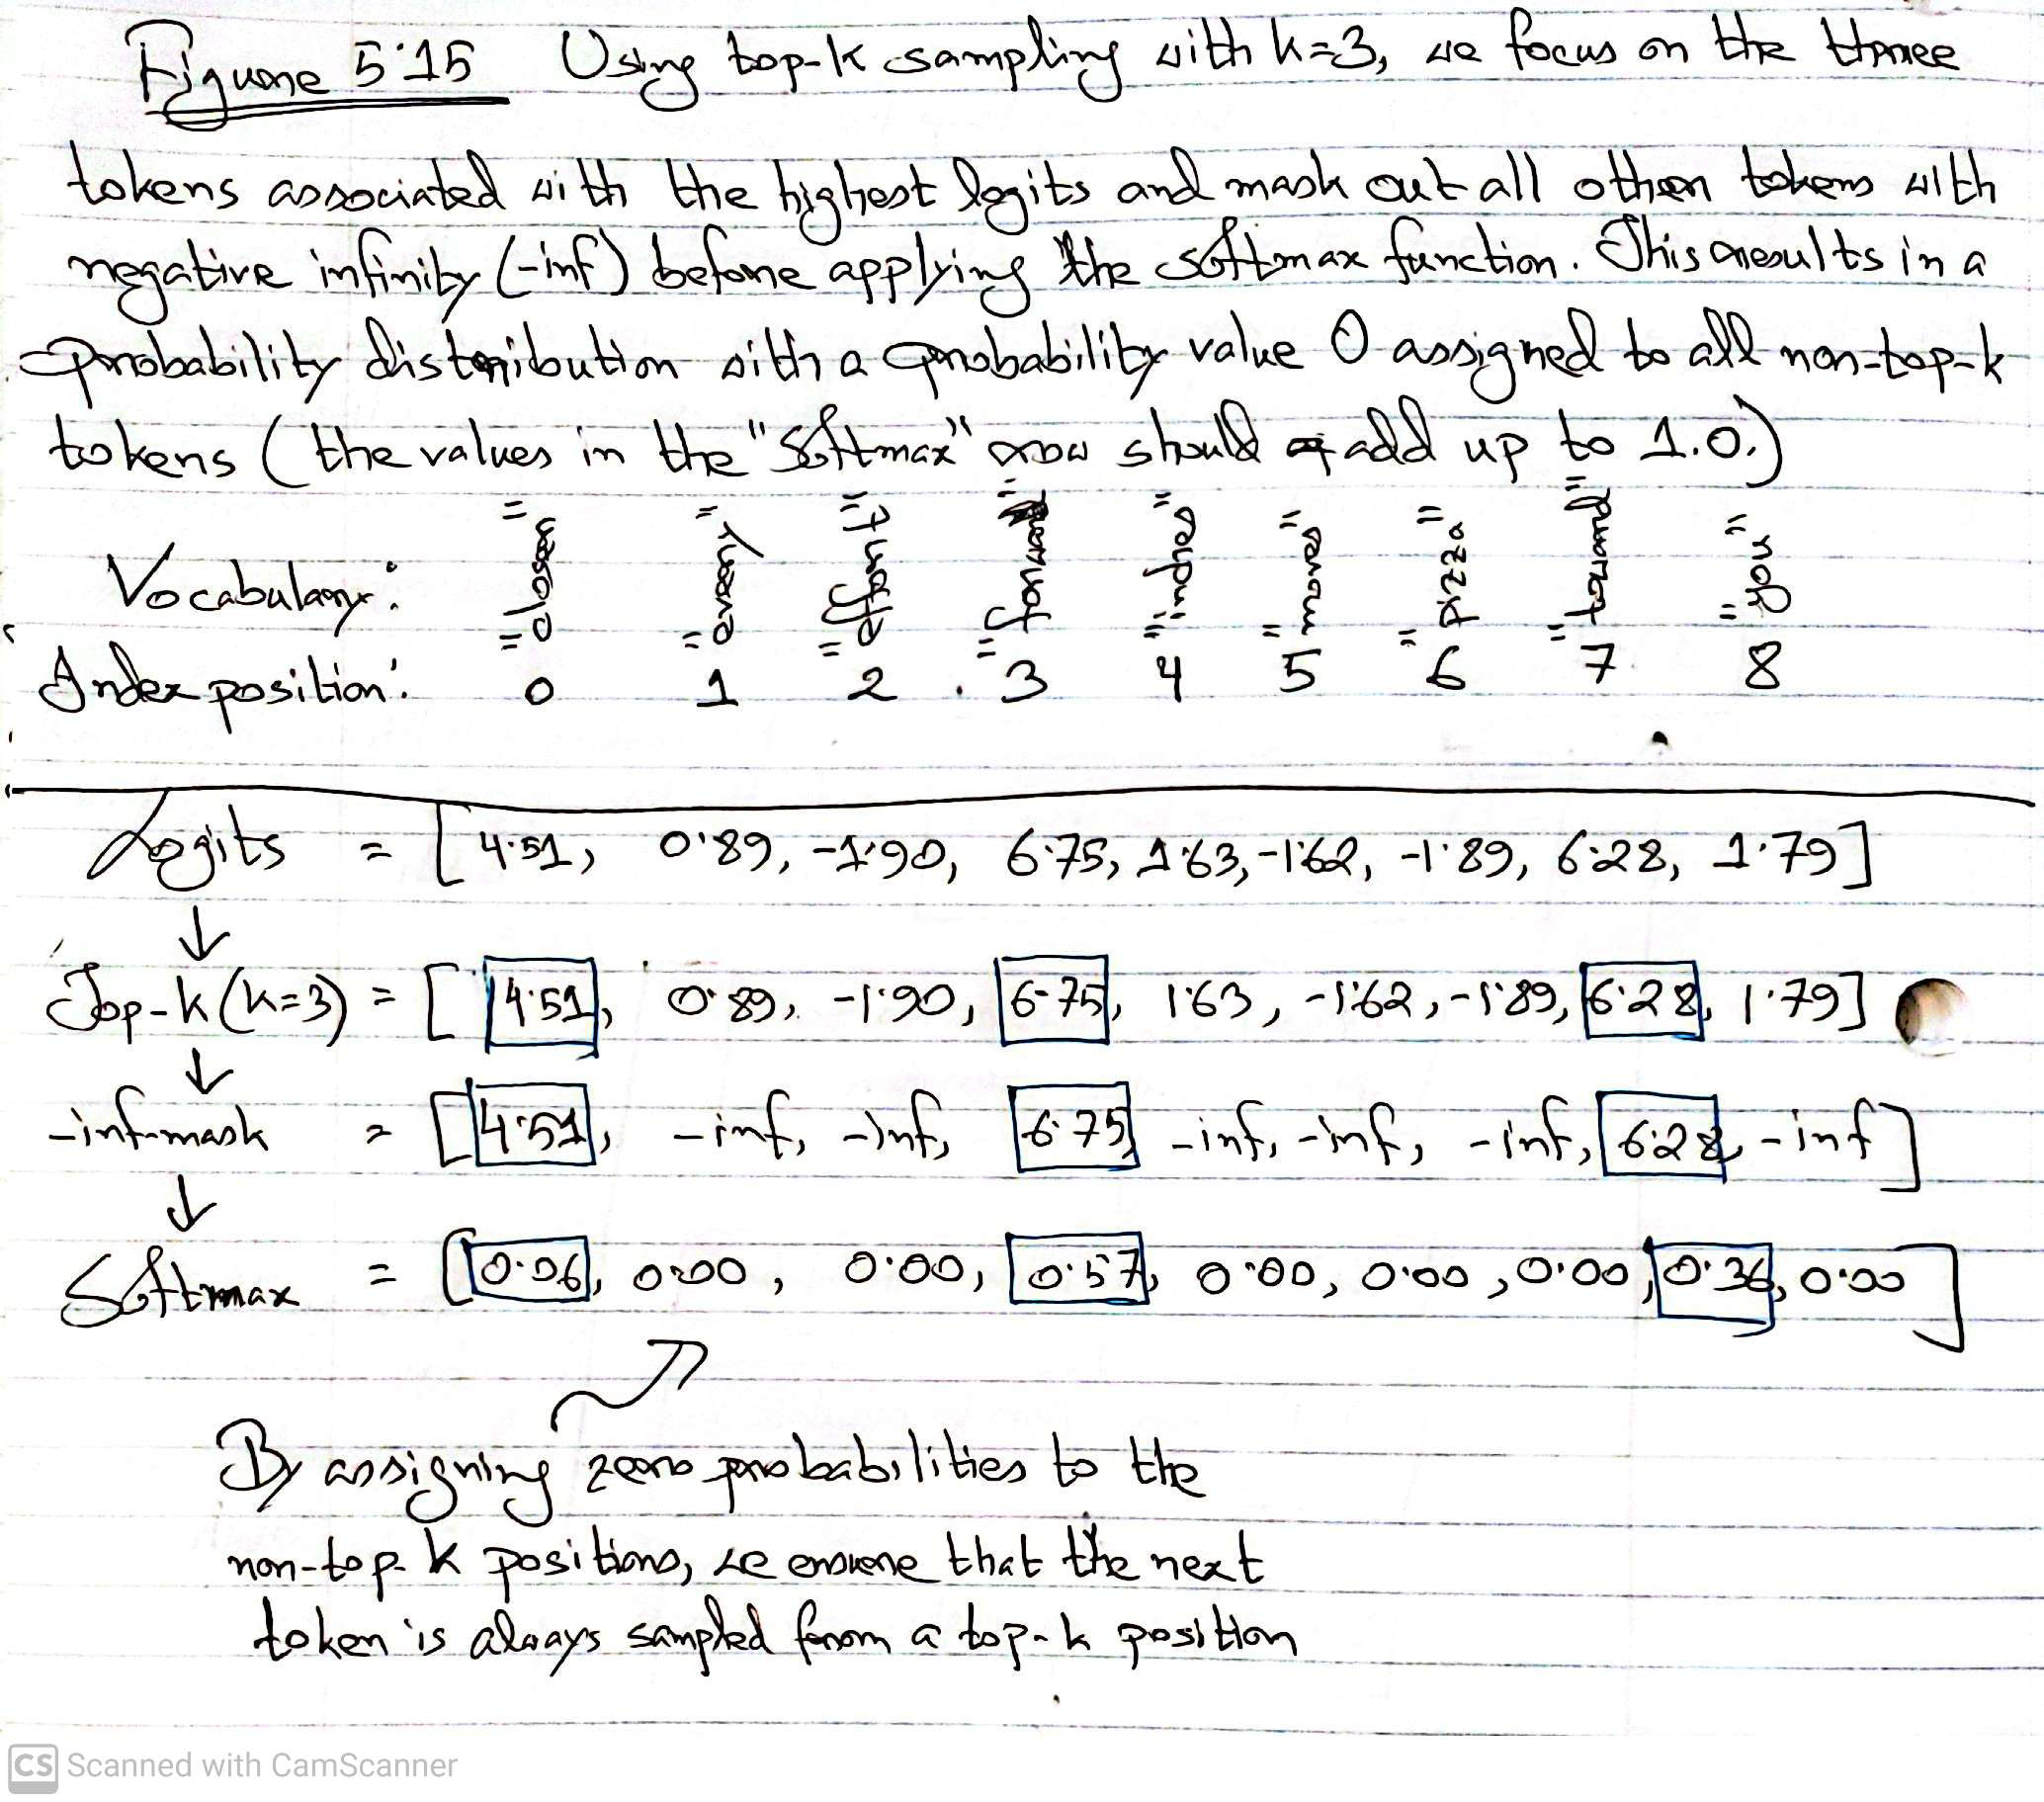

In [ ]:
display(Image(filename='5_15.jpg', width=800))

# 1. What is Top-K Sampling?

**Top-k sampling** is a probabilistic decoding method used in language models to generate text. It involves selecting the next text token (word or subword) from the **top $k$ most probable tokens** at each step of the generation process, based on the model's predicted probability distribution.

### a. Definition:

* **Top-K Sampling:** At each generation step, only the top $k$ tokens with the highest probabilities are considered for sampling. The probabilities of these $k$ tokens are **renormalized** to sum to 1, and the next token is randomly selected from this reduced set based on these adjusted probabilities.

### b. Mathematical Representation:

Given a probability distribution $P = [p_1, p_2, \dots, p_n]$ over a vocabulary of size $n$, top-k sampling involves the following steps:

1.  **Identify Top-K Tokens:** $$P_{\text{top-k}} = \{p_i \mid p_i \text{ is among the top } k \text{ probabilities in } P\}$$

2.  **Renormalize Probabilities:** $$P'_{\text{top-k}} = \frac{P_{\text{top-k}}}{\sum_{j \in \text{top-k}} p_j}$$

3.  **Sample Next Token:**
    * Select the next token based on the renormalized probabilities $P'_{\text{top-k}}$.

---

# 2. How Does Top-K Sampling Work?

Let's break down the top-k sampling process step by step with an illustrative example.

## a. Step-by-Step Process:

### 1. Model Prediction:

- The language model predicts a probability distribution over the vocabulary for the next token.

• **Example Probabilities:**

| Token | Probability |
|-------|-------------|
| A     | 0.40        |
| B     | 0.25        |
| C     | 0.15        |
| D     | 0.10        |
| E     | 0.07        |
| F     | 0.03        |

### 2. Select Top-K Tokens:

- Choose the top k tokens with the highest probabilities.

- **Example with k = 3**:

  - **Top-3 Tokens:** A (0.40), B (0.25), C (0.15)

### 3. Renormalize Probabilities:

• Sum the probabilities of the top-k tokens.

$$\text{Sum} = 0.40 + 0.25 + 0.15 = 0.80$$

• Divide each top-k probability by the sum to get the new probabilities.

$$P' = \left[\frac{0.40}{0.80}, \frac{0.25}{0.80}, \frac{0.15}{0.80}\right] = [0.50, 0.3125, 0.1875]$$

### 4. Sample Next Token:

• Randomly select the next token based on the renormalized probabilities.

• **Possible Outcomes:**

  - 50% chance: Token A

  - 31.25% chance: Token B

  - 18.75% chance: Token C

## b. Visualization:

Imagine a bar chart where the y-axis represents probabilities and the x-axis represents tokens. Only the top k tokens have visible bars, while the rest are excluded from consideration during sampling.

---

# 3. Why Use Top-K Sampling?

Top-k sampling offers several advantages that make it a popular choice in text generation tasks:

## a. Balancing Creativity and Coherence:

- **Preventing Unlikely Selections:** By restricting sampling to the top k tokens, top-k sampling avoids selecting tokens with very low probabilities, which can lead to incoherent or nonsensical text.

- **Maintaining Diversity:** While it limits the pool of tokens, it still allows for diversity within the top k, preventing the model from being overly deterministic.

## b. Controlling Output Quality:

- **Fine-Tuning k:** Adjusting the value of k allows you to control the trade-off between diversity and coherence. A smaller k leads to more predictable text, while a larger k increases diversity.

- **Flexibility:** Top-k sampling can be combined with other techniques like temperature scaling to further refine the generation process.

## c. Efficiency:

- **Computationally Manageable:** Limiting the sampling to the top k tokens reduces the computational overhead compared to considering the entire vocabulary, especially in large models with extensive vocabularies.

# 4. Comparing Top-K Sampling with Other Sampling Methods

To better understand top-k sampling, it's helpful to compare it with other common sampling strategies:

### a. Greedy Sampling:

* **Description:** Always selects the token with the highest probability (i.e., $\text{argmax}(P)$) at each step.
* **Pros:**
    * **Deterministic:** Produces the same output every time for a given prompt.
    * **Coherent:** Often generates coherent and grammatically correct text.
* **Cons:**
    * **Lacks Diversity:** Can result in repetitive and uninteresting text.
    * **May Miss Creative Options:** Ignores all other potentially relevant tokens.

### b. Top-P (Nucleus) Sampling:

* **Description:** Selects the smallest possible set of top tokens whose cumulative probability exceeds a threshold $p$ (e.g., 0.9). The next token is sampled from this set.
* **Pros:**
    * **Dynamic:** Adapts the size of the token pool based on the distribution, potentially offering a better balance between diversity and coherence.
    * **Efficient:** Often includes fewer tokens than top-k, making it more flexible.
* **Cons:**
    * **Complexity:** Slightly more complex to implement than top-k.
    * **Parameter Sensitivity:** Choosing the right $p$ requires experimentation.

### c. Top-K Sampling:

* **Description:** Selects the top $k$ tokens with the highest probabilities and samples from them.
* **Pros:**
    * **Simplicity:** Easy to implement and understand.
    * **Controlled Diversity:** By adjusting $k$, you can control the level of randomness.

Suppose we have the following logit tensor.

In [ ]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

Now, let's select top three tokens using `torch.topk`.

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


# 1. Breaking it Down

**a)** `torch.topk(tensor, k)`

- Finds the k largest values in the tensor.

- Returns two outputs:

   1. `top_logits`: The top k values (highest logits).

   2. `top_pos`: The indices (positions) of those values in the original tensor.

**b) What Are** `next_token_logits`**?**

- `next_token_logits` contains raw scores (logits) for all tokens in the vocabulary.

- Each value represents how likely the model thinks a token should come next.

- Example logits (assuming a small vocab of 6 tokens):

```python
next_token_logits = torch.tensor([2.0, 1.0, 0.5, 0.3, 0.2, 0.1])
```

---

# 2. Example of How `torch.topk()` Works

Let's assume:

```python
top_k = 3
next_token_logits = torch.tensor([2.0, 1.0, 0.5, 0.3, 0.2, 0.1])
```

Running:

```python
top_logits, top_pos = torch.topk(next_token_logits, top_k)
```

Outputs:

```python
top_logits = tensor([2.0, 1.0, 0.5])  # The top 3 highest values
top_pos = tensor([0, 1, 2])           # Their positions in next_token_logits
```

Explanation:

• The highest value is `2.0`, at index `0`.

• The second highest value is `1.0`, at index `1`.

• The third highest value is `0.5`, at index `2`.

**Note: The resulting tensor from `torch.topk` are in descending order.**

Now, we set all the logit values less than the top k values to minus infinity.

In [ ]:
# Step 2: Mask logits not in the top_k by setting them to -inf
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],  # Condition: logit is less than the smallest logit in top_k
    input=torch.tensor(float('-inf')),            # Value to assign if condition is True (mask the token)
    other=next_token_logits                       # Keep original value if condition is False
)

# Explanation of `torch.where`:
# - `condition`: Checks if each token's logit is less than the smallest logit in top_k (i.e., `top_logits[-1]`).
# - `input`: Specifies the value to use where the condition is True. Here, we use `-inf` to effectively mask tokens.
# - `other`: Keeps the original logits where the condition is False (i.e., for the top_k tokens).

# Why is -inf used as `input`?
# - Setting logits to `-inf` ensures these tokens have zero probability after applying softmax.
# - This effectively removes them from the sampling process.

# Why use `torch.where` instead of directly modifying `next_token_logits`?
# - `torch.where` provides a clean, vectorized way to selectively modify elements in the tensor.
# - It avoids overwriting the original tensor, preserving it for further computations if needed.

# Example Condition (`next_token_logits < top_logits[-1]`):
# - `top_logits[-1]`: Smallest logit in top_k (e.g., 0.5 in this case).
# - Condition: `[False, False, False, True, True, True]`

# Example Output of `new_logits`:
# - Masked logits: `[2.0, 1.0, 0.5, -inf, -inf, -inf]`

print(new_logits)

# Final Explanation:
# - After applying `torch.where`, only the top_k logits remain unchanged.
# - All other logits are set to -inf, ensuring they are ignored in subsequent sampling steps.
# - This masking step is a critical part of top-k sampling, as it restricts token selection to the most probable tokens.

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Now, we apply softmax.

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Now, we can apply the temperature scaling and multinomial function for probabilistic sampling for selecting the next token.

Previously, generate_text_simple function was as following which we will modify now.

In [ ]:
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

Now, we write a modified one named `generate` that uses top-k sampling along with temperature.

In [ ]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id: # if end-of-sequence token is encountered, stop loop early
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

Now, we will use this new `generate` function with `top_k = 15` (or top 15 tokens with highest probabiliteis) temperature value of `1.4` to predict `15` new words or tokens.

In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you'd he wouldn down--it, and thought one: "Whenating with


## **Loading and saving model weights in PyTorch**

As training LLM is computationally expensive, we would like to save the trained LLM so that we don't have to train it every time we would like to use it. Below, we save our model.

In [ ]:
# Save the model's parameters to a file
torch.save(model.state_dict(), "model.pth")

# Explanation:
# - `torch.save`: A PyTorch function used to save a serialized version of an object to a file.
# - `model.state_dict()`:
#   - Retrieves the state dictionary of the model, which is a Python dictionary mapping each layer's name to its corresponding parameters (e.g., weights and biases).
#   - Only the parameters of the model are saved, not the entire model object.
# - `"model.pth"`:
#   - The file name where the model's state dictionary will be saved.
#   - `.pth` is a common extension for PyTorch model files, but you can use any name or extension.
#   - It indicates that the file contains PyTorch data.

# Why Use `model.state_dict()` Instead of Saving the Entire Model?
# - The state dictionary only includes the model's parameters (weights and biases) and not the structure of the model.
# - This makes the saved file smaller and more flexible:
#   - You can reload the parameters into a new instance of the same model class.
#   - This approach avoids issues when loading models across different environments or PyTorch versions.

# Why Save as `"model.pth"`?
# - The `.pth` extension is a PyTorch convention for saving model parameters or serialized objects.
# - It makes it clear that the file contains data related to PyTorch, ensuring compatibility with tools and libraries that expect PyTorch models.

# Example Workflow:
# 1. Train a model on your dataset.
# 2. Save the model's parameters using `torch.save(model.state_dict(), "model.pth")`.
# 3. Later, reload the parameters into a model instance using `model.load_state_dict(torch.load("model.pth"))`.
# 4. This allows you to resume training or perform inference without retraining the model.

# Additional Notes for Beginners:
# - **state_dict vs Entire Model**:
#   - Saving only `state_dict()` is more efficient and flexible.
#   - Saving the entire model object (using `torch.save(model, "model.pth")`) saves the model's structure and parameters, but it makes the file less portable and potentially incompatible across environments.
# - **Why Save the Model?**
#   - To avoid retraining the model from scratch every time you want to use it.
#   - To deploy the model for inference (e.g., predicting new data).

# In summary:
# `torch.save(model.state_dict(), "model.pth")` is the recommended way to save the learned parameters of a model for portability, compatibility, and efficiency.

#### **Load the saved model weights**

Now, load the model weight using `state_dict` to load the model weights into a new GPTModel instance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features


The reason for using `model.eval()` after loading the model is to set the model to evaluation mode, which is essential when performing inference (i.e., using the model for predictions rather than training).

### **What Does model.eval() Do?**
1. **Disables Dropout Layers:**

  - During training, dropout is used as a regularization technique, randomly setting some neuron activations to zero to prevent overfitting.
  - In evaluation mode, `model.eval()` ensures that dropout is disabled, so the entire network is used without any randomness.

2. **Changes Behavior of Batch Normalization Layers:**

  - Batch normalization behaves differently during training and inference:
    - **Training Mode:** Uses batch statistics (mean and variance of the current batch) for normalization.
    - **Evaluation Mode:** Uses **running statistics** (mean and variance accumulated during training) for normalization.
  - `model.eval()` ensures that the model uses the running statistics during inference, maintaining consistency with what the model learned during training.

3. Ensures Predictable Outputs:

  - By setting the model to evaluation mode, you make sure the model behaves deterministically during inference, which is crucial for consistent and accurate predictions.

### **Why Call `model.eval()` After Loading?**
- When a model is loaded using `torch.load` or `load_state_dict`, it defaults to training mode because the training/evaluation state is not saved with the model's parameters.
- Calling `model.eval()` explicitly switches the model to evaluation mode, ensuring that it behaves as expected during inference.

### **What Happens If We Don’t Use `model.eval()`?**

1. **Dropout Layers:**

  - Random neurons will still be deactivated during inference, leading to different outputs for the same input each time you run the model.
2. **Batch Normalization Layers:**

  - The model will normalize using batch statistics instead of running statistics, leading to unpredictable and incorrect outputs, especially if the batch size is small or consists of a single sample.


For Adam optimizer, we need to save both the model and optimizer `state_dict` contents. This ensures that we also have the additional parameters for model weight.

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
           "model_and_optimizer.pth")

#### **Using saved model**

Now, to use this saved model, we need to first load the saved data using `torch.load` and then use the `load_state_dict` method.

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Why Use `model.train()` After Loading Trained Parameters?

1. **To Continue Training:**
   - Even if the model has already been trained partially or completely, you might want to **resume training** (e.g., fine-tuning on a new dataset).  
   - In such cases, `model.train()` ensures that the model is prepared to continue training.

2. **Explicitly Resetting the Mode:**
   - While loading parameters doesn’t affect the mode (training or evaluation), it’s a good practice to explicitly set the mode to **train** or **eval** depending on your task.  
   - For example:

     ```python
     model.train()  # For training
     model.eval()   # For inference
     ```

3. **Consistency in Training Workflow:**
   - By explicitly calling `model.train()`, you ensure that the model behaves as expected in training mode. This is particularly useful in collaborative projects or complex workflows where the model’s mode might be unclear.

---

# Why Isn’t `model.eval()` Used Here?

- `model.eval()` is used for **inference** (e.g., generating text or evaluating the model’s performance on a test dataset).  
- In this case, since we want to **resume training** the model, calling `model.train()` is the appropriate choice.


# **Loading pretrained weights from OpenAI**

We have learned how to pretrain the LLM. But the problem is we used a very samll dataset. But, we can use the model weights from GPT-2 by OpenAI as these are opublicly available. As OpenAI saves the GPT-2 weights using Tensorflow, we need to install it to install and load the weights in Python. We will also use `tqdm` package to look at the progress bar for looking at download progress.

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>>=4.66

The code for download can be found in the file `gpt_download.py` which we download from the github page by Raschka of the book "Hands on Large-Language Models" that these notebooks are based on.

In [ ]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7f1f09a01790>)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


## **Let's understand what we see above for Settings and Parameter dictionary keys**

### **Settings:**

``python
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
``

This tells us that:

- `n_vocab`: The model can handle a vocabulary of 50,257 tokens.
- `n_ctx`: The model processes up to 1,024 tokens in one input sequence (context length).
- `n_embd`: Each token is represented by a vector of size 768 in the embedding space.
- `n_head`: Each transformer block has 12 attention heads.
- `n_layer`: There are 12 transformer blocks stacked to form the model.

### **Parameter Dictionary Keys:**

``python
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
``

These keys represent different components of the model:

1. blocks:

  - Contains the weights and biases for each transformer block.
  - Each block includes attention layers, feed-forward layers, and layer normalization parameters.

2. b (Bias):

  - Represents a bias tensor used in the output layer.

3. g (Gain):

  - Represents gain parameters used for scaling in layer normalization.

4. wpe (Position Embeddings):

  - A tensor for positional embeddings, which encode the position of each token in the input sequence.
  - Shape: (n_ctx, n_embd) → (1024, 768).
5. wte (Token Embeddings):

  - A tensor for token embeddings, which map each token in the vocabulary to a dense vector in the embedding space.
  - Shape: (n_vocab, n_embd) → (50257, 768).

**Inspecting the Embedding Layer (params["wte"])**

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


Differences between different GPT model sizes.

In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [ ]:
display(Image(filename='5_17.jpg', width=800))

Now, load the **gpt2-small (124M)** model by transferring the `seetings` and `params` dictionaries into our `GPTModel` instance.

In [ ]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [ ]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [ ]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

OpenAI used bias vectors in the multi-head attention.

In [ ]:
NEW_CONFIG.update({"qkv_bias": True})

In [ ]:
NEW_CONFIG.update({"context_length": 1024})

In [ ]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

Now, we can use the updated `NEW_CONFIG` dictionary for initializing a new `GPTModel` instance. We will use this `GPTModel` instance `gpt` to load weights of GPT-2 from OpenAI.

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Write a helper function `assign` that checks whether two tensors or arrays have the same dimensions or shape and returns the right tensor as trainable parameters.

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, "
    "Right: {right.shape}"
    )
  return torch.nn.Parameter(torch.tensor(right))

### **1. Purpose of the Function:**
- It takes two inputs:
    1. left: A tensor (usually a model weight) whose shape we want to match.
    2. right: A tensor (pre-trained weight) we want to assign to the model.
- The function checks if left and right have the same shape.
- If the shapes match, it converts right into a trainable PyTorch parameter and returns it.
- If the shapes don’t match, it raises an error to prevent assigning mismatched weights.

### **2. Why Do We Check Shapes?**
- Model layers expect weights of specific dimensions (shapes). For example:
  - A token embedding layer might expect weights of shape (50257, 768).
  - A positional embedding layer might expect weights of shape (256, 768).
- If the shapes of the random weights (left) and the pre-trained weights (right) don’t match, the model would fail to work properly.
- This function ensures the shapes match before making the assignment.

Now, write a function `load_weights_into_gpt` to load the weights from the `params` dictionary into a `GPTModel` instance `gpt` that we just created.

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

  for b in range(len(params["blocks"])):

    # Assigning Attention Weights and Biases

    # Assigning Attention weights:
    q_w, k_w, v_w = np.split(
        (params["block"][b]["attn"]["c_attn"])["w"], 3, axis=-1
    )
    gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query_weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key_weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value_weight, v_w.T)

    # Assigning Output Projection Biases in Attention
    q_b, k_b, v_b = np.split(
        (params["block"][b]["attn"]["c_attn"])["b"], 3, axis=-1
    )
    gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

    ## Assigning Feed-Forward (FF) Layer Weights and Biases:

    # First linear layer
    gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
    # Second linear layer
    gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

    ## Assigning Layer Normalization (Norm) Weights and Biases:

    # Access the scale (g) and shift (b) parameters for the first layer normalization (ln_1) in block b
    gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])

    # Access the scale (g) and shift (b) parameters for the second layer normalization (ln_2) in block b
    gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### **1. Overview of the params Dictionary**

The `params` dictionary holds all the pre-trained weights of the GPT model. Its structure mirrors the architecture of the GPT model, organizing weights and biases hierarchically by layers and components.

**High-Level Structure:**


```python
params = {
    "blocks": [
        {
            "attn": {
                "c_attn": {
                    "w": <numpy array>,  # Combined Query, Key, Value weights
                    "b": <numpy array>   # Combined Query, Key, Value biases
                },
                "c_proj": {
                    "w": <numpy array>,  # Output projection weights
                    "b": <numpy array>   # Output projection biases
                }
            },
            "mlp": {
                "c_fc": {
                    "w": <numpy array>,  # Feed-Forward Network (FFN) first layer weights
                    "b": <numpy array>   # FFN first layer biases
                },
                "c_proj": {
                    "w": <numpy array>,  # FFN second layer weights
                    "b": <numpy array>   # FFN second layer biases
                }
            },
            "ln_1": {
                "g": <numpy array>,      # LayerNorm1 scale parameters
                "b": <numpy array>       # LayerNorm1 shift parameters
            },
            "ln_2": {
                "g": <numpy array>,      # LayerNorm2 scale parameters
                "b": <numpy array>       # LayerNorm2 shift parameters
            }
        },
        # ... more blocks
    ],
    "wpe": <numpy array>,       # Positional Embedding weights
    "wte": <numpy array>,       # Token Embedding weights
    "g": <numpy array>,         # Final LayerNorm scale
    "b": <numpy array>          # Final LayerNorm shift
```

**Visual Representation of Weight Assignment**
To better visualize the process, imagine the GPT model as a series of interconnected components, each requiring specific weights and biases:

```
GPTModel
│
├── pos_emb (Positional Embeddings)
│   └── weight
│
├── tok_emb (Token Embeddings)
│   └── weight
│
├── trf_blocks (Transformer Blocks)
│   ├── Block 0
│   │   ├── att (Attention)
│   │   │   ├── W_query.weight
│   │   │   ├── W_key.weight
│   │   │   ├── W_value.weight
│   │   │   ├── W_query.bias
│   │   │   ├── W_key.bias
│   │   │   ├── W_value.bias
│   │   │   ├── out_proj.weight
│   │   │   └── out_proj.bias
│   │   ├── ff (Feed-Forward Network)
│   │   │   ├── layers[0].weight
│   │   │   ├── layers[0].bias
│   │   │   ├── layers[2].weight
│   │   │   └── layers[2].bias
│   │   ├── norm1.scale
│   │   ├── norm1.shift
│   │   ├── norm2.scale
│   │   └── norm2.shift
│   │
│   ├── Block 1
│   │   ├── ... (same structure as Block 0)
│   │
│   └── ...
│
├── final_norm.scale
├── final_norm.shift
└── out_head.weight
```

# 1️⃣ Why only `layers[0]` and `layers[2]` get weights (not `layers[1]`)

Inside each feed-forward network (FFN) the model is built like this:

```python
self.ff = nn.Sequential(
    nn.Linear(d_model, 4 * d_model),  # layers[0]
    nn.GELU(),                        # layers[1] - no parameters
    nn.Linear(4 * d_model, d_model)   # layers[2]
)
```

| Layer index | Module    | Learnable tensors | Tensor shapes                |
|-------------|-----------|-------------------|------------------------------|
| layers[0]   | nn.Linear | weights, biases   | (4 * d_model, d_model)      |
|             |           |                   | (4 * d_model,)              |
| layers[1]   | nn.GELU   | *(none)*          | — *(stateless activation)*   |
| layers[2]   | nn.Linear | weights, biases   | (d_model, 4 * d_model)      |
|             |           |                   | (d_model,)                  |

Because `layers[1]` contains **no** weights or biases, the loader skips it and copies parameters only for indices 0 and 2.

---

# 2️⃣ Why there are two `LayerNorm`s in every transformer block

GPT-2 and successors use the pre-LayerNorm design:

```text
residual ──┐
           ├─ LayerNorm (ln_1) ➜ Multi-Head Attention ➜ + residual
updated ───┘

           ├─ LayerNorm (ln_2) ➜ Feed-Forward (MLP)  ➜ + residual
```

• `ln_1` (norm1) – applied *before* the attention sub-layer to stabilise attention.

• `ln_2` (norm2) – applied *before* the feed forward or multi-layer perceptron (MLP) sub-layer for the same reason.

Using two separate normalisations lets each sub-layer see a freshly normalised input, improving training stability and enabling deeper stacks (12 → 24 → 48 ...).

**Learnable tensors**

```pascal
scale (γ) = checkpoint key "g" = maps to norm1.scale (PyTorch weight)
shift (β) = checkpoint key "b" = maps to norm1.shift (PyTorch bias)
```

## **Assigning Positional and Token Embeddings:**

```python
gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
```

- `gpt.pos_emb.weight`: The positional embedding weights in the GPT model.
- `params['wpe']`: Pre-trained positional embedding weights from the params dictionary.
- `gpt.tok_emb.weight`: The token embedding weights in the GPT model.
- `params['wte']`: Pre-trained token embedding weights from the params dictionary.
- `assign` **Function**: Ensures that the shapes match and converts `params['wpe']` and `params['wte']` into trainable Parameter objects before assigning them to the model.

### **Looping Through Transformer Blocks:**

```python
for b in range(len(params["blocks"])):
    ...
```

- **Purpose:** The GPT model consists of multiple transformer blocks (e.g., 12 layers for GPT-2 small). This loop iterates over each block to assign pre-trained weights to all components within each transformer block.

### **Assigning Attention Weights and Biases:**

```python
q_b, k_b, v_b = np.split(
    (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
gpt.trf_blocks[b].att.W_query.bias = assign(
    gpt.trf_blocks[b].att.W_query.bias, q_b)
gpt.trf_blocks[b].att.W_key.bias = assign(
    gpt.trf_blocks[b].att.W_key.bias, k_b)
gpt.trf_blocks[b].att.W_value.bias = assign(
    gpt.trf_blocks[b].att.W_value.bias, v_b)
```

- Breaking Down the Code:
  - `params["blocks"][b]["attn"]["c_attn"]["b"]`:
    - Accesses the concatenated bias vector for the attention mechanism within block b.
    - This vector typically combines biases for query (`b_q`), key (`b_k`), and value (`b_v`) projections.
  - `np.split(..., 3, axis=-1)`:
    - Splits the concatenated bias vector into three separate vectors.
    - **Result**: `q_b`, `k_b`, `v_b` correspond to the query, key, and value bias vectors, respectively.
  - **Assignment:**
    - Assigns the bias vectors to the model's attention layers (`W_query.bias`, `W_key.bias`, `W_value.bias`) using the assign function.


## The one-liner, unpacked

```python
Q_W, K_W, V_W = np.split(
    params["blocks"][b]["attn"]["c_attn"]["w"],  # full Q-K-V matrix
    3,                                           # into 3 equal chunks
    axis=-1                                      # along the last axis
)
```

| Part | What it is doing |
|------|------------------|
| `params["blocks"][b]["attn"]["c_attn"]["w"]` | Fetches one big weight matrix that holds the *concatenated* Q, K, and V linear-projection weights for block `b`. |
| `np.split(_, 3, axis=-1)` | Slices that matrix into three equal pieces along its last dimension (`axis = -1`), returning them as `Q_W`, `K_W`, `V_W`. |

---

## Why `axis=-1`?

- `axis=-1` means "split along the last axis, whatever its index is."  
  That makes the code agnostic to whether the weight matrix is stored as shape  
  `(n_embd, 3 * n_embd)` or `(3 * n_embd, n_embd)`.

- In GPT-2 checkpoints the shape is `(n_embd, 3 * n_embd)`.

  - For the 124 M model: `(768, 2304)`.

  - The last axis (columns) is length `3 * 768`, so splitting it into three equal parts yields three `(768, 768)` matrices.

```perl
last axis ───➤ 2304 cols
                                       
weights = │  Q  │  K  │  V  │ shape = (768, 2304)
          └─────┴─────┴─────┘
             ▲     ▲     ▲
             │     │     │
             └─ split into three (axis = -1)
```

---

## Resulting tensors

```text
Q_W.shape == (768, 768)  # Query projection weights
K_W.shape == (768, 768)  # Key projection weights
V_W.shape == (768, 768)  # Value projection weights
```

Each one will later be transposed (`.T`) before being assigned to the corresponding `nn.Linear` layer so that PyTorch's `(out_features, in_features)` convention is satisfied.

---

**Quick sanity check in code**

```python
W = params["blocks"][0]["attn"]["c_attn"]["w"]  # first block
print("Full weight matrix:", W.shape)          # (768, 2304)

Q_W, K_W, V_W = np.split(W, 3, axis=-1)
print(Q_W.shape, K_W.shape, V_W.shape)         # (768, 768) each
```

That confirms the dimensions and shows exactly why `axis=-1` is used.

The `3` in the `np.split(..., 3, axis=-1)` line is used because the **query** (`q`), **key** (`k`), and **value** (`v`) weight matrices are stored as a single concatenated matrix in `params["blocks"][b]["attn"]["c_attn"]["w"]`.

## Why `3`?

• In **transformer models like GPT**, self-attention involves three different weight matrices:

  • **Query** (`Q`) **weights**: Used to determine what part of the input is relevant.

  • **Key** (`K`) **weights**: Used to compare with queries.

  • **Value** (`V`) **weights**: Used to generate the final attention-weighted representation.

• These weights are often **stored together as a single matrix** for efficiency.

• Since they are concatenated along the last dimension (`axis=-1`), we need to **split it into three equal parts** to recover the individual `Q`, `K`, and `V` weight matrices.

## How does it extract `q_w`?

1. `params["blocks"][b]["attn"]["c_attn"]["w"]` contains a single large matrix where:

   $$W_{c\_attn} = [W_Q \mid W_K \mid W_V]$$

   meaning it has three equal parts corresponding to `Q`, `K`, and `V`.

2. `np.split(..., 3, axis=-1)` divides this matrix **into three separate matrices** along the last dimension:

   • `q_w`: First third → Query weights.

   • `k_w`: Second third → Key weights.

   • `v_w`: Last third → Value weights.

This is done because **GPT-style architectures** store these weights efficiently as one tensor instead of three separate tensors. By splitting them, we can properly assign them to the model's query, key, and value weight matrices.

---

## Example:

Assume `params["blocks"][b]["attn"]["c_attn"]["w"]` has a shape of **(hidden_dim, 3 × hidden_dim)**.

- Let's say `hidden_dim = 768`, then this matrix has shape **(768, 2304)**.

- Splitting along `axis=-1` (i.e., the last dimension) into three parts, each part will have **shape (768, 768)**.

- This gives:

  - `q_w`: (768, 768) → Query weights.

  - `k_w`: (768, 768) → Key weights.

  - `v_w`: (768, 768) → Value weights.

This technique ensures that the model correctly extracts the **Query, Key, and Value** matrices from the stored weight tensor.

### **Assigning Output Projection Weights and Biases in Attention:**

```python
gpt.trf_blocks[b].att.out_proj.weight = assign(
    gpt.trf_blocks[b].att.out_proj.weight,
    params["blocks"][b]["attn"]["c_proj"]["w"].T)
gpt.trf_blocks[b].att.out_proj.bias = assign(
    gpt.trf_blocks[b].att.out_proj.bias,
    params["blocks"][b]["attn"]["c_proj"]["b"])
```

- `params["blocks"][b]["attn"]["c_proj"]["w"]`:
  - Accesses the weight matrix for the attention output projection.
- `params["blocks"][b]["attn"]["c_proj"]["w"].T`:
  - Transposes the weight matrix to match PyTorch's expected shape.
- `params["blocks"][b]["attn"]["c_proj"]["b"]`:
  - Accesses the bias vector for the attention output projection.
- **Assignment**:
  - Assigns the transposed weight matrix and bias vector to the model's attention output projection layer (out_proj.weight, out_proj.bias) using the assign function.

### Why Are We Taking the Transpose?

• Since **NumPy and TensorFlow** store weight matrices in the **(input_dim, output_dim)** format, but PyTorch expects **(output_dim, input_dim)**, we need to **transpose** (`.T`) the matrix before assigning it to PyTorch.

• Transposing swaps the rows and columns, making it compatible with PyTorch's expected format.

### Illustration

**Shape in TensorFlow / NumPy (Before Transpose)**

```python
params["blocks"][b]["attn"]["c_proj"]["w"].shape
# Example: (768, 768) in TensorFlow format (in_features, out_features)
```

**Shape in PyTorch (After Transpose)**

```python
params["blocks"][b]["attn"]["c_proj"]["w"].T.shape
# Example: (768, 768) in PyTorch format (out_features, in_features)
```

### Final Explanation

• We take the **transpose** because **PyTorch's** `nn.Linear` layer expects **weights in the (output_dim, input_dim) format**.

• The **original weights from the GPT-2 checkpoint are stored in (input_dim, output_dim)**.

• **By transposing them, we align them with PyTorch's convention**, ensuring that the weight assignments work correctly.

This transformation ensures that the matrix multiplication in the **attention output projection layer** behaves as expected when loading pre-trained weights.

### **Assigning Feed-Forward (FF) Layer Weights and Biases:**

```python
gpt.trf_blocks[b].ff.layers[0].weight = assign(
    gpt.trf_blocks[b].ff.layers[0].weight,
    params["blocks"][b]["mlp"]["c_fc"]["w"].T)
gpt.trf_blocks[b].ff.layers[0].bias = assign(
    gpt.trf_blocks[b].ff.layers[0].bias,
    params["blocks"][b]["mlp"]["c_fc"]["b"])
gpt.trf_blocks[b].ff.layers[2].weight = assign(
    gpt.trf_blocks[b].ff.layers[2].weight,
    params["blocks"][b]["mlp"]["c_proj"]["w"].T)
gpt.trf_blocks[b].ff.layers[2].bias = assign(
    gpt.trf_blocks[b].ff.layers[2].bias,
    params["blocks"][b]["mlp"]["c_proj"]["b"])
```

Explanation of the code.

- **Feed-Forward Layers:**
  - GPT's transformer blocks include a feed-forward network (FFN) typically consisting of two linear layers with an activation function in between.
  - Here, layers[0] and layers[2] correspond to the two linear layers in the FFN.
- `params["blocks"][b]["mlp"]["c_fc"]["w"]`:
  - Accesses the weight matrix for the first linear layer in the FFN.
- `params["blocks"][b]["mlp"]["c_fc"]["b"]`:
  - Accesses the bias vector for the first linear layer in the FFN.
- `params["blocks"][b]["mlp"]["c_proj"]["w"]`:
  - Accesses the weight matrix for the second linear layer in the FFN.
`params["blocks"][b]["mlp"]["c_proj"]["b"]`:
  - Accesses the bias vector for the second linear layer in the FFN.
- **.T Transpose**:
  - Transposes the weight matrices to match PyTorch's expected shapes.
- **Assignment**:
  - Assigns the transposed weight matrices and bias vectors to the model's FFN layers using the assign function.



**Assigning Layer Normalization (Norm) Weights and Biases:**

```python
gpt.trf_blocks[b].norm1.scale = assign(
    gpt.trf_blocks[b].norm1.scale,
    params["blocks"][b]["ln_1"]["g"])
gpt.trf_blocks[b].norm1.shift = assign(
    gpt.trf_blocks[b].norm1.shift,
    params["blocks"][b]["ln_1"]["b"])
gpt.trf_blocks[b].norm2.scale = assign(
    gpt.trf_blocks[b].norm2.scale,
    params["blocks"][b]["ln_2"]["g"])
gpt.trf_blocks[b].norm2.shift = assign(
    gpt.trf_blocks[b].norm2.shift,
    params["blocks"][b]["ln_2"]["b"])
```

- **Layer Normalization Layers:**
  - GPT uses layer normalization (norm1 and norm2) within each transformer block to stabilize and accelerate training.
  - Each normalization layer has two parameters:
    - **Scale** (scale): Learnable scaling factor.
    - **Shift** (shift): Learnable shifting factor.
- `params["blocks"][b]["ln_1"]["g"]` and `params["blocks"][b]["ln_1"]["b"]`:
  - Access the scale (`g`) and shift (`b`) parameters for the first layer normalization (`ln_1`) in block b.
- `params["blocks"][b]["ln_2"]["g"]` and `params["blocks"][b]["ln_2"]["b"]`:
  - Access the scale (`g`) and shift (`b`) parameters for the second layer normalization (`ln_2`) in block b.
- **Assignment:**
  - Assigns these parameters to the model's layer normalization layers (`norm1.scale`, `norm1.shift`, `norm2.scale`, `norm2.shift`) using the assign function.

**Assigning Final Layer Normalization and Output Head Weights:**

```python
gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
```

- **Final Layer Normalization (`final_norm`):**
  - Applies layer normalization after all transformer blocks to stabilize the final output.
  - `params["g"]`: Scale parameter for final normalization.
  - `params["b"]`: Shift parameter for final normalization.
- **Output Head (`out_head.weight`)**:
  - Maps the final hidden states to the vocabulary space to generate logits for each token.
  - `params["wte"]`: Token embedding weights are reused here as the output projection weights.
- **Assignment:**
Assigns the final normalization parameters and output head weights using the assign function.

The same code with enough explanatory comments.

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    # Assign Positional Embedding Weights
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    # Explanation:
    # - `gpt.pos_emb.weight`: The positional embedding weights in the GPT model.
    # - `params['wpe']`: Pre-trained positional embedding weights from `params`.
    # - `assign`: Ensures shapes match and converts `params['wpe']` to a trainable Parameter.

    # Assign Token Embedding Weights
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    # Explanation:
    # - `gpt.tok_emb.weight`: The token embedding weights in the GPT model.
    # - `params['wte']`: Pre-trained token embedding weights from `params`.
    # - `assign`: Ensures shapes match and converts `params['wte']` to a trainable Parameter.

    # Loop Through Each Transformer Block
    for b in range(len(params["blocks"])):
        # Explanation:
        # - Iterates over each transformer block to assign weights for attention, feed-forward networks, and layer norms.

        # Assign Attention Weights and Biases
        # Split combined QKV weights into separate Query, Key, and Value weights
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        # Explanation:
        # - Accesses the combined QKV weights: `params["blocks"][b]["attn"]["c_attn"]["w"]`.
        # - Splits them into three separate matrices: `q_w`, `k_w`, `v_w`.

        # Assign Query Weight
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        # Explanation:
        # - `gpt.trf_blocks[b].att.W_query.weight`: Query weight matrix in the GPT model.
        # - `q_w.T`: Transposed pre-trained Query weights.
        # - `assign`: Ensures shapes match and assigns the weight.

        # Assign Key Weight
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        # Explanation:
        # - Similar to Query, but for Key weights.

        # Assign Value Weight
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        # Explanation:
        # - Similar to Query, but for Value weights.

        # Split combined QKV biases into separate Query, Key, and Value biases
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        # Explanation:
        # - Accesses the combined QKV biases: `params["blocks"][b]["attn"]["c_attn"]["b"]`.
        # - Splits them into three separate vectors: `q_b`, `k_b`, `v_b`.

        # Assign Query Bias
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        # Explanation:
        # - Assigns the pre-trained Query bias.

        # Assign Key Bias
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        # Explanation:
        # - Assigns the pre-trained Key bias.

        # Assign Value Bias
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        # Explanation:
        # - Assigns the pre-trained Value bias.

        # Assign Output Projection Weights and Biases for Attention
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        # Explanation:
        # - Assigns the pre-trained output projection weights for attention.
        # - Transposed to match PyTorch's expected shape.

        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        # Explanation:
        # - Assigns the pre-trained output projection biases for attention.

        # Assign Feed-Forward Network (FFN) Weights and Biases
        # First FFN Layer Weights and Biases
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        # Explanation:
        # - Assigns the pre-trained weights for the first FFN layer.
        # - Transposed to match PyTorch's expected shape.

        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        # Explanation:
        # - Assigns the pre-trained biases for the first FFN layer.

        # Second FFN Layer Weights and Biases
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        # Explanation:
        # - Assigns the pre-trained weights for the second FFN layer.
        # - Transposed to match PyTorch's expected shape.

        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        # Explanation:
        # - Assigns the pre-trained biases for the second FFN layer.

        # Assign Layer Normalization (Norm1) Scale and Shift
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        # Explanation:
        # - Assigns the pre-trained scale parameter for LayerNorm1.

        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        # Explanation:
        # - Assigns the pre-trained shift parameter for LayerNorm1.

        # Assign Layer Normalization (Norm2) Scale and Shift
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        # Explanation:
        # - Assigns the pre-trained scale parameter for LayerNorm2.

        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        # Explanation:
        # - Assigns the pre-trained shift parameter for LayerNorm2.

    # Assign Final Layer Normalization Scale and Shift
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    # Explanation:
    # - `gpt.final_norm.scale`: Scale parameter for the final LayerNorm.
    # - `params["g"]`: Pre-trained scale parameter.

    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    # Explanation:
    # - `gpt.final_norm.shift`: Shift parameter for the final LayerNorm.
    # - `params["b"]`: Pre-trained shift parameter.

    # Assign Output Head Weights
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    # Explanation:
    # - `gpt.out_head.weight`: Weights for the output head (mapping from hidden states to vocabulary logits).
    # - `params["wte"]`: Token Embedding weights reused for the output projection.
    # - Reusing `wte` ensures that the output head shares weights with the token embeddings, a common practice in language models.

In [ ]:
print(gpt.trf_blocks[0].ff)

FeedForward(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU()
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)


Now, let's use OpenAI's GPT-2 loaded parameters to predict text.

In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Now, use it to generate new texts. Generate 25 new tokens using GPT-2.

In [ ]:
torch.manual_seed(123)
token_ids = generate(model=gpt, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
                     max_new_tokens=25, context_size=NEW_CONFIG["context_length"], top_k=50, temperature=1.5)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
